In [1]:
from random import choice
from tqdm.notebook import tqdm
from json import loads
from pprint import pprint
from textwrap import dedent
import re

from collections import Counter
import seaborn as sb
import matplotlib.pyplot as plt

In [2]:
import os 
import logging
import sys

# Setup OPENAI_API_KEY

os.environ["OPENAI_API_KEY"] = ""

# Setup logging

log = logging.getLogger(__name__)
logging.basicConfig(format="%(asctime)s | %(levelname)s | %(message)s", level=logging.INFO)

# Update sys.path (or use PYTHONPATH)

sys.path.insert(0, '..')

#### Get Data

In [9]:
import pandas as pd

df = pd.read_csv("./data/input/laptop_quad_test_input.csv")
df=df.dropna(subset=["text"])
df.head()

,text,term_true,cat_true,pol_true
0,"the unit cost $ 275 to start with , so it is n...",['LAPTOP'],['PRICE'],['0']
1,"going from acer 15 to acer 11 was difficult , ...","['LAPTOP', 'LAPTOP']","['DESIGN_FEATURES', 'DESIGN_FEATURES']","['0', '0']"
2,also it ' s not a true ssd drive in there but ...,['HARD_DISC'],['OPERATION_PERFORMANCE'],['0']
3,the computer has difficulty switching between ...,['LAPTOP'],['USABILITY'],['0']
4,2 / 28 / 18 - a couple days ago i updated the ...,['OS'],['GENERAL'],['1']


In [10]:
df.shape

(816, 4)

In [5]:
def fixJSON(jsonStr):
    try:
        jsonStr = re.sub(r'\\', '', jsonStr)

        jsonStr = re.sub(r'{"', '{\"', jsonStr)
        jsonStr = re.sub(r'{ "', '{"', jsonStr)
        jsonStr = re.sub(r'"}', '\"}', jsonStr)
        jsonStr = re.sub(r'" }', '\"}', jsonStr)

        jsonStr = re.sub(r'":"', '\":\"', jsonStr)
        jsonStr = re.sub(r'" : "', '\":\"', jsonStr)
        jsonStr = re.sub(r'":', '\":', jsonStr)
        jsonStr = re.sub(r'" :', '\":', jsonStr)
        jsonStr = re.sub(r':"', ':\"', jsonStr)
        jsonStr = re.sub(r': "', ':\"', jsonStr)

        jsonStr = re.sub(r'","', '\",\"', jsonStr)
        jsonStr = re.sub(r'" , "', '\",\"', jsonStr)
        jsonStr = re.sub(r'",', '\",', jsonStr)
        jsonStr = re.sub(r'" ,', '\",', jsonStr)
        jsonStr = re.sub(r',"', ',\"', jsonStr)
        jsonStr = re.sub(r', "', ',\"', jsonStr)

        jsonStr = re.sub(r'\["', '\[\"', jsonStr)
        jsonStr = re.sub(r'"\]', '\"\]', jsonStr)

        split_1 = jsonStr.split('[')
        split_1 = '['+split_1[1]
#         print(split_1)
        split_2 = split_1.split(']')
        split_2 = split_2[0]+']'

        jsonStr = split_2
        
        print(loads(jsonStr))
        
        return loads(jsonStr)
    except:
        return []

#### Configure GPT-3

In [6]:
import openai
from textwrap import dedent

openai.api_key = os.getenv("OPENAI_API_KEY")

ABSA_PROMPT = dedent(
    f"""
    Please extract aspect categories, aspect terms, related segments and related sentiments from the following text and format output in JSON:

    i thought it was a bad hdmi connection.
    
    [
      {{ "category": "Connectivity", aspect": "Ports", "segment": "bad hdmi connection", "sentiment": "negative" }}
    ]

    graphic issues : after opening any page or window with a black or dark color and i go back to a more bright or white page it takes at least 5 good second to gain the full luminosity
    
    [
      {{ "category": "Operation_Performance", "aspect": "Graphics", "segment": "graphic issues", "sentiment": "negative" }}
    ]
    
    easily upgradeable hdd ( it comes with a 512 ssd , which is fine for now , but is easily changed out )    
    
    [
      {{ "category": "Usability", "aspect": "Hardware", "segment": "easily upgradeable hdd", "sentiment": "positive" }},
      {{ "category": "Usability", "aspect": "Hardware", "segment": "easily changed out", "sentiment": "positive" }}
    ]
    
    my first time with a solid state drive , very nice quick and quiet .  
    
    [
      {{ "category": "Operation_Performance", "aspect": "Hard_Disc", "segment": "solid state drive", "sentiment": "positive" }},
      {{ "category": "Operation_Performance", "aspect": "Hard_Disc", "segment": "very nice quick and quiet", "sentiment": "positive" }}
    ]
    
    the screen looks great ( though maybe not if all you do is look at 4k resolution ) and the keyboard response feels pretty good .    
    
    [
      {{ "category": "Design_Features", "aspect": "Display", "segment": "the screen looks great", "sentiment": "positive" }},
      {{ "category": "Operation_Performance", "aspect": "Keyboard", "segment": "the keyboard response feels pretty good .", "sentiment": "positive" }}
    ]    
    
    the speakers on at the front on bottom so sound quality isn ' t the best .
    
    [
      {{ "category": "Quality", "aspect": "Multimedia_Devices", "segment": "the speakers on at the front on bottom", "sentiment": "neutral" }},
      {{ "category": "Quality", "aspect": "Multimedia_Devices", "segment": "sound quality isn ' t the best", "sentiment": "neutral" }}
    ]    
    
    picked this up as something light and easy to carry around for working on personal coding projects while riding the bus .    
    
    [
      {{ "category": "Portability", "aspect": "Laptop", "segment": "picked this up as something light", "sentiment": "positive" }},
      {{ "category": "Portability", "aspect": "Laptop", "segment": "easy to carry around", "sentiment": "positive" }}
    ]    
      
    
    love the price reduction and the lenova one year warranty .
    
    [
      {{ "category": "General", "aspect": "Warranty", "segment": "the lenova one year warranty", "sentiment": "positive" }},
      {{ "category": "Price", "aspect": "Laptop", "segment": "love the price reduction", "sentiment": "positive" }}
    ]    
    
    but the worse webcam i ' ve seen in a while and the battery dies very fast .    
    
    [
      {{ "category": "General", "aspect": "Out_of_Scope", "segment": "the worse webcam i ' ve seen in a while", "sentiment": "negative" }},
      {{ "category": "Operation Performance", "aspect": "Battery", "segment": "the battery dies very fast", "sentiment": "negative" }}
    ]    
    
    and the tech and the quantities ( ram , etc . )
    
    [
      {{ "category": "Miscellaneous", "aspect": "Laptop", "segment": "and the tech and the quantities ( ram , etc . )", "sentiment": "positive" }}
    ]    
    
    i am terribly disappointed with obviously a poor qc by samsung .
    
    [
      {{ "category": "Quality", "aspect": "Company", "segment": "i am terribly disappointed", "sentiment": "negative" }},
      {{ "category": "Qualitiy", "aspect": "Company", "segment": "obviously a poor qc by samsung", "sentiment": "negative" }}
    ]
    
    the keyboard gives a satisfying audible response to being used , and the mouse is nice .    
    
    [
      {{ "category": "Design_Features", "aspect": "Keyboard", "segment": "the keyboard gives a satisfying audible response to being used", "sentiment": "positive" }},
      {{ "category": "General", "aspect": "Mouse", "segment": "the mouse is nice", "sentiment": "positive" }}
    ]
    
    i ' ve had mine 10 months and the motherboard has crapped out twice already .
    
    [
      {{ "category": "Operation_Performance", "aspect": "Motherboard", "segment": "the motherboard has crapped out twice already", "sentiment": "negative" }}
    ]    

    asus support is responsive but ineffective .
    
    [
      {{ "category": "Quality", "aspect": "Support", "segment": "asus support is responsive", "sentiment": "positive" }},
      {{ "category": "Qualtiy", "aspect": "Support", "segment": "ineffective", "sentiment": "negative" }}
    ]

    no cd / dvd reader ( but who uses them nowadays anyway )
    
    [
      {{ "category": "Design_Features", "aspect": "Optical_Drives", "segment": "no cd / dvd reader ( but who uses them nowadays anyway )", "sentiment": "neutral" }}
    ]

    the ram is expandable ; i bought 8 gb additional and installed myself fairly easily .
    
    [
      {{ "category": "Design_Features", "aspect": "Memory", "segment": "the ram is expandable", "sentiment": "positive" }}
    ]
    
    nice computer that came with a bad fan .
    
    [
      {{ "category": "General", "aspect": "Laptop", "segment": "nice computer", "sentiment": "positive" }},
      {{ "category": "General", "aspect": "Fans&Cooling", "segment": "came with a bad fan", "sentiment": "negative" }}
    ]
    
    power plug doesn ' t fit well - connection is erratic .
    
    [
      {{ "category": "Connectiviy", "aspect": "Power_Supply", "segment": "power plug doesn ' t fit well", "sentiment": "negative" }},
      {{ "category": "Connectiviy", "aspect": "Power_Supply", "segment": "connection is erratic", "sentiment": "negative" }}
    ]

    it ' s much smoother with web pages and android apps , and the touch screen is more responsive .
    
    [
      {{ "category": "Operation_Performance", "aspect": "Software", "segment": "it ' s much smoother with web pages and android apps", "sentiment": "positive" }},
      {{ "category": "Operation_Performance", "aspect": "Software", "segment": "the touch screen is more responsive", "sentiment": "positive" }}
    ]

    i love how quick this thing is . 
    
    [
      {{ "category": "Operation_Performance", "aspect": "CPU", "segment": "i love how quick this thing is": "positive" }}
    ]

    but , it was packed well and arrived with no damage whatsoever !   
    
    [
      {{ "category": "Quality", "aspect": "Shipping", "segment": "it was packed well and arrived with no damage", "sentiment": "positive" }}
    ]
    
    chrome os is intuitive and easy to use .
    
    [
      {{ "category": "Usability", "aspect": "OS", "segment": "chrome os is intuitive", "sentiment": "positive" }},
      {{ "category": "Usability", "aspect": "OS", "segment": "easy to use", "sentiment": "positive" }}
    ]
"""
)



def analyze(
    text,
    prompt_text=ABSA_PROMPT,
    extra_prompt="",
    temperature=0.5,
#     max_tokens=128,
    max_tokens=2048,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0,
):
    prompt = f"{prompt_text}\n{extra_prompt}\n{text}"

    return openai.Completion.create(
        model="text-davinci-002",
        prompt=prompt,
        temperature=temperature,
        max_tokens=max_tokens,
        top_p=top_p,
        frequency_penalty=frequency_penalty,
        presence_penalty=presence_penalty,
    )

#### Run GPT-3

In [7]:
analysis_results = []
extra_prompts = []

logging.getLogger("openai").setLevel(logging.INFO)
logging.getLogger("requests").setLevel(logging.WARNING)

for i in tqdm(range(len(df)), desc="Analyzing reviews"):
    text = df.loc[i, "text"]

    log.info(f"Analyzing feedback - \nText: {text}\n")

    extra_prompt = choice(extra_prompts) if extra_prompts else ""

    res = analyze(
        text=text,
        extra_prompt="",
#         max_tokens=1024,
        temperature=0.1,
        top_p=1,
    )

    raw_json = res["choices"][0]["text"].strip()
#     print(res["choices"][0]["text"])
#     print(raw_json)
    try:
        json_data = loads(raw_json)
        analysis_results.append(json_data)
        log.debug(f"JSON response: {pprint(json_data)}")
        extra_prompts.append(f"\n{text}\n{raw_json}")
    except Exception as e:
        log.error(f"Failed to parse '{raw_json}' -> {e}")
        analysis_results.append(fixJSON(raw_json))
        
df["analysis"] = analysis_results
df.to_csv("./data/output/laptop/laptop_out_exp1.csv", index=False)


Analyzing reviews:   0%|          | 0/816 [00:00<?, ?it/s]

2023-03-29 00:14:24,555 | INFO | Analyzing feedback - 
Text: the unit cost $ 275 to start with , so it is not worth repairing .

2023-03-29 00:14:27,784 | INFO | Analyzing feedback - 
Text: going from acer 15 to acer 11 was difficult , 11 inches seems too small for me .



[{'aspect': 'Laptop',
  'category': 'Price',
  'segment': 'the unit cost $ 275 to start with',
  'sentiment': 'negative'},
 {'aspect': 'Laptop',
  'category': 'Price',
  'segment': 'it is not worth repairing',
  'sentiment': 'negative'}]


2023-03-29 00:14:29,067 | INFO | Analyzing feedback - 
Text: also it ' s not a true ssd drive in there but emmc , which makes a difference .



[{'aspect': 'Size',
  'category': 'Design_Features',
  'segment': '11 inches seems too small for me',
  'sentiment': 'negative'}]


2023-03-29 00:14:32,198 | INFO | Analyzing feedback - 
Text: the computer has difficulty switching between tablet and computer .



[{'aspect': 'Hard_Disc',
  'category': 'Operation_Performance',
  'segment': 'not a true ssd drive in there but emmc',
  'sentiment': 'negative'},
 {'aspect': 'Hard_Disc',
  'category': 'Operation_Performance',
  'segment': 'which makes a difference',
  'sentiment': 'negative'}]


2023-03-29 00:14:33,834 | INFO | Analyzing feedback - 
Text: 2 / 28 / 18 - a couple days ago i updated the chrome os .



[{'aspect': 'Tablet_Mode',
  'category': 'Operation_Performance',
  'segment': 'the computer has difficulty switching between tablet and '
             'computer',
  'sentiment': 'negative'}]


2023-03-29 00:14:35,086 | INFO | Analyzing feedback - 
Text: it ' s just that chrome doesn ' t work the same with a chromebook as it does with windows .



[{'aspect': 'OS',
  'category': 'Operation_Performance',
  'segment': 'i updated the chrome os',
  'sentiment': 'positive'}]


2023-03-29 00:14:36,644 | INFO | Analyzing feedback - 
Text: hopefully in 10 years they ' ll have this figured out and it won ' t suck so badly .



[{'aspect': 'OS',
  'category': 'Usability',
  'segment': "chrome doesn ' t work the same with a chromebook as it does with "
             'windows',
  'sentiment': 'negative'}]


2023-03-29 00:14:38,776 | INFO | Analyzing feedback - 
Text: bought this last year on july .



[{'aspect': 'OS',
  'category': 'Operation_Performance',
  'segment': "hopefully in 10 years they ' ll have this figured out",
  'sentiment': 'neutral'},
 {'aspect': 'OS',
  'category': 'Operation_Performance',
  'segment': "it won ' t suck so badly",
  'sentiment': 'negative'}]


2023-03-29 00:14:40,041 | INFO | Analyzing feedback - 
Text: i rarely use the keyboard .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'bought this last year on july',
  'sentiment': 'positive'}]


2023-03-29 00:14:41,825 | INFO | Analyzing feedback - 
Text: great price for a touchscreen chromebook



[{'aspect': 'Keyboard',
  'category': 'Usability',
  'segment': 'i rarely use the keyboard',
  'sentiment': 'negative'}]


2023-03-29 00:14:43,661 | ERROR | Failed to parse '.

[
  { "category": "Price", "aspect": "Laptop", "segment": "great price for a touchscreen chromebook", "sentiment": "positive" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 00:14:43,663 | INFO | Analyzing feedback - 
Text: it is glitchy , and barely usable .

2023-03-29 00:14:45,702 | INFO | Analyzing feedback - 
Text: i ordered one , the touch pad failed to work consistently .



[{'aspect': 'Software',
  'category': 'Operation_Performance',
  'segment': 'it is glitchy',
  'sentiment': 'negative'},
 {'aspect': 'Software',
  'category': 'Operation_Performance',
  'segment': 'barely usable',
  'sentiment': 'negative'}]


2023-03-29 00:14:47,479 | INFO | Analyzing feedback - 
Text: i often find i ' ve typed an entire sentence ( or more ) with my fingers on the wrong keys , which is very unproductive when trying to take real - time notes in a meeting !



[{'aspect': 'Touchpad',
  'category': 'Operation_Performance',
  'segment': 'the touch pad failed to work consistently',
  'sentiment': 'negative'}]


2023-03-29 00:14:50,277 | INFO | Analyzing feedback - 
Text: i know it only takes a few seconds , but a new device should not be doing this and makes me question if it ' ll get worse in the future .



[{'aspect': 'Keyboard',
  'category': 'Usability',
  'segment': "i often find i ' ve typed an entire sentence ( or more ) with my "
             'fingers on the wrong keys',
  'sentiment': 'negative'},
 {'aspect': 'Keyboard',
  'category': 'Usability',
  'segment': 'which is very unproductive when trying to take real - time notes '
             'in a meeting',
  'sentiment': 'negative'}]


2023-03-29 00:14:53,755 | INFO | Analyzing feedback - 
Text: i also have to press the trackpad very hard for left click ( not as badly as the first unit , though ) , and i lost right click functionality on the track pad 2 days into my voyage with this thing .



[{'aspect': 'Device',
  'category': 'Operation_Performance',
  'segment': 'i know it only takes a few seconds',
  'sentiment': 'negative'},
 {'aspect': 'Device',
  'category': 'Operation_Performance',
  'segment': 'but a new device should not be doing this',
  'sentiment': 'negative'},
 {'aspect': 'Device',
  'category': 'Operation_Performance',
  'segment': "makes me question if it ' ll get worse in the future",
  'sentiment': 'negative'}]


2023-03-29 00:14:56,389 | INFO | Analyzing feedback - 
Text: i tried factory resetting after i updated the os , and it still drained 9 % over 8 hours .



[{'aspect': 'Trackpad',
  'category': 'Operation_Performance',
  'segment': 'i also have to press the trackpad very hard for left click',
  'sentiment': 'negative'},
 {'aspect': 'Trackpad',
  'category': 'Operation_Performance',
  'segment': 'i lost right click functionality on the track pad 2 days into my '
             'voyage with this thing',
  'sentiment': 'negative'}]


2023-03-29 00:14:58,034 | INFO | Analyzing feedback - 
Text: hdmi out doesn ' t work right .



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'i tried factory resetting after i updated the os , and it still '
             'drained 9 % over 8 hours',
  'sentiment': 'negative'}]


2023-03-29 00:14:59,357 | INFO | Analyzing feedback - 
Text: they had it over a week and then shipped back .



[{'aspect': 'Ports',
  'category': 'Connectivity',
  'segment': "hdmi out doesn ' t work right",
  'sentiment': 'negative'}]


2023-03-29 00:15:00,733 | INFO | Analyzing feedback - 
Text: i was excited to receive this chromebook , only to watch that excitement dissipate within mere hours as i noticed the touchscreen did n ' t work at all on tablet mode .



[{'aspect': 'Shipping',
  'category': 'Quality',
  'segment': 'they had it over a week and then shipped back',
  'sentiment': 'negative'}]


2023-03-29 00:15:02,144 | INFO | Analyzing feedback - 
Text: clearly there is some kind of major defect here that acer has n ' t resolved .



[{'aspect': 'Touchscreen',
  'category': 'Operation_Performance',
  'segment': "the touchscreen did n ' t work at all on tablet mode",
  'sentiment': 'negative'}]


2023-03-29 00:15:04,157 | INFO | Analyzing feedback - 
Text: i bought this for my daughter to use to take online classes while she ' s overseas in europe for a year .



[{'aspect': 'Acer',
  'category': 'Quality',
  'segment': 'major defect',
  'sentiment': 'negative'},
 {'aspect': 'Acer',
  'category': 'Quality',
  'segment': "has n ' t resolved",
  'sentiment': 'negative'}]


2023-03-29 00:15:05,659 | INFO | Analyzing feedback - 
Text: decent sound quality .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'i bought this for my daughter to use to take online classes',
  'sentiment': 'positive'}]


2023-03-29 00:15:06,972 | INFO | Analyzing feedback - 
Text: flimsy power adapter .



[{'aspect': 'Multimedia_Devices',
  'category': 'Quality',
  'segment': 'decent sound quality',
  'sentiment': 'positive'}]


2023-03-29 00:15:08,339 | INFO | Analyzing feedback - 
Text: wi - fi slows down to crowl and speeds back up intermittently .



[{'aspect': 'Power_Supply',
  'category': 'Connectivity',
  'segment': 'flimsy power adapter',
  'sentiment': 'negative'}]


2023-03-29 00:15:10,783 | INFO | Analyzing feedback - 
Text: regret buying it at times .



[{'aspect': 'WiFi',
  'category': 'Connectivity',
  'segment': 'wi - fi slows down to crowl',
  'sentiment': 'negative'},
 {'aspect': 'WiFi',
  'category': 'Connectivity',
  'segment': 'speeds back up intermittently',
  'sentiment': 'positive'}]


2023-03-29 00:15:12,117 | INFO | Analyzing feedback - 
Text: it just turned off and will not turn back on .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'regret buying it at times',
  'sentiment': 'negative'}]


2023-03-29 00:15:13,651 | INFO | Analyzing feedback - 
Text: the product is great , but the customer support is horrible .



[{'aspect': 'Power_Supply',
  'category': 'Operation_Performance',
  'segment': 'it just turned off and will not turn back on',
  'sentiment': 'negative'}]


2023-03-29 00:15:15,500 | INFO | Analyzing feedback - 
Text: called support a second time after 10 minutes of verifying some type of info they told me to call google without even trying to help .



[{'aspect': 'Support',
  'category': 'Quality',
  'segment': 'the customer support is horrible',
  'sentiment': 'negative'},
 {'aspect': 'Product',
  'category': 'Quality',
  'segment': 'the product is great',
  'sentiment': 'positive'}]


2023-03-29 00:15:18,946 | INFO | Analyzing feedback - 
Text: but i ' m getting into photography now , and it ' s terrible for loading , storing , and editing pictures .



[{'aspect': 'Support',
  'category': 'Quality',
  'segment': 'called support a second time',
  'sentiment': 'negative'},
 {'aspect': 'Support',
  'category': 'Quality',
  'segment': 'after 10 minutes of verifying some type of info',
  'sentiment': 'negative'},
 {'aspect': 'Support',
  'category': 'Quality',
  'segment': 'they told me to call google without even trying to help',
  'sentiment': 'negative'}]


2023-03-29 00:15:20,398 | INFO | Analyzing feedback - 
Text: i have sent it in twice already and waiting for it to come back .



[{'aspect': 'Storage',
  'category': 'Operation_Performance',
  'segment': 'terrible for loading , storing , and editing pictures',
  'sentiment': 'negative'}]


2023-03-29 00:15:22,463 | INFO | Analyzing feedback - 
Text: the screen looked great .



[{'aspect': 'Company',
  'category': 'Quality',
  'segment': 'i have sent it in twice already',
  'sentiment': 'negative'},
 {'aspect': 'Company',
  'category': 'Quality',
  'segment': 'waiting for it to come back',
  'sentiment': 'negative'}]


2023-03-29 00:15:23,900 | INFO | Analyzing feedback - 
Text: no matter how many times i reinserted the charging adapter , i kept getting this message .



[{'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'the screen looked great',
  'sentiment': 'positive'}]


2023-03-29 00:15:25,959 | INFO | Analyzing feedback - 
Text: i had no option but to shut down the computer , unplug it , plug it back in , and then reboot .



[{'aspect': 'Charging',
  'category': 'Connectivity',
  'segment': 'no matter how many times i reinserted the charging adapter',
  'sentiment': 'negative'},
 {'aspect': 'Charging',
  'category': 'Connectivity',
  'segment': 'i kept getting this message',
  'sentiment': 'negative'}]


2023-03-29 00:15:27,308 | INFO | Analyzing feedback - 
Text: it has worked well except for an initial hiccup on turning it on .



[{'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'i had no option but to shut down the computer , unplug it , plug '
             'it back in , and then reboot',
  'sentiment': 'negative'}]


2023-03-29 00:15:29,617 | INFO | Analyzing feedback - 
Text: the screen flashes for a second every 30 seconds or so .



[{'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': 'it has worked well',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': 'initial hiccup on turning it on',
  'sentiment': 'negative'}]


2023-03-29 00:15:30,933 | INFO | Analyzing feedback - 
Text: i noticed the battery went down to 67 % for no reason .



[{'aspect': 'Display',
  'category': 'Operation_Performance',
  'segment': 'the screen flashes for a second every 30 seconds or so',
  'sentiment': 'negative'}]


2023-03-29 00:15:32,586 | INFO | Analyzing feedback - 
Text: works good but the fan kicks in pretty often , which is to keep the laptop cool but the sound is annoying .



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'the battery went down to 67 % for no reason',
  'sentiment': 'negative'}]


2023-03-29 00:15:34,927 | INFO | Analyzing feedback - 
Text: nano edge display is nice .



[{'aspect': 'Fans&Cooling',
  'category': 'Operation_Performance',
  'segment': 'the fan kicks in pretty often',
  'sentiment': 'negative'},
 {'aspect': 'Fans&Cooling',
  'category': 'Operation_Performance',
  'segment': 'the sound is annoying',
  'sentiment': 'negative'}]


2023-03-29 00:15:36,263 | INFO | Analyzing feedback - 
Text: everything was fine and i went out for an hour .



[{'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'nano edge display is nice',
  'sentiment': 'positive'}]


2023-03-29 00:15:37,514 | INFO | Analyzing feedback - 
Text: the audio is almost impossible to hear .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'everything was fine',
  'sentiment': 'positive'}]


2023-03-29 00:15:38,864 | INFO | Analyzing feedback - 
Text: it is slow to do everything .



[{'aspect': 'Multimedia_Devices',
  'category': 'Quality',
  'segment': 'the audio is almost impossible to hear',
  'sentiment': 'negative'}]


2023-03-29 00:15:40,210 | INFO | Analyzing feedback - 
Text: here ' s the kicker : it is doing a terrible job running dragon age .



[{'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'it is slow to do everything',
  'sentiment': 'negative'}]


2023-03-29 00:15:41,797 | INFO | Analyzing feedback - 
Text: it doesn ' t has backlit keyboard : ( typing in low light is such a pain .



[{'aspect': 'Games',
  'category': 'Operation_Performance',
  'segment': 'it is doing a terrible job running dragon age',
  'sentiment': 'negative'}]


2023-03-29 00:15:44,315 | INFO | Analyzing feedback - 
Text: very disappointed in how slow it seems .



[{'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': "it doesn ' t has backlit keyboard",
  'sentiment': 'negative'},
 {'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': 'typing in low light is such a pain',
  'sentiment': 'negative'}]


2023-03-29 00:15:45,550 | INFO | Analyzing feedback - 
Text: keyboard and mouse pad seem fine , but overall it seems strangely slow .



[{'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'very disappointed in how slow it seems',
  'sentiment': 'negative'}]


2023-03-29 00:15:47,573 | INFO | Analyzing feedback - 
Text: i have been using this for just 3 months .



[{'aspect': 'Keyboard',
  'category': 'Operation_Performance',
  'segment': 'keyboard and mouse pad seem fine',
  'sentiment': 'positive'},
 {'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'overall it seems strangely slow',
  'sentiment': 'negative'}]


2023-03-29 00:15:48,891 | INFO | Analyzing feedback - 
Text: crazy keypad : this issue is even worse .



[{'aspect': 'Laptop',
  'category': 'Time',
  'segment': 'i have been using this for just 3 months',
  'sentiment': 'positive'}]


2023-03-29 00:15:50,112 | INFO | Analyzing feedback - 
Text: overall , the laptop has a solid feel to it .



[{'aspect': 'Keyboard',
  'category': 'Operation_Performance',
  'segment': 'crazy keypad',
  'sentiment': 'negative'}]


2023-03-29 00:15:51,398 | INFO | Analyzing feedback - 
Text: this lead me to believe that although i purchased a “ new ” product , they sent me a refurbished one instead .



[{'aspect': 'Construction',
  'category': 'Design_Features',
  'segment': 'the laptop has a solid feel to it',
  'sentiment': 'positive'}]


2023-03-29 00:15:53,438 | INFO | Analyzing feedback - 
Text: i ' m out from us , i live in colombia , and maybe i can not return these laptop .



[{'aspect': 'Product',
  'category': 'Quality',
  'segment': "i purchased a ' new ' product",
  'sentiment': 'positive'},
 {'aspect': 'Product',
  'category': 'Quality',
  'segment': 'they sent me a refurbished one instead',
  'sentiment': 'negative'}]


2023-03-29 00:15:55,179 | INFO | Analyzing feedback - 
Text: i like the speed , the processor the hybrid storage units ( 128ssd and 1tera ) , but the web cam sucks , really poor resolution and the keyboard doesn ' t have the numerical part and the caps lock or num lock don ' t have any light or guide to help you .



[{'aspect': 'Shipping',
  'category': 'Quality',
  'segment': "i ' m out from us , i live in colombia , and maybe i can not "
             'return these laptop',
  'sentiment': 'negative'}]


2023-03-29 00:16:00,757 | INFO | Analyzing feedback - 
Text: lightweight .



[{'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'i like the speed , the processor',
  'sentiment': 'positive'},
 {'aspect': 'Storage',
  'category': 'Design_Features',
  'segment': 'the hybrid storage units ( 128ssd and 1tera )',
  'sentiment': 'positive'},
 {'aspect': 'Webcam',
  'category': 'General',
  'segment': 'the web cam sucks , really poor resolution',
  'sentiment': 'negative'},
 {'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': "the keyboard doesn ' t have the numerical part",
  'sentiment': 'negative'},
 {'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': "the caps lock or num lock don ' t have any light or guide to "
             'help you',
  'sentiment': 'negative'}]


2023-03-29 00:16:02,114 | INFO | Analyzing feedback - 
Text: yesterday the backlight went out .



[{'aspect': 'Laptop',
  'category': 'Portability',
  'segment': 'lightweight',
  'sentiment': 'positive'}]


2023-03-29 00:16:03,523 | INFO | Analyzing feedback - 
Text: it was brand new out of the box , i ' ve never dropped it .



[{'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'the backlight went out',
  'sentiment': 'negative'}]


2023-03-29 00:16:05,170 | INFO | Analyzing feedback - 
Text: now i have to deal with warranty stuff and sending it back etc .



[{'aspect': 'Laptop',
  'category': 'Quality',
  'segment': 'it was brand new out of the box',
  'sentiment': 'positive'}]


2023-03-29 00:16:06,573 | INFO | Analyzing feedback - 
Text: ram upgrade available



[{'aspect': 'Warranty',
  'category': 'Quality',
  'segment': 'now i have to deal with warranty stuff and sending it back etc .',
  'sentiment': 'negative'}]


2023-03-29 00:16:08,248 | ERROR | Failed to parse 'for a reasonable price

[
  { "category": "Design_Features", "aspect": "Memory", "segment": "ram upgrade available for a reasonable price", "sentiment": "positive" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 00:16:08,249 | INFO | Analyzing feedback - 
Text: hard drive upgrade available

2023-03-29 00:16:09,802 | ERROR | Failed to parse 'for purchase and installation .

[
  { "category": "Design_Features", "aspect": "Hard_Disc", "segment": "hard drive upgrade available for purchase and installation", "sentiment": "positive" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 00:16:09,804 | INFO | Analyzing feedback - 
Text: i had issues with the touchpad sticking or not responding to click correctly from the start .

2023-03-29 00:16:11,168 | INFO | Analyzing feedback - 
Text: it ' s still a mainly functional computer , but using it is just not the greatest .



[{'aspect': 'Touchpad',
  'category': 'Operation_Performance',
  'segment': 'the touchpad sticking or not responding to click correctly',
  'sentiment': 'negative'}]


2023-03-29 00:16:13,241 | INFO | Analyzing feedback - 
Text: we ' ve had the computer for 5 weeks , used it a total of less than 20 hours , and now it will be gone for 3 weeks .



[{'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': "it ' s still a mainly functional computer",
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': 'but using it is just not the greatest',
  'sentiment': 'negative'}]


2023-03-29 00:16:16,540 | INFO | Analyzing feedback - 
Text: i send it to asus warranty and now after a week they ' re sending it back stating the no problem was found .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': "we ' ve had the computer for 5 weeks",
  'sentiment': 'negative'},
 {'aspect': 'Laptop',
  'category': 'General',
  'segment': 'used it a total of less than 20 hours',
  'sentiment': 'negative'},
 {'aspect': 'Laptop',
  'category': 'General',
  'segment': 'now it will be gone for 3 weeks',
  'sentiment': 'negative'}]


2023-03-29 00:16:19,364 | INFO | Analyzing feedback - 
Text: display stop working within 2 months .



[{'aspect': 'Warranty',
  'category': 'Quality',
  'segment': 'i send it to asus warranty',
  'sentiment': 'positive'},
 {'aspect': 'Warranty',
  'category': 'Quality',
  'segment': "after a week they ' re sending it back stating the no problem "
             'was found',
  'sentiment': 'positive'}]


2023-03-29 00:16:20,663 | INFO | Analyzing feedback - 
Text: since it came with no user manual , i had to call asus customer support and got someone who knew all about windows 10 software but nothing about my asus notebook .



[{'aspect': 'Display',
  'category': 'Operation_Performance',
  'segment': 'display stop working within 2 months',
  'sentiment': 'negative'}]


2023-03-29 00:16:23,120 | INFO | Analyzing feedback - 
Text: after reading all the bad reviews , just sent it back for a refund .



[{'aspect': 'Support',
  'category': 'Quality',
  'segment': 'since it came with no user manual , i had to call asus customer '
             'support',
  'sentiment': 'negative'},
 {'aspect': 'Support',
  'category': 'Quality',
  'segment': 'got someone who knew all about windows 10 software but nothing '
             'about my asus notebook',
  'sentiment': 'negative'}]


2023-03-29 00:16:24,418 | INFO | Analyzing feedback - 
Text: all over this asus laptop which has a non - functioning touchpad .



[{'aspect': 'Reviews',
  'category': 'General',
  'segment': 'after reading all the bad reviews',
  'sentiment': 'negative'}]


2023-03-29 00:16:25,792 | INFO | Analyzing feedback - 
Text: my screen broke when just putting a textbook on it .



[{'aspect': 'Touchpad',
  'category': 'Operation_Performance',
  'segment': 'has a non - functioning touchpad',
  'sentiment': 'negative'}]


2023-03-29 00:16:27,224 | INFO | Analyzing feedback - 
Text: don ' t even bother calling customer support , in my experience , they do you no good .



[{'aspect': 'Screen',
  'category': 'Quality',
  'segment': 'my screen broke when just putting a textbook on it',
  'sentiment': 'negative'}]


2023-03-29 00:16:29,224 | INFO | Analyzing feedback - 
Text: keyboard needs to be redesigned entirely .



[{'aspect': 'Support',
  'category': 'Quality',
  'segment': "don ' t even bother calling customer support",
  'sentiment': 'negative'},
 {'aspect': 'Support',
  'category': 'Quality',
  'segment': 'in my experience , they do you no good',
  'sentiment': 'negative'}]


2023-03-29 00:16:30,705 | INFO | Analyzing feedback - 
Text: 6 ` ` screen is big enough to read with ease , yet the item itself is light enough to tote to meetings .



[{'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': 'keyboard needs to be redesigned entirely',
  'sentiment': 'negative'}]


2023-03-29 00:16:33,020 | INFO | Analyzing feedback - 
Text: so far , this looks as if it meets my needs as a good ` ` work machine . ` `



[{'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'screen is big enough to read with ease',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Portability',
  'segment': 'item itself is light enough to tote to meetings',
  'sentiment': 'positive'}]


2023-03-29 00:16:34,492 | INFO | Analyzing feedback - 
Text: after exactly one year of useage this computer completely stopped working .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'this looks as if it meets my needs as a good ` ` work machine . '
             '` `',
  'sentiment': 'positive'}]


2023-03-29 00:16:35,885 | INFO | Analyzing feedback - 
Text: it boots up in 10 seconds and shuts down in 2 to 3 seconds .



[{'aspect': 'Lifespan',
  'category': 'Quality',
  'segment': 'after exactly one year of useage this computer completely '
             'stopped working',
  'sentiment': 'negative'}]


2023-03-29 00:16:38,120 | INFO | Analyzing feedback - 
Text: i like the idea that the keyboard lights up and has a ` ` time out ` ` feature to shut off .



[{'aspect': 'Startup',
  'category': 'Operation_Performance',
  'segment': 'it boots up in 10 seconds',
  'sentiment': 'positive'},
 {'aspect': 'Startup',
  'category': 'Operation_Performance',
  'segment': 'shuts down in 2 to 3 seconds',
  'sentiment': 'positive'}]


2023-03-29 00:16:40,317 | INFO | Analyzing feedback - 
Text: it seems put together well .



[{'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': 'the keyboard lights up',
  'sentiment': 'positive'},
 {'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': 'has a ` ` time out ` ` feature to shut off',
  'sentiment': 'positive'}]


2023-03-29 00:16:41,585 | INFO | Analyzing feedback - 
Text: what they lack in size , they make up for in raw speed , durability , and energy efficiency .



[{'aspect': 'Construction',
  'category': 'Quality',
  'segment': 'it seems put together well',
  'sentiment': 'positive'}]


2023-03-29 00:16:44,481 | INFO | Analyzing feedback - 
Text: decent quantity of available ports



[{'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'what they lack in size , they make up for in raw speed',
  'sentiment': 'positive'},
 {'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'durability',
  'sentiment': 'positive'},
 {'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'energy efficiency',
  'sentiment': 'positive'}]


2023-03-29 00:16:45,685 | INFO | Analyzing feedback - 
Text: it has a dvd drive : o



[{'aspect': 'Ports',
  'category': 'Connectivity',
  'segment': 'decent quantity of available ports',
  'sentiment': 'positive'}]


2023-03-29 00:16:47,023 | INFO | Analyzing feedback - 
Text: - it runs hot !



[{'aspect': 'Optical_Drives',
  'category': 'Design_Features',
  'segment': 'it has a dvd drive',
  'sentiment': 'positive'}]


2023-03-29 00:16:48,216 | INFO | Analyzing feedback - 
Text: running grid benchmark , it got to a high 92 / 93 degrees c !



[{'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': 'it runs hot',
  'sentiment': 'negative'}]


2023-03-29 00:16:50,298 | INFO | Analyzing feedback - 
Text: - new i5 mobile processor .



[{'aspect': 'Temperature',
  'category': 'Operation_Performance',
  'segment': 'running grid benchmark',
  'sentiment': 'negative'},
 {'aspect': 'Temperature',
  'category': 'Operation_Performance',
  'segment': 'it got to a high 92 / 93 degrees c',
  'sentiment': 'negative'}]


2023-03-29 00:16:54,044 | ERROR | Failed to parse '- 4 gb ram , which is expandable .
- the screen is a good size .

[
  { "category": "Design_Features", "aspect": "Processor", "segment": "new i5 mobile processor", "sentiment": "positive" },
  { "category": "Design_Features", "aspect": "Memory", "segment": "4 gb ram , which is expandable", "sentiment": "positive" },
  { "category": "Design_Features", "aspect": "Display", "segment": "the screen is a good size", "sentiment": "positive" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 00:16:54,046 | INFO | Analyzing feedback - 
Text: - ddr4 ram that is upgradable .

2023-03-29 00:16:55,444 | INFO | Analyzing feedback - 
Text: - very decent battery life .



[{'aspect': 'Memory',
  'category': 'Design_Features',
  'segment': 'ddr4 ram that is upgradable',
  'sentiment': 'positive'}]


2023-03-29 00:16:56,709 | INFO | Analyzing feedback - 
Text: so far i am pleasantly impressed with this unit , however i have not used it a long time or tested many applications to date .



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'very decent battery life',
  'sentiment': 'positive'}]


2023-03-29 00:16:57,997 | INFO | Analyzing feedback - 
Text: i can certainly say this is the best laptop i ' ve ever had ( but then again i ' ve only had 3 , and you would expect these things to improve over time , right ) .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'i am pleasantly impressed with this unit',
  'sentiment': 'positive'}]


2023-03-29 00:16:59,236 | INFO | Analyzing feedback - 
Text: i ' ve been using it for at least 4 hours since last charged in that 23 % used up .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': "this is the best laptop i ' ve ever had",
  'sentiment': 'positive'}]


2023-03-29 00:17:02,239 | INFO | Analyzing feedback - 
Text: - as others have mentioned , the keyboard backlight turns off after just a few seconds of not typing , which can be annoying and there doesn ' t seem to be a way to change this .



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': "i ' ve been using it for at least 4 hours since last charged in "
             'that 23 % used up',
  'sentiment': 'negative'}]


2023-03-29 00:17:04,863 | INFO | Analyzing feedback - 
Text: easily upgradeable ram



[{'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': 'the keyboard backlight turns off after just a few seconds of not '
             'typing',
  'sentiment': 'negative'}]


2023-03-29 00:17:07,019 | ERROR | Failed to parse 'and ssd

[
  { "category": "Usability", "aspect": "Hardware", "segment": "easily upgradeable ram", "sentiment": "positive" },
  { "category": "Usability", "aspect": "Hardware", "segment": "easily upgradeable ssd", "sentiment": "positive" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 00:17:07,021 | INFO | Analyzing feedback - 
Text: one feature that i love is the ability to disable the touchpad from the keyboard .

2023-03-29 00:17:08,623 | INFO | Analyzing feedback - 
Text: it ' s not fancy , but it ' s good value and fast and trouble - free .



[{'aspect': 'Touchpad',
  'category': 'Design_Features',
  'segment': 'the ability to disable the touchpad from the keyboard',
  'sentiment': 'positive'}]


2023-03-29 00:17:10,951 | INFO | Analyzing feedback - 
Text: after spending some time with it , the feature can really be useful .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': "it ' s not fancy",
  'sentiment': 'neutral'},
 {'aspect': 'Laptop',
  'category': 'General',
  'segment': "it ' s good value and fast and trouble - free",
  'sentiment': 'positive'}]


2023-03-29 00:17:13,280 | INFO | Analyzing feedback - 
Text: easily upgrade to storage and ram .



[{'aspect': 'Out_of_Scope',
  'category': 'Usability',
  'segment': 'after spending some time with it',
  'sentiment': 'positive'},
 {'aspect': 'Out_of_Scope',
  'category': 'Usability',
  'segment': 'the feature can really be useful',
  'sentiment': 'positive'}]


2023-03-29 00:17:14,481 | INFO | Analyzing feedback - 
Text: this does not really matter to me because the mx150 is enough for my needs .



[{'aspect': 'Hardware',
  'category': 'Usability',
  'segment': 'easily upgrade to storage and ram',
  'sentiment': 'positive'}]


2023-03-29 00:17:16,009 | INFO | Analyzing feedback - 
Text: i love the solid state drive , as reviews or ads say you can boot up and get onto internet in 10 to 15 seconds .



[{'aspect': 'GPU',
  'category': 'Operation_Performance',
  'segment': 'the mx150 is enough for my needs',
  'sentiment': 'positive'}]


2023-03-29 00:17:18,554 | INFO | Analyzing feedback - 
Text: it ' s not a ` ` gaming ` ` laptop even it can do some more casual gaming .



[{'aspect': 'Hard_Disc',
  'category': 'Operation_Performance',
  'segment': 'solid state drive',
  'sentiment': 'positive'},
 {'aspect': 'Hard_Disc',
  'category': 'Operation_Performance',
  'segment': 'boot up and get onto internet in 10 to 15 seconds',
  'sentiment': 'positive'}]


2023-03-29 00:17:20,708 | INFO | Analyzing feedback - 
Text: it ' s super fast , boots up in seconds .



[{'aspect': 'Gaming',
  'category': 'Operation_Performance',
  'segment': "it ' s not a ` ` gaming ` ` laptop",
  'sentiment': 'negative'},
 {'aspect': 'Gaming',
  'category': 'Operation_Performance',
  'segment': 'it can do some more casual gaming',
  'sentiment': 'positive'}]


2023-03-29 00:17:22,738 | INFO | Analyzing feedback - 
Text: i am very impressed with this system .



[{'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': "it ' s super fast",
  'sentiment': 'positive'},
 {'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'boots up in seconds',
  'sentiment': 'positive'}]


2023-03-29 00:17:24,007 | INFO | Analyzing feedback - 
Text: mastercam itself runs pretty good .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'i am very impressed with this system',
  'sentiment': 'positive'}]


2023-03-29 00:17:25,371 | INFO | Analyzing feedback - 
Text: as usual amazon was great about returning it .



[{'aspect': 'Software',
  'category': 'Operation_Performance',
  'segment': 'mastercam itself runs pretty good',
  'sentiment': 'positive'}]


2023-03-29 00:17:26,718 | INFO | Analyzing feedback - 
Text: screen is decent , not great , it is matte finished .



[{'aspect': 'Shipping',
  'category': 'Quality',
  'segment': 'amazon was great about returning it',
  'sentiment': 'positive'}]


2023-03-29 00:17:29,689 | INFO | Analyzing feedback - 
Text: i like the back lit keyboard .



[{'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'screen is decent',
  'sentiment': 'positive'},
 {'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'not great',
  'sentiment': 'negative'},
 {'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'it is matte finished',
  'sentiment': 'positive'}]


2023-03-29 00:17:30,985 | INFO | Analyzing feedback - 
Text: it ' s a lot of good for a comparatively cheap price .



[{'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': 'i like the back lit keyboard',
  'sentiment': 'positive'}]


2023-03-29 00:17:32,718 | INFO | Analyzing feedback - 
Text: the screen is perfectly adequate .



[{'aspect': 'Laptop',
  'category': 'Price',
  'segment': "it ' s a lot of good for a comparatively cheap price",
  'sentiment': 'positive'}]


2023-03-29 00:17:33,962 | INFO | Analyzing feedback - 
Text: this thing boots up super quick and it sleek and beautiful .



[{'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'the screen is perfectly adequate',
  'sentiment': 'positive'}]


2023-03-29 00:17:36,522 | INFO | Analyzing feedback - 
Text: google and partners have done great with chromebooks and have plenty of features to accommodate .



[{'aspect': 'Startup',
  'category': 'Operation_Performance',
  'segment': 'this thing boots up super quick',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Design_Features',
  'segment': 'it sleek and beautiful',
  'sentiment': 'positive'}]


2023-03-29 00:17:38,843 | INFO | Analyzing feedback - 
Text: i would highly recommend this to anyone , but especially to someone wanting something that is affordable , easy to use and just a bit more than a tablet .



[{'aspect': 'OS',
  'category': 'Usability',
  'segment': 'google and partners have done great with chromebooks',
  'sentiment': 'positive'},
 {'aspect': 'OS',
  'category': 'Usability',
  'segment': 'have plenty of features to accommodate',
  'sentiment': 'positive'}]


2023-03-29 00:17:41,460 | INFO | Analyzing feedback - 
Text: i ' m getting very used to the multiple finger shortcuts on the touch pad when navigating chrome .



[{'aspect': 'Laptop',
  'category': 'Recommendation',
  'segment': 'i would highly recommend this to anyone',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Recommendation',
  'segment': 'especially to someone wanting something that is affordable , '
             'easy to use and just a bit more than a tablet',
  'sentiment': 'positive'}]


2023-03-29 00:17:43,064 | INFO | Analyzing feedback - 
Text: this thing is still fantastic for what it is .



[{'aspect': 'Touchpad',
  'category': 'Usability',
  'segment': "i ' m getting very used to the multiple finger shortcuts on the "
             'touch pad when navigating chrome',
  'sentiment': 'positive'}]


2023-03-29 00:17:44,342 | INFO | Analyzing feedback - 
Text: i chose to purchase a samsung chromebook this time just to try out a different company and because it was inexpensive ( i paid $ 189 .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'this thing is still fantastic',
  'sentiment': 'positive'}]


2023-03-29 00:17:47,696 | ERROR | Failed to parse '00 ) .

[
  { "category": "Price", "aspect": "Laptop", "segment": "inexpensive", "sentiment": "positive" },
  { "category": "Price", "aspect": "Laptop", "segment": "$ 189 . 00", "sentiment": "positive" }
]' -> Extra data: line 1 column 2 (char 1)
2023-03-29 00:17:47,699 | INFO | Analyzing feedback - 
Text: i couldn ' t be happier with this product !

2023-03-29 00:17:49,064 | INFO | Analyzing feedback - 
Text: the screen hinge is super strong and it ' s hard to imagine it breaking unless you dropped it .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': "i couldn ' t be happier with this product",
  'sentiment': 'positive'}]


2023-03-29 00:17:51,291 | INFO | Analyzing feedback - 
Text: the size is perfect , it ' s easy to toss it in my satchel or backpack along with my textbook and notebooks and have plenty of room .



[{'aspect': 'Hinge',
  'category': 'Design_Features',
  'segment': 'the screen hinge is super strong',
  'sentiment': 'positive'},
 {'aspect': 'Hinge',
  'category': 'Design_Features',
  'segment': "it ' s hard to imagine it breaking unless you dropped it",
  'sentiment': 'positive'}]


2023-03-29 00:17:53,873 | INFO | Analyzing feedback - 
Text: works great right out of the box , as advertised .



[{'aspect': 'Size',
  'category': 'Portability',
  'segment': 'the size is perfect',
  'sentiment': 'positive'},
 {'aspect': 'Size',
  'category': 'Portability',
  'segment': "it ' s easy to toss it in my satchel or backpack along with my "
             'textbook and notebooks',
  'sentiment': 'positive'}]


2023-03-29 00:17:55,272 | INFO | Analyzing feedback - 
Text: the battery life on this seems good .



[{'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': 'works great right out of the box',
  'sentiment': 'positive'}]


2023-03-29 00:17:56,641 | INFO | Analyzing feedback - 
Text: this chromebook instantly connects to the internet .



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'the battery life on this seems good',
  'sentiment': 'positive'}]


2023-03-29 00:17:58,089 | INFO | Analyzing feedback - 
Text: going to a grocery store or fitness center , the android tablets took so long to connect that i finished my shopping before they came online .



[{'aspect': 'WiFi',
  'category': 'Connectivity',
  'segment': 'this chromebook instantly connects to the internet',
  'sentiment': 'positive'}]


2023-03-29 00:17:59,926 | INFO | Analyzing feedback - 
Text: everything is perfect .



[{'aspect': 'WiFi',
  'category': 'Connectivity',
  'segment': 'going to a grocery store or fitness center , the android tablets '
             'took so long to connect',
  'sentiment': 'negative'}]


2023-03-29 00:18:01,312 | INFO | Analyzing feedback - 
Text: powers up immediately , great battery life , great keyboard , amazing features .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'everything is perfect',
  'sentiment': 'positive'}]


2023-03-29 00:18:04,354 | INFO | Analyzing feedback - 
Text: was considering an apple product but i ' m much happier with this !



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'great battery life',
  'sentiment': 'positive'},
 {'aspect': 'Keyboard',
  'category': 'Operation_Performance',
  'segment': 'great keyboard',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Design_Features',
  'segment': 'amazing features',
  'sentiment': 'positive'}]


2023-03-29 00:18:05,906 | INFO | Analyzing feedback - 
Text: this is my third samsung chromebook and i will continue to use this brand .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': "i ' m much happier with this",
  'sentiment': 'positive'}]


2023-03-29 00:18:08,279 | INFO | Analyzing feedback - 
Text: does not act like a tablet , but it can have almost 10 tabs open before affecting performance , including video streaming .



[{'aspect': 'Company',
  'category': 'General',
  'segment': 'samsung chromebook',
  'sentiment': 'positive'},
 {'aspect': 'Company',
  'category': 'General',
  'segment': 'i will continue to use this brand',
  'sentiment': 'positive'}]


2023-03-29 00:18:10,573 | INFO | Analyzing feedback - 
Text: this was purchased for my son to download his high school textbooks for use .



[{'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'does not act like a tablet',
  'sentiment': 'negative'},
 {'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'it can have almost 10 tabs open before affecting performance',
  'sentiment': 'positive'}]


2023-03-29 00:18:12,204 | INFO | Analyzing feedback - 
Text: great price for a good book used for college students who carry all day



[{'aspect': 'Downloading',
  'category': 'Usability',
  'segment': 'to download his high school textbooks for use',
  'sentiment': 'positive'}]


2023-03-29 00:18:13,534 | ERROR | Failed to parse '.

[
  { "category": "Price", "aspect": "Laptop", "segment": "great price for a good book", "sentiment": "positive" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 00:18:13,536 | INFO | Analyzing feedback - 
Text: i bought this refurbished and haven ' t experienced any issues .

2023-03-29 00:18:15,822 | INFO | Analyzing feedback - 
Text: this laptop is very straight forward .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'i bought this refurbished',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'General',
  'segment': "haven ' t experienced any issues",
  'sentiment': 'positive'}]


2023-03-29 00:18:17,318 | INFO | Analyzing feedback - 
Text: otherwise , it ' s great .



[{'aspect': 'Laptop',
  'category': 'Usability',
  'segment': 'this laptop is very straight forward',
  'sentiment': 'positive'}]


2023-03-29 00:18:18,748 | INFO | Analyzing feedback - 
Text: also , secure os .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': "otherwise , it ' s great",
  'sentiment': 'positive'}]


2023-03-29 00:18:20,010 | INFO | Analyzing feedback - 
Text: the product itself is awesome .



[{'aspect': 'OS',
  'category': 'Security',
  'segment': 'secure os',
  'sentiment': 'positive'}]


2023-03-29 00:18:21,575 | INFO | Analyzing feedback - 
Text: great little laptop and tablet !



[{'aspect': 'Product',
  'category': 'General',
  'segment': 'the product itself is awesome',
  'sentiment': 'positive'}]


2023-03-29 00:18:23,495 | INFO | Analyzing feedback - 
Text: the chormebook works as described by seller .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'great little laptop',
  'sentiment': 'positive'},
 {'aspect': 'Tablet',
  'category': 'General',
  'segment': 'great little tablet',
  'sentiment': 'positive'}]


2023-03-29 00:18:25,057 | INFO | Analyzing feedback - 
Text: i like the size and features .



[{'aspect': 'Chromebook',
  'category': 'General',
  'segment': 'the chormebook works as described by seller',
  'sentiment': 'positive'}]


2023-03-29 00:18:27,326 | INFO | Analyzing feedback - 
Text: however , still 5 stars as you get what you pay for : a cheap , decently rugged , light weight notebook to kick around and tinker with .



[{'aspect': 'Size',
  'category': 'Design_Features',
  'segment': 'i like the size',
  'sentiment': 'positive'},
 {'aspect': 'Features',
  'category': 'Design_Features',
  'segment': 'i like the features',
  'sentiment': 'positive'}]


2023-03-29 00:18:30,168 | INFO | Analyzing feedback - 
Text: love the keyboard .



[{'aspect': 'Laptop',
  'category': 'Value',
  'segment': 'cheap',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Value',
  'segment': 'decently rugged',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Value',
  'segment': 'light weight notebook',
  'sentiment': 'positive'}]


2023-03-29 00:18:31,591 | INFO | Analyzing feedback - 
Text: i am still getting use to the chromebook but i love it lightweight easy to bring with me as it doesnt take up much room !



[{'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': 'love the keyboard',
  'sentiment': 'positive'}]


2023-03-29 00:18:34,999 | INFO | Analyzing feedback - 
Text: i am so glad i purchased this and would definitely purchase again .



[{'aspect': 'Chromebook',
  'category': 'Usability',
  'segment': 'i am still getting use to the chromebook',
  'sentiment': 'neutral'},
 {'aspect': 'Chromebook',
  'category': 'Portability',
  'segment': 'lightweight easy to bring with me',
  'sentiment': 'positive'},
 {'aspect': 'Chromebook',
  'category': 'Portability',
  'segment': 'doesnt take up much room',
  'sentiment': 'positive'}]


2023-03-29 00:18:37,134 | INFO | Analyzing feedback - 
Text: since it is the same platform used at school the navigation was easy to get used too .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'i purchased this',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'General',
  'segment': 'i would definitely purchase again',
  'sentiment': 'positive'}]


2023-03-29 00:18:39,682 | INFO | Analyzing feedback - 
Text: great for going on the internet .



[{'aspect': 'OS',
  'category': 'Usability',
  'segment': 'since it is the same platform used at school',
  'sentiment': 'positive'},
 {'aspect': 'OS',
  'category': 'Usability',
  'segment': 'the navigation was easy to get used too',
  'sentiment': 'positive'}]


2023-03-29 00:18:41,407 | INFO | Analyzing feedback - 
Text: it works well for her .



[{'aspect': 'Internet',
  'category': 'Usability',
  'segment': 'great for going on the internet',
  'sentiment': 'positive'}]


2023-03-29 00:18:43,225 | INFO | Analyzing feedback - 
Text: we ran world of tank blitz ( using a game controller ) and roblocks on the low rez settings and experienced great appearance and ability to play .



[{'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': 'it works well for her',
  'sentiment': 'positive'}]


2023-03-29 00:18:46,116 | INFO | Analyzing feedback - 
Text: another little thing is the speaker isn ' t loud .



[{'aspect': 'Graphics',
  'category': 'Operation_Performance',
  'segment': 'we ran world of tank blitz ( using a game controller ) and '
             'roblocks on the low rez settings and experienced great '
             'appearance and ability to play',
  'sentiment': 'positive'}]


2023-03-29 00:18:47,512 | INFO | Analyzing feedback - 
Text: love it



[{'aspect': 'Multimedia_Devices',
  'category': 'Quality',
  'segment': "the speaker isn ' t loud",
  'sentiment': 'negative'}]


2023-03-29 00:18:49,004 | ERROR | Failed to parse '!

[
  { "category": "General", "aspect": "Laptop", "segment": "love it !", "sentiment": "positive" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 00:18:49,006 | INFO | Analyzing feedback - 
Text: great battery life .

2023-03-29 00:18:50,390 | INFO | Analyzing feedback - 
Text: easy to take with and do homework on the go too !



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'great battery life',
  'sentiment': 'positive'}]


2023-03-29 00:18:52,715 | INFO | Analyzing feedback - 
Text: i would recommend it to anyone .



[{'aspect': 'Laptop',
  'category': 'Portability',
  'segment': 'easy to take with',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Portability',
  'segment': 'do homework on the go too',
  'sentiment': 'positive'}]


2023-03-29 00:18:54,210 | INFO | Analyzing feedback - 
Text: this is perfect .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'i would recommend it to anyone',
  'sentiment': 'positive'}]


2023-03-29 00:18:55,863 | INFO | Analyzing feedback - 
Text: battery life , speed , display and software were my additional top reasons why i went for the samsung .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'this is perfect',
  'sentiment': 'positive'}]


2023-03-29 00:19:00,179 | INFO | Analyzing feedback - 
Text: the display is crisp and bright , setup literally takes under a minute , its fast , cheap , charges fast , lasts forever .



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'battery life',
  'sentiment': 'positive'},
 {'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'speed',
  'sentiment': 'positive'},
 {'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'display',
  'sentiment': 'positive'},
 {'aspect': 'Software',
  'category': 'Operation_Performance',
  'segment': 'software',
  'sentiment': 'positive'}]


2023-03-29 00:19:04,338 | INFO | Analyzing feedback - 
Text: nice , i ordered this just for simple web browsing and personal use .



[{'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'the display is crisp and bright',
  'sentiment': 'positive'},
 {'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'lasts forever',
  'sentiment': 'positive'},
 {'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'its fast',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Price',
  'segment': 'cheap',
  'sentiment': 'positive'}]


2023-03-29 00:19:05,677 | INFO | Analyzing feedback - 
Text: i love my chromebook .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'nice',
  'sentiment': 'positive'}]


2023-03-29 00:19:06,939 | INFO | Analyzing feedback - 
Text: it is taking me a while to get used to the small , tight keyboard .



[{'aspect': 'Chromebook',
  'category': 'General',
  'segment': 'i love my chromebook',
  'sentiment': 'positive'}]


2023-03-29 00:19:08,405 | INFO | Analyzing feedback - 
Text: after researching for a high quality laptop that would not break the bank , i finally chose this one .



[{'aspect': 'Keyboard',
  'category': 'Usability',
  'segment': 'the small , tight keyboard',
  'sentiment': 'negative'}]


2023-03-29 00:19:09,764 | INFO | Analyzing feedback - 
Text: delivery was a bit off but i blame usps on that , they suck in my area .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'high quality laptop',
  'sentiment': 'positive'}]


2023-03-29 00:19:12,054 | INFO | Analyzing feedback - 
Text: amd a12 processor is quite fast when loading everything from an ssd .



[{'aspect': 'Shipping',
  'category': 'Quality',
  'segment': 'delivery was a bit off',
  'sentiment': 'negative'},
 {'aspect': 'Shipping',
  'category': 'Quality',
  'segment': 'i blame usps on that',
  'sentiment': 'negative'}]


2023-03-29 00:19:14,546 | INFO | Analyzing feedback - 
Text: light for its size , not much flex in the body .



[{'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'amd a12 processor is quite fast',
  'sentiment': 'positive'},
 {'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'when loading everything from an ssd',
  'sentiment': 'positive'}]


2023-03-29 00:19:16,949 | INFO | Analyzing feedback - 
Text: stop what you ' re doing now and get this computer !



[{'aspect': 'Construction',
  'category': 'Design_Features',
  'segment': 'not much flex in the body',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Portability',
  'segment': 'light for its size',
  'sentiment': 'positive'}]


2023-03-29 00:19:18,499 | INFO | Analyzing feedback - 
Text: this computer is the best thing you can get under 400 dollars .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': "stop what you ' re doing now and get this computer !",
  'sentiment': 'positive'}]


2023-03-29 00:19:20,541 | INFO | Analyzing feedback - 
Text: great functioning computer .



[{'aspect': 'Laptop',
  'category': 'Price',
  'segment': 'the best thing you can get under 400 dollars',
  'sentiment': 'positive'}]


2023-03-29 00:19:21,859 | INFO | Analyzing feedback - 
Text: excellent laptop at a reasonable price .



[{'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'great functioning computer',
  'sentiment': 'positive'}]


2023-03-29 00:19:24,200 | INFO | Analyzing feedback - 
Text: this laptop does all i need it to do .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'excellent laptop',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Price',
  'segment': 'reasonable price',
  'sentiment': 'positive'}]


2023-03-29 00:19:25,666 | INFO | Analyzing feedback - 
Text: works flawlessly and decent battery life .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'this laptop does all i need it to do',
  'sentiment': 'positive'}]


2023-03-29 00:19:28,016 | INFO | Analyzing feedback - 
Text: excelente laptop



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'decent battery life',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': 'works flawlessly',
  'sentiment': 'positive'}]


2023-03-29 00:19:29,247 | INFO | Analyzing feedback - 
Text: great for graphics , nothing to complex but it can get the job done



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'excelente laptop',
  'sentiment': 'positive'}]


2023-03-29 00:19:31,477 | ERROR | Failed to parse '.

[
  { "category": "Operation_Performance", "aspect": "Graphics", "segment": "great for graphics", "sentiment": "positive" },
  { "category": "Operation_Performance", "aspect": "Graphics", "segment": "nothing to complex but it can get the job done", "sentiment": "positive" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 00:19:31,480 | INFO | Analyzing feedback - 
Text: about what i was expecting / hoping it to be .

2023-03-29 00:19:33,450 | INFO | Analyzing feedback - 
Text: it has been able to handle everything i ' ve needed for my business .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'about what i was expecting / hoping it to be',
  'sentiment': 'positive'}]


2023-03-29 00:19:35,221 | INFO | Analyzing feedback - 
Text: it is fast enough for what we do , and it has all the features we needed for less .



[{'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': "it has been able to handle everything i ' ve needed",
  'sentiment': 'positive'}]


2023-03-29 00:19:37,866 | INFO | Analyzing feedback - 
Text: love our new laptop .



[{'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'it is fast enough for what we do',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Price',
  'segment': 'it has all the features we needed for less',
  'sentiment': 'positive'}]


2023-03-29 00:19:39,217 | INFO | Analyzing feedback - 
Text: battery could last longer .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'love our new laptop',
  'sentiment': 'positive'}]


2023-03-29 00:19:40,963 | INFO | Analyzing feedback - 
Text: light weight , good battery life , sharp screen .



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'battery could last longer',
  'sentiment': 'negative'}]


2023-03-29 00:19:44,529 | INFO | Analyzing feedback - 
Text: he is very content with it and its features



[{'aspect': 'Laptop',
  'category': 'Portability',
  'segment': 'light weight',
  'sentiment': 'positive'},
 {'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'good battery life',
  'sentiment': 'positive'},
 {'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'sharp screen',
  'sentiment': 'positive'}]


2023-03-29 00:19:46,749 | INFO | Analyzing feedback - 
Text: great performance , quiet and cool processor .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'he is very content with it',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'General',
  'segment': 'its features',
  'sentiment': 'positive'}]


2023-03-29 00:19:48,851 | INFO | Analyzing feedback - 
Text: the sims 4 ran very smoothly on regular graphics .



[{'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'great performance',
  'sentiment': 'positive'},
 {'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'quiet and cool processor',
  'sentiment': 'positive'}]


2023-03-29 00:19:50,570 | INFO | Analyzing feedback - 
Text: i was really excited to get this laptop !



[{'aspect': 'Graphics',
  'category': 'Operation_Performance',
  'segment': 'the sims 4 ran very smoothly on regular graphics',
  'sentiment': 'positive'}]


2023-03-29 00:19:52,084 | INFO | Analyzing feedback - 
Text: runs first person shooters relatively well .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'i was really excited to get this laptop',
  'sentiment': 'positive'}]


2023-03-29 00:19:53,850 | INFO | Analyzing feedback - 
Text: would definitely buy this again if i needed to do so .



[{'aspect': 'Games',
  'category': 'Operation_Performance',
  'segment': 'runs first person shooters relatively well',
  'sentiment': 'positive'}]


2023-03-29 00:19:55,533 | INFO | Analyzing feedback - 
Text: laptop booted right up and the set up waa super easy .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'would definitely buy this again',
  'sentiment': 'positive'}]


2023-03-29 00:19:57,768 | INFO | Analyzing feedback - 
Text: the ones that do , doesn ' t have the numbering pad on the right side of the keyboard and i needed that .



[{'aspect': 'OS',
  'category': 'Usability',
  'segment': 'laptop booted right up',
  'sentiment': 'positive'},
 {'aspect': 'OS',
  'category': 'Usability',
  'segment': 'the set up waa super easy',
  'sentiment': 'positive'}]


2023-03-29 00:20:00,133 | INFO | Analyzing feedback - 
Text: it ' s a very good lappy and i ' m happy with it , because it can still get all i need to do , done .



[{'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': "the ones that do , doesn ' t have the numbering pad on the right "
             'side of the keyboard',
  'sentiment': 'negative'}]


2023-03-29 00:20:03,263 | INFO | Analyzing feedback - 
Text: nice and thin , light , surprised it has a dvd player in it .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': "it ' s a very good lappy",
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'General',
  'segment': "i ' m happy with it",
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'General',
  'segment': 'because it can still get all i need to do , done',
  'sentiment': 'positive'}]


2023-03-29 00:20:06,344 | INFO | Analyzing feedback - 
Text: for my needs it ' s a perfect computer with one major flaw : battery life is much shorter than they advertise !



[{'aspect': 'Optical_Drives',
  'category': 'Design_Features',
  'segment': 'surprised it has a dvd player in it',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Portability',
  'segment': 'nice and thin',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Portability',
  'segment': 'light',
  'sentiment': 'positive'}]


2023-03-29 00:20:08,152 | INFO | Analyzing feedback - 
Text: mine did lose its screen backlight suddenly when i ' d had it less than a month .



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'battery life is much shorter than they advertise',
  'sentiment': 'negative'}]


2023-03-29 00:20:09,690 | INFO | Analyzing feedback - 
Text: fast processor .



[{'aspect': 'Screen',
  'category': 'Operation_Performance',
  'segment': 'mine did lose its screen backlight suddenly',
  'sentiment': 'negative'}]


2023-03-29 00:20:11,227 | INFO | Analyzing feedback - 
Text: if you want a laptop ( not for gaming - reviews say - i have not tried ) get this one !



[{'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'fast processor',
  'sentiment': 'positive'}]


2023-03-29 00:20:12,713 | INFO | Analyzing feedback - 
Text: i think the battery is just undersized for the amd a12 apu .



[{'aspect': 'Laptop',
  'category': 'Recommendation',
  'segment': 'if you want a laptop',
  'sentiment': 'positive'}]


2023-03-29 00:20:14,413 | INFO | Analyzing feedback - 
Text: this is an excellent laptop with a lot of heart .



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'i think the battery is just undersized for the amd a12 apu',
  'sentiment': 'negative'}]


2023-03-29 00:20:15,770 | INFO | Analyzing feedback - 
Text: the dvd player is a really nice touch as well , i didn ' t think i would use it but i definitely will in the future !



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'this is an excellent laptop',
  'sentiment': 'positive'}]


2023-03-29 00:20:18,139 | INFO | Analyzing feedback - 
Text: has all the available ports that i need .



[{'aspect': 'Optical_Drives',
  'category': 'Design_Features',
  'segment': 'the dvd player is a really nice touch',
  'sentiment': 'positive'},
 {'aspect': 'Optical_Drives',
  'category': 'Design_Features',
  'segment': 'i definitely will in the future',
  'sentiment': 'positive'}]


2023-03-29 00:20:19,501 | INFO | Analyzing feedback - 
Text: laptop is very fast with 4cpu and 8gpu on board .



[{'aspect': 'Ports',
  'category': 'Connectivity',
  'segment': 'has all the available ports that i need',
  'sentiment': 'positive'}]


2023-03-29 00:20:21,835 | INFO | Analyzing feedback - 
Text: great computer , you can play 2015 and below games on this computer .



[{'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'laptop is very fast with 4cpu',
  'sentiment': 'positive'},
 {'aspect': 'GPU',
  'category': 'Operation_Performance',
  'segment': '8gpu on board',
  'sentiment': 'positive'}]


2023-03-29 00:20:23,362 | INFO | Analyzing feedback - 
Text: great laptop !



[{'aspect': 'Games',
  'category': 'Operation_Performance',
  'segment': 'you can play 2015 and below games on this computer',
  'sentiment': 'positive'}]


2023-03-29 00:20:24,789 | INFO | Analyzing feedback - 
Text: she can stream music or videos , do her homework , and so on , so we are all pleased with our purchase .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'great laptop',
  'sentiment': 'positive'}]


2023-03-29 00:20:26,567 | INFO | Analyzing feedback - 
Text: cpu performance does well .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'we are all pleased with our purchase',
  'sentiment': 'positive'}]


2023-03-29 00:20:27,991 | INFO | Analyzing feedback - 
Text: i bought this for college to do my homework and also pay my bills .



[{'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'cpu performance does well',
  'sentiment': 'positive'}]


2023-03-29 00:20:30,156 | INFO | Analyzing feedback - 
Text: really like it .



[{'aspect': 'Laptop',
  'category': 'Usability',
  'segment': 'i bought this for college to do my homework',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Usability',
  'segment': 'also pay my bills',
  'sentiment': 'positive'}]


2023-03-29 00:20:31,475 | INFO | Analyzing feedback - 
Text: played heroes of the storm with graphics up full and wasn ' t any lag .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'really like it',
  'sentiment': 'positive'}]


2023-03-29 00:20:34,012 | INFO | Analyzing feedback - 
Text: webpages load quickly .



[{'aspect': 'Graphics',
  'category': 'Operation_Performance',
  'segment': 'played heroes of the storm with graphics up full',
  'sentiment': 'positive'},
 {'aspect': 'Graphics',
  'category': 'Operation_Performance',
  'segment': "wasn ' t any lag",
  'sentiment': 'positive'}]


2023-03-29 00:20:35,297 | INFO | Analyzing feedback - 
Text: but i guess , it ' s got a lot of power going to that processor so you can ' t have it all .



[{'aspect': 'Web_Browser',
  'category': 'Operation_Performance',
  'segment': 'webpages load quickly',
  'sentiment': 'positive'}]


2023-03-29 00:20:37,811 | INFO | Analyzing feedback - 
Text: for us , it was perfect .



[{'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': "i guess , it ' s got a lot of power going to that processor",
  'sentiment': 'positive'},
 {'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': "you can ' t have it all",
  'sentiment': 'negative'}]


2023-03-29 00:20:39,156 | INFO | Analyzing feedback - 
Text: i got ta say this was my first ever online computer / laptop order and let me tell you its pretty good .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'for us , it was perfect',
  'sentiment': 'positive'}]


2023-03-29 00:20:41,400 | INFO | Analyzing feedback - 
Text: i love how sleek and thin it is .



[{'aspect': 'Online_Ordering',
  'category': 'General',
  'segment': 'my first ever online computer / laptop order',
  'sentiment': 'positive'},
 {'aspect': 'Online_Ordering',
  'category': 'General',
  'segment': 'pretty good',
  'sentiment': 'positive'}]


2023-03-29 00:20:42,730 | INFO | Analyzing feedback - 
Text: great feel to the keyboard as well .



[{'aspect': 'Laptop',
  'category': 'Design_Features',
  'segment': 'i love how sleek and thin it is',
  'sentiment': 'positive'}]


2023-03-29 00:20:44,905 | INFO | Analyzing feedback - 
Text: this is a super fast computer and i really like it .



[{'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': 'great feel to the keyboard',
  'sentiment': 'positive'}]


2023-03-29 00:20:46,450 | INFO | Analyzing feedback - 
Text: it ' s so far a solid laptop that i can use for some gaming and school .



[{'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'super fast computer',
  'sentiment': 'positive'}]


2023-03-29 00:20:48,211 | INFO | Analyzing feedback - 
Text: i purchased the laptop in august , and i already have a couple of keys popping off .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': "it ' s so far a solid laptop",
  'sentiment': 'positive'}]


2023-03-29 00:20:49,718 | INFO | Analyzing feedback - 
Text: i almost always keep it plugged in , so i can ' t comment on battery life .



[{'aspect': 'Keyboard',
  'category': 'Quality',
  'segment': 'i already have a couple of keys popping off',
  'sentiment': 'negative'}]


2023-03-29 00:20:51,414 | INFO | Analyzing feedback - 
Text: battery life is short , but plugging it in works .



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': "i almost always keep it plugged in , so i can ' t comment on "
             'battery life',
  'sentiment': 'neutral'}]


2023-03-29 00:20:53,877 | INFO | Analyzing feedback - 
Text: sleek design .



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'battery life is short',
  'sentiment': 'negative'},
 {'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'plugging it in works',
  'sentiment': 'positive'}]


2023-03-29 00:20:55,500 | INFO | Analyzing feedback - 
Text: easy to use .



[{'aspect': 'Laptop',
  'category': 'Design_Features',
  'segment': 'sleek design',
  'sentiment': 'positive'}]


2023-03-29 00:20:56,870 | INFO | Analyzing feedback - 
Text: nice computer for responsible grade school child .



[{'aspect': 'OS',
  'category': 'Usability',
  'segment': 'easy to use',
  'sentiment': 'positive'}]


2023-03-29 00:20:58,926 | INFO | Analyzing feedback - 
Text: this laptop is well engineered and designed .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'nice computer for responsible grade school child',
  'sentiment': 'positive'}]


2023-03-29 00:21:00,423 | INFO | Analyzing feedback - 
Text: this is a very nice laptop .



[{'aspect': 'Laptop',
  'category': 'Design_Features',
  'segment': 'this laptop is well engineered and designed',
  'sentiment': 'positive'}]


2023-03-29 00:21:01,816 | INFO | Analyzing feedback - 
Text: it is perfect for everything i need it for .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'this is a very nice laptop',
  'sentiment': 'positive'}]


2023-03-29 00:21:03,558 | INFO | Analyzing feedback - 
Text: provided just what i wanted at a resonable price .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'it is perfect for everything i need it for',
  'sentiment': 'positive'}]


2023-03-29 00:21:05,770 | INFO | Analyzing feedback - 
Text: this laptop is fast and does what i need without problems .



[{'aspect': 'Laptop',
  'category': 'Value',
  'segment': 'provided just what i wanted',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Value',
  'segment': 'at a reasonable price',
  'sentiment': 'positive'}]


2023-03-29 00:21:07,991 | INFO | Analyzing feedback - 
Text: great price and great performance but terrible battery .



[{'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': 'this laptop is fast',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': 'does what i need without problems',
  'sentiment': 'positive'}]


2023-03-29 00:21:11,413 | INFO | Analyzing feedback - 
Text: it is a little slow .



[{'aspect': 'Laptop',
  'category': 'Price',
  'segment': 'great price',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': 'great performance',
  'sentiment': 'positive'},
 {'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'terrible battery',
  'sentiment': 'negative'}]


2023-03-29 00:21:12,788 | INFO | Analyzing feedback - 
Text: great computer , setup was fast and easy .



[{'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'it is a little slow',
  'sentiment': 'negative'}]


2023-03-29 00:21:14,876 | INFO | Analyzing feedback - 
Text: i am inlove with this laptop literally , it ' s nice size 15 .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'great computer',
  'sentiment': 'positive'},
 {'aspect': 'Setup',
  'category': 'Usability',
  'segment': 'setup was fast and easy',
  'sentiment': 'positive'}]


2023-03-29 00:21:16,619 | ERROR | Failed to parse '6 inches , not too big and not too small .

[
  { "category": "Design_Features", "aspect": "Size", "segment": "nice size 15 . 6 inches", "sentiment": "positive" }
]' -> Extra data: line 1 column 3 (char 2)
2023-03-29 00:21:16,622 | INFO | Analyzing feedback - 
Text: graphics are good for the level of this laptop .

2023-03-29 00:21:18,163 | INFO | Analyzing feedback - 
Text: finally got the warranty honored after almost 6 months .



[{'aspect': 'Graphics',
  'category': 'Operation_Performance',
  'segment': 'graphics are good for the level of this laptop',
  'sentiment': 'positive'}]


2023-03-29 00:21:19,704 | INFO | Analyzing feedback - 
Text: plenty of buyer returned it since the touch screen has phantom touch problems right after unboxing or it will eventually happen within 3 months .



[{'aspect': 'Warranty',
  'category': 'Quality',
  'segment': 'got the warranty honored',
  'sentiment': 'positive'}]


2023-03-29 00:21:22,577 | INFO | Analyzing feedback - 
Text: consequently , i am no longer covered and my otherwise great chromebook becomes unusable anytime the phantom touches appear .



[{'aspect': 'Touchscreen',
  'category': 'Quality',
  'segment': 'plenty of buyer returned it since the touch screen has phantom '
             'touch problems right after unboxing',
  'sentiment': 'negative'},
 {'aspect': 'Touchscreen',
  'category': 'Quality',
  'segment': 'or it will eventually happen within 3 months',
  'sentiment': 'negative'}]


2023-03-29 00:21:24,123 | INFO | Analyzing feedback - 
Text: i have tried to fix the pixel with online videos and websites with no effect .



[{'aspect': 'Screen',
  'category': 'Usability',
  'segment': 'my otherwise great chromebook becomes unusable anytime the '
             'phantom touches appear',
  'sentiment': 'negative'}]


2023-03-29 00:21:26,267 | INFO | Analyzing feedback - 
Text: the beautiful screen is said to be identical to the pixelbook in size , aspect ratio , and resolution .



[{'aspect': 'Screen',
  'category': 'Operation_Performance',
  'segment': 'i have tried to fix the pixel',
  'sentiment': 'negative'},
 {'aspect': 'Screen',
  'category': 'Operation_Performance',
  'segment': 'with online videos and websites with no effect',
  'sentiment': 'negative'}]


2023-03-29 00:21:28,966 | INFO | Analyzing feedback - 
Text: after using the 3 : 2 aspect ratio , i think i prefer it to normal 16 : 9 , as far as chromebooks go .



[{'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'the beautiful screen',
  'sentiment': 'positive'},
 {'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'identical to the pixelbook in size , aspect ratio , and '
             'resolution',
  'sentiment': 'positive'}]


2023-03-29 00:21:31,198 | INFO | Analyzing feedback - 
Text: it was fine for a solid two days , from there on it has been nonstop , reset to factory settings .



[{'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'after using the 3 : 2 aspect ratio',
  'sentiment': 'positive'},
 {'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'i think i prefer it to normal 16 : 9',
  'sentiment': 'positive'}]


2023-03-29 00:21:33,546 | INFO | Analyzing feedback - 
Text: idk if that ' s how chromeos usually is , or maybe there is something wrong with the hardware but this is very annoying .



[{'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': 'it was fine for a solid two days',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': 'from there on it has been nonstop , reset to factory settings',
  'sentiment': 'negative'}]


2023-03-29 00:21:36,414 | INFO | Analyzing feedback - 
Text: i get that this is meant to store everything in the cloud so it should be no big deal , but when your trying to get work done where there is no access to the internet ( since google docs works offline ) it is practically useless when it has to reset itself to factory settings just after turning it on .



[{'aspect': 'Hardware',
  'category': 'Operation_Performance',
  'segment': "idk if that ' s how chromeos usually is , or maybe there is "
             'something wrong with the hardware',
  'sentiment': 'negative'},
 {'aspect': 'Hardware',
  'category': 'Operation_Performance',
  'segment': 'this is very annoying',
  'sentiment': 'negative'}]


2023-03-29 00:21:40,153 | INFO | Analyzing feedback - 
Text: the touch screen works wonderfully .



[{'aspect': 'Software',
  'category': 'Operation_Performance',
  'segment': 'i get that this is meant to store everything in the cloud',
  'sentiment': 'positive'},
 {'aspect': 'Software',
  'category': 'Operation_Performance',
  'segment': 'google docs works offline',
  'sentiment': 'positive'},
 {'aspect': 'Software',
  'category': 'Operation_Performance',
  'segment': 'it is practically useless when it has to reset itself to factory '
             'settings just after turning it on',
  'sentiment': 'negative'}]


2023-03-29 00:21:41,581 | INFO | Analyzing feedback - 
Text: as others have noted , the backspace key is small .



[{'aspect': 'Touchscreen',
  'category': 'Operation_Performance',
  'segment': 'the touch screen works wonderfully',
  'sentiment': 'positive'}]


2023-03-29 00:21:43,074 | INFO | Analyzing feedback - 
Text: my biggest irk today though is that the screen is not very durable .



[{'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': 'the backspace key is small',
  'sentiment': 'negative'}]


2023-03-29 00:21:44,610 | INFO | Analyzing feedback - 
Text: hard reboot , reset , refresh + power , esc + refresh + power , charging , letting it drain , nothing brought it back to life .



[{'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'the screen is not very durable',
  'sentiment': 'negative'}]


2023-03-29 00:21:46,610 | INFO | Analyzing feedback - 
Text: needless to say trip number three to best buy was a pure return , since being 0 / 2 on such an expensive device leaves a bad taste , you know ?



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'hard reboot , reset , refresh + power , esc + refresh + power , '
             'charging , letting it drain , nothing brought it back to life',
  'sentiment': 'negative'}]


2023-03-29 00:21:48,117 | INFO | Analyzing feedback - 
Text: gorgeous screen , small profile , lightweight , built in stylus , i could go on and on about how awesome this thing was .



[{'aspect': 'Device',
  'category': 'Quality',
  'segment': 'being 0 / 2 on such an expensive device leaves a bad taste',
  'sentiment': 'negative'}]


2023-03-29 00:21:52,106 | INFO | Analyzing feedback - 
Text: this review might be dismissed as i am missing the ` ` verified purchase ` ` stamp , which is fair .



[{'aspect': 'Screen',
  'category': 'Design_Features',
  'segment': 'gorgeous screen',
  'sentiment': 'positive'},
 {'aspect': 'Size',
  'category': 'Design_Features',
  'segment': 'small profile',
  'sentiment': 'positive'},
 {'aspect': 'Weight',
  'category': 'Design_Features',
  'segment': 'lightweight',
  'sentiment': 'positive'},
 {'aspect': 'Stylus',
  'category': 'Design_Features',
  'segment': 'built in stylus',
  'sentiment': 'positive'}]


2023-03-29 00:21:54,704 | INFO | Analyzing feedback - 
Text: i wouldn ' t recommend this as a starting computer for children because they ' d learn incorrect navigation and have to adapt later to standard laptops .



[{'aspect': 'Reviews',
  'category': 'General',
  'segment': 'this review might be dismissed',
  'sentiment': 'negative'},
 {'aspect': 'Reviews',
  'category': 'General',
  'segment': 'missing the ` ` verified purchase ` ` stamp',
  'sentiment': 'negative'}]


2023-03-29 00:21:56,417 | INFO | Analyzing feedback - 
Text: look , dont buy it .



[{'aspect': 'OS',
  'category': 'Usability',
  'segment': "i wouldn ' t recommend this as a starting computer for children "
             "because they ' d learn incorrect navigation",
  'sentiment': 'negative'}]


2023-03-29 00:21:57,670 | INFO | Analyzing feedback - 
Text: the screen does look good .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'dont buy it',
  'sentiment': 'negative'}]


2023-03-29 00:21:59,001 | INFO | Analyzing feedback - 
Text: terrible quality and not really enjoyable to use apps on the playstore .



[{'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'the screen does look good',
  'sentiment': 'positive'}]


2023-03-29 00:22:01,433 | INFO | Analyzing feedback - 
Text: battery life its ok .



[{'aspect': 'Apps',
  'category': 'Quality',
  'segment': 'terrible quality',
  'sentiment': 'negative'},
 {'aspect': 'Apps',
  'category': 'Quality',
  'segment': 'not really enjoyable to use apps',
  'sentiment': 'negative'}]


2023-03-29 00:22:02,825 | INFO | Analyzing feedback - 
Text: then i got it home , worked with it for awhile , and realized just how easy it is to misfire unless you land dead nuts center in the middle of the key on your stroke .



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'battery life its ok',
  'sentiment': 'neutral'}]


2023-03-29 00:22:04,680 | INFO | Analyzing feedback - 
Text: another star off for android app support , which simply isn ' t ready for prime time .



[{'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': 'just how easy it is to misfire unless you land dead nuts center '
             'in the middle of the key on your stroke',
  'sentiment': 'negative'}]


2023-03-29 00:22:07,250 | INFO | Analyzing feedback - 
Text: i didn ' t find a single android app that was optimized for chrome os ( not that my search was exhaustive , admittedly ) , so was disappointed pretty much every time .



[{'aspect': 'Software',
  'category': 'Operation_Performance',
  'segment': 'android app support',
  'sentiment': 'negative'},
 {'aspect': 'Software',
  'category': 'Operation_Performance',
  'segment': "which simply isn ' t ready for prime time",
  'sentiment': 'negative'}]


2023-03-29 00:22:09,737 | INFO | Analyzing feedback - 
Text: battery life was mediocre , too , come to think of it .



[{'aspect': 'OS',
  'category': 'Usability',
  'segment': "i didn ' t find a single android app that was optimized for "
             'chrome os',
  'sentiment': 'negative'},
 {'aspect': 'OS',
  'category': 'Usability',
  'segment': 'so was disappointed pretty much every time',
  'sentiment': 'negative'}]


2023-03-29 00:22:11,145 | INFO | Analyzing feedback - 
Text: amazon gave me the option of returning for refund or trying to have it repaired .



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'battery life was mediocre',
  'sentiment': 'negative'}]


2023-03-29 00:22:13,228 | INFO | Analyzing feedback - 
Text: battery is good , display and keyboard are pretty great .



[{'aspect': 'Company',
  'category': 'Quality',
  'segment': 'amazon gave me the option of returning for refund or trying to '
             'have it repaired',
  'sentiment': 'positive'}]


2023-03-29 00:22:15,391 | INFO | Analyzing feedback - 
Text: there ' s nothing ` ` pro ` ` about this tablet .



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'battery is good',
  'sentiment': 'positive'},
 {'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'display and keyboard are pretty great',
  'sentiment': 'positive'}]


2023-03-29 00:22:17,194 | INFO | Analyzing feedback - 
Text: unless it ' s a really bad baby and chromeos + samsung = bad baby !



[{'aspect': 'Tablet',
  'category': 'Design_Features',
  'segment': "there ' s nothing ` ` pro ` ` about this tablet",
  'sentiment': 'negative'}]


2023-03-29 00:22:18,808 | INFO | Analyzing feedback - 
Text: sounds nice until you realize that your computer just doesn ' t let you do things and then calls it secure .



[{'aspect': 'OS',
  'category': 'Quality',
  'segment': "unless it ' s a really bad baby and chromeos + samsung = bad "
             'baby !',
  'sentiment': 'negative'}]


2023-03-29 00:22:21,450 | INFO | Analyzing feedback - 
Text: the keyboard lacks a backlight which is inconvenient in low light situations .



[{'aspect': 'OS',
  'category': 'Usability',
  'segment': 'sounds nice',
  'sentiment': 'positive'},
 {'aspect': 'OS',
  'category': 'Usability',
  'segment': "your computer just doesn ' t let you do things and then calls it "
             'secure',
  'sentiment': 'negative'}]


2023-03-29 00:22:23,997 | INFO | Analyzing feedback - 
Text: when you stack up all these strengths and offer them at a price of $ 299 , you ' re getting a fairly impressive value proposition here with this chromebook .



[{'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': 'the keyboard lacks a backlight',
  'sentiment': 'negative'},
 {'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': 'which is inconvenient in low light situations',
  'sentiment': 'negative'}]


2023-03-29 00:22:25,631 | INFO | Analyzing feedback - 
Text: at $ 300 , this is a great purchase .



[{'aspect': 'Chromebook',
  'category': 'Value',
  'segment': "you ' re getting a fairly impressive value proposition here with "
             'this chromebook',
  'sentiment': 'positive'}]


2023-03-29 00:22:27,548 | INFO | Analyzing feedback - 
Text: which leads me to my next point , the omnipresent comments about ` ` this feels like a $ 1000 computer ! ` `



[{'aspect': 'Laptop',
  'category': 'Price',
  'segment': '$ 300',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Price',
  'segment': 'this is a great purchase',
  'sentiment': 'positive'}]


2023-03-29 00:22:29,317 | INFO | Analyzing feedback - 
Text: this isn ' t say the acer is bad in the abstract ; far from it .



[{'aspect': 'Laptop',
  'category': 'Value',
  'segment': 'the omnipresent comments about ` ` this feels like a $ 1000 '
             'computer ! ` `',
  'sentiment': 'positive'}]


2023-03-29 00:22:31,666 | INFO | Analyzing feedback - 
Text: it has a nice , oversize trackpad that - like pretty much all chromebooks - is responsive and a pleasure to use .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': "this isn ' t say the acer is bad in the abstract",
  'sentiment': 'negative'},
 {'aspect': 'Laptop',
  'category': 'General',
  'segment': 'far from it',
  'sentiment': 'negative'}]


2023-03-29 00:22:34,149 | INFO | Analyzing feedback - 
Text: the performance never lags , it meets the 10 - 12 hour battery life promise in my usage tests , and it ' s quickly become my go - to computer for both home and work .



[{'aspect': 'Trackpad',
  'category': 'Design_Features',
  'segment': 'nice , oversize trackpad',
  'sentiment': 'positive'},
 {'aspect': 'Trackpad',
  'category': 'Design_Features',
  'segment': 'responsive and a pleasure to use',
  'sentiment': 'positive'}]


2023-03-29 00:22:36,655 | INFO | Analyzing feedback - 
Text: this unit not only has a nice aluminum shell ( which is very attractive ) , but it also has a decent keyboard , with much better tactile properties than any chromebooks i ' ve looked at in the past .



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'it meets the 10 - 12 hour battery life promise',
  'sentiment': 'positive'},
 {'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'the performance never lags',
  'sentiment': 'positive'}]


2023-03-29 00:22:39,627 | INFO | Analyzing feedback - 
Text: when i was comparing this model against other manufacturer ' s / model ' s , the only thing that made me pause was the lack of a card reader / writer .



[{'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': 'decent keyboard',
  'sentiment': 'positive'},
 {'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': 'much better tactile properties',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Design_Features',
  'segment': 'nice aluminum shell',
  'sentiment': 'positive'}]


2023-03-29 00:22:41,151 | INFO | Analyzing feedback - 
Text: i love it !



[{'aspect': 'Optical_Drives',
  'category': 'Design_Features',
  'segment': 'lack of a card reader / writer',
  'sentiment': 'negative'}]


2023-03-29 00:22:42,660 | INFO | Analyzing feedback - 
Text: this isn ' t a powerhouse , i ' ve never pushed it , it probably wouldn ' t handle the 20 + tabs over multiple windows / desktops that i ' m used to on chrome on the desktop , but for 99 % of ` ` regular people ` ` this is an unbelievably good laptop .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'i love it',
  'sentiment': 'positive'}]


2023-03-29 00:22:47,347 | INFO | Analyzing feedback - 
Text: the battery life is incredible and charges from 0 % to 100 % in about an hour and a half while in use .



[{'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': "this isn ' t a powerhouse",
  'sentiment': 'negative'},
 {'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': "i ' ve never pushed it",
  'sentiment': 'negative'},
 {'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': "it probably wouldn ' t handle the 20 + tabs over multiple "
             'windows / desktops',
  'sentiment': 'negative'},
 {'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'for 99 % of ` ` regular people ` ` this is an unbelievably good '
             'laptop',
  'sentiment': 'positive'}]


2023-03-29 00:22:50,254 | INFO | Analyzing feedback - 
Text: overall , it performs well enough for my daily internet needs .



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'the battery life is incredible',
  'sentiment': 'positive'},
 {'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'charges from 0 % to 100 % in about an hour and a half while in '
             'use',
  'sentiment': 'positive'}]


2023-03-29 00:22:52,002 | INFO | Analyzing feedback - 
Text: my only wish is that it were a little more quick / less laggy given it is a chromebook - but for the price point its a great buy .



[{'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': 'overall , it performs well enough for my daily internet needs',
  'sentiment': 'positive'}]


2023-03-29 00:22:53,465 | INFO | Analyzing feedback - 
Text: little bit of a learning curve with chrome os .



[{'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'a little more quick / less laggy',
  'sentiment': 'negative'}]


2023-03-29 00:22:55,100 | INFO | Analyzing feedback - 
Text: so it appears the play store does not recognize this devise at this time .



[{'aspect': 'OS',
  'category': 'Usability',
  'segment': 'little bit of a learning curve with chrome os',
  'sentiment': 'neutral'}]


2023-03-29 00:22:56,793 | INFO | Analyzing feedback - 
Text: chromebook seems like the kind of device that you review after a few weeks , and by the time anything happens to it that affects use , the replacement will be just as much or cheaper , twice as powerful , and come with ` ` angry birds ` ` installed by default .



[{'aspect': 'Software',
  'category': 'Operation_Performance',
  'segment': 'the play store does not recognize this devise at this time',
  'sentiment': 'negative'}]


2023-03-29 00:23:00,540 | INFO | Analyzing feedback - 
Text: the hdmi and usb ports are on the left side , the back has no ports at all , and , misery !



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'chromebook seems like the kind of device that you review after a '
             'few weeks',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': 'by the time anything happens to it that affects use , the '
             'replacement will be just as much or cheaper , twice as powerful',
  'sentiment': 'positive'}]


2023-03-29 00:23:02,958 | INFO | Analyzing feedback - 
Text: the initial feel for this chromebook is superb .



[{'aspect': 'Ports',
  'category': 'Connectivity',
  'segment': 'the hdmi and usb ports are on the left side',
  'sentiment': 'negative'},
 {'aspect': 'Ports',
  'category': 'Connectivity',
  'segment': 'the back has no ports at all',
  'sentiment': 'negative'}]


2023-03-29 00:23:04,518 | INFO | Analyzing feedback - 
Text: the quad - core celeron n3160 gets a respectable near - 8000 octane score .



[{'aspect': 'Chromebook',
  'category': 'Design_Features',
  'segment': 'the initial feel for this chromebook is superb',
  'sentiment': 'positive'}]


2023-03-29 00:23:06,511 | INFO | Analyzing feedback - 
Text: this is a solid , well - balanced design .



[{'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'the quad - core celeron n3160 gets a respectable near - 8000 '
             'octane score',
  'sentiment': 'positive'}]


2023-03-29 00:23:08,030 | INFO | Analyzing feedback - 
Text: first time chromebook user , and this has been my favorite laptop ever .



[{'aspect': 'Laptop',
  'category': 'Design_Features',
  'segment': 'this is a solid , well - balanced design',
  'sentiment': 'positive'}]


2023-03-29 00:23:09,989 | INFO | Analyzing feedback - 
Text: i ' m been quite pleased at how well the chromebook has worked for all these tasks .



[{'aspect': 'OS',
  'category': 'Usability',
  'segment': 'first time chromebook user',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'General',
  'segment': 'this has been my favorite laptop ever',
  'sentiment': 'positive'}]


2023-03-29 00:23:11,393 | INFO | Analyzing feedback - 
Text: as for software , chromeos is a decent thin - client operating system which can do more than most people think .



[{'aspect': 'Chromebook',
  'category': 'Operation_Performance',
  'segment': "i ' m been quite pleased at how well the chromebook has worked",
  'sentiment': 'positive'}]


2023-03-29 00:23:13,699 | INFO | Analyzing feedback - 
Text: i was hesitant at first because of the price , but i have to say that this is honestly an amazing machine .



[{'aspect': 'Software',
  'category': 'Operation_Performance',
  'segment': 'chromeos is a decent thin - client operating system',
  'sentiment': 'positive'},
 {'aspect': 'Software',
  'category': 'Operation_Performance',
  'segment': 'which can do more than most people think',
  'sentiment': 'positive'}]


2023-03-29 00:23:15,957 | INFO | Analyzing feedback - 
Text: secondly , this is a really aesthetically pleasing machine .



[{'aspect': 'Laptop',
  'category': 'Price',
  'segment': 'i was hesitant at first because of the price',
  'sentiment': 'negative'},
 {'aspect': 'Laptop',
  'category': 'Price',
  'segment': 'this is honestly an amazing machine',
  'sentiment': 'positive'}]


2023-03-29 00:23:17,465 | INFO | Analyzing feedback - 
Text: there are , as with everything , several growth opportunities for this model .



[{'aspect': 'Laptop',
  'category': 'Design_Features',
  'segment': 'this is a really aesthetically pleasing machine',
  'sentiment': 'positive'}]


2023-03-29 00:23:19,086 | INFO | Analyzing feedback - 
Text: secondly , the trackpad feels a bit delicate .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'several growth opportunities for this model',
  'sentiment': 'positive'}]


2023-03-29 00:23:20,454 | INFO | Analyzing feedback - 
Text: the battery is good .



[{'aspect': 'Trackpad',
  'category': 'Design_Features',
  'segment': 'the trackpad feels a bit delicate',
  'sentiment': 'negative'}]


2023-03-29 00:23:22,757 | INFO | Analyzing feedback - 
Text: if you are looking for a laptop to check emails , watch movies , to shop , basic documentation , then this is an ideal one .



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'the battery is good',
  'sentiment': 'positive'}]


2023-03-29 00:23:24,662 | INFO | Analyzing feedback - 
Text: i have had q & a on this chromebook asking if it will download ms office .



[{'aspect': 'Laptop',
  'category': 'Usability',
  'segment': 'if you are looking for a laptop to check emails , watch movies , '
             'to shop , basic documentation , then this is an ideal one',
  'sentiment': 'positive'}]


2023-03-29 00:23:26,305 | INFO | Analyzing feedback - 
Text: battery seems to be pretty good .



[{'aspect': 'OS',
  'category': 'Usability',
  'segment': 'i have had q & a on this chromebook asking if it will download '
             'ms office',
  'sentiment': 'neutral'}]


2023-03-29 00:23:27,687 | INFO | Analyzing feedback - 
Text: with the slow celeron processor , browsing does not feel snappy .



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'battery seems to be pretty good',
  'sentiment': 'positive'}]


2023-03-29 00:23:29,940 | INFO | Analyzing feedback - 
Text: this is my second chromebook and my next purchase will be a chromebase to replace my home pc .



[{'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'with the slow celeron processor',
  'sentiment': 'negative'},
 {'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'browsing does not feel snappy',
  'sentiment': 'negative'}]


2023-03-29 00:23:32,431 | INFO | Analyzing feedback - 
Text: it does everything that i need and is surprisingly fast .



[{'aspect': 'Chromebook',
  'category': 'General',
  'segment': 'this is my second chromebook',
  'sentiment': 'positive'},
 {'aspect': 'Chromebook',
  'category': 'General',
  'segment': 'my next purchase will be a chromebase to replace my home pc',
  'sentiment': 'positive'}]


2023-03-29 00:23:33,553 | INFO | Analyzing feedback - 
Text: i want to cry because this doesn ' t support google play store !



[{'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'is surprisingly fast',
  'sentiment': 'positive'}]


2023-03-29 00:23:34,942 | INFO | Analyzing feedback - 
Text: i ' m a graphic designer / gamer and my creative software operates with no problems and i ' m able to play the sims 4 and world of warcraft on very high settings with no problems at all .



[{'aspect': 'OS',
  'category': 'Usability',
  'segment': "this doesn ' t support google play store",
  'sentiment': 'negative'}]


2023-03-29 00:23:36,659 | INFO | Analyzing feedback - 
Text: this is a huge plus !



[{'aspect': 'Games',
  'category': 'Operation_Performance',
  'segment': "i ' m able to play the sims 4 and world of warcraft on very high "
             'settings with no problems at all',
  'sentiment': 'positive'}]


2023-03-29 00:23:37,805 | INFO | Analyzing feedback - 
Text: drives are now solid state drive .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'this is a huge plus',
  'sentiment': 'positive'}]


2023-03-29 00:23:39,167 | INFO | Analyzing feedback - 
Text: new built - in speakers .



[{'aspect': 'Hard_Disc',
  'category': 'Operation_Performance',
  'segment': 'drives are now solid state drive',
  'sentiment': 'positive'}]


2023-03-29 00:23:40,620 | INFO | Analyzing feedback - 
Text: no dvd drive .



[{'aspect': 'Multimedia_Devices',
  'category': 'Design_Features',
  'segment': 'new built - in speakers',
  'sentiment': 'positive'}]


2023-03-29 00:23:41,848 | INFO | Analyzing feedback - 
Text: i couldn ' t drag - and - drop items in it , but after i changed the behavior in settings , everything went well from there .



[{'aspect': 'Optical_Drives',
  'category': 'Design_Features',
  'segment': 'no dvd drive',
  'sentiment': 'negative'}]


2023-03-29 00:23:44,368 | INFO | Analyzing feedback - 
Text: it is pretty light if you are coming from any other laptop .



[{'aspect': 'OS',
  'category': 'Usability',
  'segment': "i couldn ' t drag - and - drop items in it",
  'sentiment': 'negative'},
 {'aspect': 'OS',
  'category': 'Usability',
  'segment': 'after i changed the behavior in settings , everything went well '
             'from there',
  'sentiment': 'positive'}]


2023-03-29 00:23:46,093 | INFO | Analyzing feedback - 
Text: very sharp screen and good viewing angles .



[{'aspect': 'Laptop',
  'category': 'Portability',
  'segment': 'pretty light',
  'sentiment': 'positive'}]


2023-03-29 00:23:48,408 | INFO | Analyzing feedback - 
Text: something about os x running with a high resolution display just looks classy in a way that a windows computer could never match .



[{'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'very sharp screen',
  'sentiment': 'positive'},
 {'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'good viewing angles',
  'sentiment': 'positive'}]


2023-03-29 00:23:49,966 | INFO | Analyzing feedback - 
Text: no complaints here .



[{'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'something about os x running with a high resolution display just '
             'looks classy',
  'sentiment': 'positive'}]


2023-03-29 00:23:51,316 | INFO | Analyzing feedback - 
Text: this computer is blazing fast .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'no complaints here',
  'sentiment': 'positive'}]


2023-03-29 00:23:52,729 | INFO | Analyzing feedback - 
Text: with os x yosemite , the os is very refined and elegant .



[{'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'this computer is blazing fast',
  'sentiment': 'positive'}]


2023-03-29 00:23:54,944 | INFO | Analyzing feedback - 
Text: the laptop works great and the package was delivered on time .



[{'aspect': 'OS',
  'category': 'Usability',
  'segment': 'os x yosemite',
  'sentiment': 'positive'},
 {'aspect': 'OS',
  'category': 'Usability',
  'segment': 'the os is very refined and elegant',
  'sentiment': 'positive'}]


2023-03-29 00:23:57,663 | INFO | Analyzing feedback - 
Text: this thing is fast and efficient .



[{'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': 'the laptop works great',
  'sentiment': 'positive'},
 {'aspect': 'Shipping',
  'category': 'Quality',
  'segment': 'the package was delivered on time',
  'sentiment': 'positive'}]


2023-03-29 00:23:59,877 | INFO | Analyzing feedback - 
Text: this computer is very high quality , do not believe anything on the market can touch it .



[{'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'this thing is fast',
  'sentiment': 'positive'},
 {'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'efficient',
  'sentiment': 'positive'}]


2023-03-29 00:24:01,488 | INFO | Analyzing feedback - 
Text: the backlighting is comparable , but the mbp gets brighter .



[{'aspect': 'Laptop',
  'category': 'Quality',
  'segment': 'this computer is very high quality',
  'sentiment': 'positive'}]


2023-03-29 00:24:03,651 | INFO | Analyzing feedback - 
Text: the thunderbolt ports are a nice thing to have on the mbp .



[{'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'the backlighting is comparable',
  'sentiment': 'positive'},
 {'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'the mbp gets brighter',
  'sentiment': 'positive'}]


2023-03-29 00:24:05,180 | INFO | Analyzing feedback - 
Text: the best laptop i ' ve owned .



[{'aspect': 'Ports',
  'category': 'Connectivity',
  'segment': 'the thunderbolt ports are a nice thing to have on the mbp',
  'sentiment': 'positive'}]


2023-03-29 00:24:06,931 | INFO | Analyzing feedback - 
Text: bought it for my grandson for college and he loves it .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': "the best laptop i ' ve owned",
  'sentiment': 'positive'}]


2023-03-29 00:24:09,053 | INFO | Analyzing feedback - 
Text: overall , this is an excellent machine .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'bought it for my grandson for college',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'General',
  'segment': 'he loves it',
  'sentiment': 'positive'}]


2023-03-29 00:24:10,363 | INFO | Analyzing feedback - 
Text: good durability , outstanding performance and portability .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'this is an excellent machine',
  'sentiment': 'positive'}]


2023-03-29 00:24:13,623 | INFO | Analyzing feedback - 
Text: response is excellent .



[{'aspect': 'Laptop',
  'category': 'Quality',
  'segment': 'good durability',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': 'outstanding performance',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Portability',
  'segment': 'outstanding portability',
  'sentiment': 'positive'}]


2023-03-29 00:24:14,951 | INFO | Analyzing feedback - 
Text: battery life appears to be excellent



[{'aspect': 'Response_Time',
  'category': 'Operation_Performance',
  'segment': 'response is excellent',
  'sentiment': 'positive'}]


2023-03-29 00:24:16,746 | ERROR | Failed to parse '.

[
  { "category": "Operation_Performance", "aspect": "Battery", "segment": "battery life appears to be excellent", "sentiment": "positive" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 00:24:16,748 | INFO | Analyzing feedback - 
Text: - laptop is light .

2023-03-29 00:24:19,307 | ERROR | Failed to parse '- the monitor is the perfect size .

[
  { "category": "Portability", "aspect": "Laptop", "segment": "laptop is light", "sentiment": "positive" },
  { "category": "Design_Features", "aspect": "Display", "segment": "the monitor is the perfect size", "sentiment": "positive" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 00:24:19,308 | INFO | Analyzing feedback - 
Text: generous selection of ports ( this is in reference to the newer model )

2023-03-29 00:24:20,601 | INFO | Analyzing feedback - 
Text: LAPTOP is sleek and dare i say , sexy



[{'aspect': 'Ports',
  'category': 'Connectivity',
  'segment': 'generous selection of ports',
  'sentiment': 'positive'}]


2023-03-29 00:24:22,220 | ERROR | Failed to parse '.

[
  { "category": "Design_Features", "aspect": "Laptop", "segment": "sleek and dare i say , sexy", "sentiment": "positive" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 00:24:22,221 | INFO | Analyzing feedback - 
Text: i enjoy the processing speed of this model .

2023-03-29 00:24:23,733 | INFO | Analyzing feedback - 
Text: fast shipping , product exactly as described , authentic apple , new , factory sealed in box .



[{'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'i enjoy the processing speed of this model',
  'sentiment': 'positive'}]


2023-03-29 00:24:28,056 | INFO | Analyzing feedback - 
Text: loving the sharp display and the track pad .



[{'aspect': 'Shipping',
  'category': 'Quality',
  'segment': 'fast shipping',
  'sentiment': 'positive'},
 {'aspect': 'Product',
  'category': 'Quality',
  'segment': 'product exactly as described',
  'sentiment': 'positive'},
 {'aspect': 'Product',
  'category': 'Quality',
  'segment': 'authentic apple',
  'sentiment': 'positive'},
 {'aspect': 'Product',
  'category': 'Quality',
  'segment': 'new',
  'sentiment': 'positive'},
 {'aspect': 'Product',
  'category': 'Quality',
  'segment': 'factory sealed in box',
  'sentiment': 'positive'}]


2023-03-29 00:24:30,404 | INFO | Analyzing feedback - 
Text: i am in love with how light and speedy it is .



[{'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'loving the sharp display',
  'sentiment': 'positive'},
 {'aspect': 'Trackpad',
  'category': 'Design_Features',
  'segment': 'loving the track pad',
  'sentiment': 'positive'}]


2023-03-29 00:24:32,443 | INFO | Analyzing feedback - 
Text: i love this macbook .



[{'aspect': 'Laptop',
  'category': 'Portability',
  'segment': 'how light',
  'sentiment': 'positive'},
 {'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'speedy',
  'sentiment': 'positive'}]


2023-03-29 00:24:34,473 | INFO | Analyzing feedback - 
Text: great product



[{'aspect': 'Macbook',
  'category': 'General',
  'segment': 'i love this macbook',
  'sentiment': 'positive'}]


2023-03-29 00:24:36,887 | ERROR | Failed to parse ', would recommend to anyone .

[
  { "category": "General", "aspect": "Laptop", "segment": "great product", "sentiment": "positive" },
  { "category": "General", "aspect": "Laptop", "segment": "would recommend to anyone", "sentiment": "positive" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 00:24:36,890 | INFO | Analyzing feedback - 
Text: this is an amazing computer i bought from cellelectronics .

2023-03-29 00:24:38,191 | INFO | Analyzing feedback - 
Text: they put a lot of thought and work into making sure that the hardware and software work real well together .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'this is an amazing computer',
  'sentiment': 'positive'}]


2023-03-29 00:24:39,953 | INFO | Analyzing feedback - 
Text: obviously great computer



[{'aspect': 'Software',
  'category': 'Operation_Performance',
  'segment': 'they put a lot of thought and work into making sure that the '
             'hardware and software work real well together',
  'sentiment': 'positive'}]


2023-03-29 00:24:41,401 | ERROR | Failed to parse 'for the price .

[
  { "category": "Price", "aspect": "Laptop", "segment": "obviously great computer for the price", "sentiment": "positive" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 00:24:41,403 | INFO | Analyzing feedback - 
Text: very nice laptop , i love its portable feature and the running speed is very fast .

2023-03-29 00:24:45,197 | INFO | Analyzing feedback - 
Text: the only issue i have with it ( and hence the four star rating ) is the battery life .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'very nice laptop',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Portability',
  'segment': 'i love its portable feature',
  'sentiment': 'positive'},
 {'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'the running speed is very fast',
  'sentiment': 'positive'}]


2023-03-29 00:24:46,740 | INFO | Analyzing feedback - 
Text: it is thinner , and lighter .



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'the only issue i have with it is the battery life',
  'sentiment': 'negative'}]


2023-03-29 00:24:49,045 | INFO | Analyzing feedback - 
Text: awesome computer .



[{'aspect': 'Laptop',
  'category': 'Design_Features',
  'segment': 'it is thinner',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Design_Features',
  'segment': 'lighter',
  'sentiment': 'positive'}]


2023-03-29 00:24:50,422 | INFO | Analyzing feedback - 
Text: the shipping was fast and the seller was great



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'awesome computer',
  'sentiment': 'positive'}]


2023-03-29 00:24:52,826 | ERROR | Failed to parse '.

[
  { "category": "Quality", "aspect": "Shipping", "segment": "the shipping was fast", "sentiment": "positive" },
  { "category": "Quality", "aspect": "Seller", "segment": "the seller was great", "sentiment": "positive" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 00:24:52,828 | INFO | Analyzing feedback - 
Text: the mac is great besides a chip under the mouse pad .

2023-03-29 00:24:55,019 | INFO | Analyzing feedback - 
Text: the design is beautiful and the force feedback track pad is amazing .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'the mac is great',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'General',
  'segment': 'besides a chip under the mouse pad',
  'sentiment': 'negative'}]


2023-03-29 00:24:57,338 | INFO | Analyzing feedback - 
Text: yeah the new mac book is lighter and only a little small but the internals are a lot slower .



[{'aspect': 'Laptop',
  'category': 'Design_Features',
  'segment': 'the design is beautiful',
  'sentiment': 'positive'},
 {'aspect': 'Trackpad',
  'category': 'Design_Features',
  'segment': 'the force feedback track pad is amazing',
  'sentiment': 'positive'}]


2023-03-29 00:24:58,759 | INFO | Analyzing feedback - 
Text: love this computer !



[{'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'the internals are a lot slower',
  'sentiment': 'negative'}]


2023-03-29 00:25:00,110 | INFO | Analyzing feedback - 
Text: force touch trackpad , pretty freakin awesome .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'love this computer',
  'sentiment': 'positive'}]


2023-03-29 00:25:02,495 | INFO | Analyzing feedback - 
Text: works like a charm and the retina display is super gorgeous .



[{'aspect': 'Trackpad',
  'category': 'Design_Features',
  'segment': 'force touch trackpad',
  'sentiment': 'positive'},
 {'aspect': 'Trackpad',
  'category': 'Design_Features',
  'segment': 'pretty freakin awesome',
  'sentiment': 'positive'}]


2023-03-29 00:25:04,863 | INFO | Analyzing feedback - 
Text: the laptop arrived in excellent condition .



[{'aspect': 'Retina_Display',
  'category': 'Operation_Performance',
  'segment': 'works like a charm',
  'sentiment': 'positive'},
 {'aspect': 'Retina_Display',
  'category': 'Operation_Performance',
  'segment': 'the retina display is super gorgeous',
  'sentiment': 'positive'}]


2023-03-29 00:25:06,297 | INFO | Analyzing feedback - 
Text: i absolutely love the programs that come with it ; how the mac itself functions , the appearance and quality of the mac .



[{'aspect': 'Shipping',
  'category': 'Quality',
  'segment': 'the laptop arrived in excellent condition',
  'sentiment': 'positive'}]


2023-03-29 00:25:09,884 | INFO | Analyzing feedback - 
Text: battery life thus far isn ' t nearly as long as i thought it would be , based upon video reviews of this model and item description .



[{'aspect': 'OS',
  'category': 'Usability',
  'segment': 'i absolutely love the programs that come with it',
  'sentiment': 'positive'},
 {'aspect': 'OS',
  'category': 'Usability',
  'segment': 'how the mac itself functions',
  'sentiment': 'positive'},
 {'aspect': 'Appearance',
  'category': 'Design_Features',
  'segment': 'the appearance',
  'sentiment': 'positive'},
 {'aspect': 'Mac',
  'category': 'Quality',
  'segment': 'the quality of the mac',
  'sentiment': 'positive'}]


2023-03-29 00:25:11,673 | INFO | Analyzing feedback - 
Text: this macbook is such a blessing and i would feel somewhat lost without it .



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': "battery life thus far isn ' t nearly as long",
  'sentiment': 'negative'}]


2023-03-29 00:25:13,079 | INFO | Analyzing feedback - 
Text: if you ' re considering getting this macbook , proceed with confidence .



[{'aspect': 'Macbook',
  'category': 'General',
  'segment': 'this macbook is such a blessing',
  'sentiment': 'positive'}]


2023-03-29 00:25:14,593 | INFO | Analyzing feedback - 
Text: the ss hard drive has next to zero lag over traditional drives .



[{'aspect': 'Macbook',
  'category': 'Recommendation',
  'segment': "if you ' re considering getting this macbook , proceed with "
             'confidence',
  'sentiment': 'positive'}]


2023-03-29 00:25:16,259 | INFO | Analyzing feedback - 
Text: it ' s far away from meeting my expectations .



[{'aspect': 'Hard_Disc',
  'category': 'Operation_Performance',
  'segment': 'the ss hard drive has next to zero lag over traditional drives',
  'sentiment': 'positive'}]


2023-03-29 00:25:17,703 | INFO | Analyzing feedback - 
Text: i really like how it isn ' t bulky .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': "it ' s far away from meeting my expectations",
  'sentiment': 'negative'}]


2023-03-29 00:25:19,122 | INFO | Analyzing feedback - 
Text: great price and customer service



[{'aspect': 'Laptop',
  'category': 'Design_Features',
  'segment': "isn ' t bulky",
  'sentiment': 'positive'}]


2023-03-29 00:25:21,159 | ERROR | Failed to parse '.

[
  { "category": "Price", "aspect": "Laptop", "segment": "great price", "sentiment": "positive" },
  { "category": "Quality", "aspect": "Customer Service", "segment": "customer service", "sentiment": "positive" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 00:25:21,160 | INFO | Analyzing feedback - 
Text: however , i have an iphone and an ipad and the macbook does a great job syncing up everything on all three devises .

2023-03-29 00:25:22,770 | INFO | Analyzing feedback - 
Text: laptop works perfect however i did get a used charger that only lasted a week .



[{'aspect': 'Apple_Devices',
  'category': 'Connectivity',
  'segment': 'does a great job syncing up everything on all three devises',
  'sentiment': 'positive'}]


2023-03-29 00:25:25,046 | INFO | Analyzing feedback - 
Text: awesome machine .



[{'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': 'laptop works perfect',
  'sentiment': 'positive'},
 {'aspect': 'Charger',
  'category': 'Connectivity',
  'segment': 'used charger that only lasted a week',
  'sentiment': 'negative'}]


2023-03-29 00:25:26,327 | INFO | Analyzing feedback - 
Text: costs a few bucks $ $ $ more but apple products are the best on the market .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'awesome machine',
  'sentiment': 'positive'}]


2023-03-29 00:25:29,655 | INFO | Analyzing feedback - 
Text: this computer is great for playing videos in a classroom setting of 10 people , connecting to an hdmi tv to show videos and powerpoints , and has a fantastic battery life .



[{'aspect': 'Apple',
  'category': 'Price',
  'segment': 'costs a few bucks $ $ $ more',
  'sentiment': 'negative'},
 {'aspect': 'Apple',
  'category': 'Price',
  'segment': 'apple products are the best on the market',
  'sentiment': 'positive'}]


2023-03-29 00:25:33,073 | INFO | Analyzing feedback - 
Text: great price .



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'fantastic battery life',
  'sentiment': 'positive'},
 {'aspect': 'Ports',
  'category': 'Connectivity',
  'segment': 'connecting to an hdmi tv',
  'sentiment': 'positive'},
 {'aspect': 'Video',
  'category': 'Operation_Performance',
  'segment': 'great for playing videos',
  'sentiment': 'positive'}]


2023-03-29 00:25:34,402 | INFO | Analyzing feedback - 
Text: great computer !



[{'aspect': 'Laptop',
  'category': 'Price',
  'segment': 'great price',
  'sentiment': 'positive'}]


2023-03-29 00:25:35,575 | INFO | Analyzing feedback - 
Text: i ' ve been using this laptop for 1 year and no issues with the deliver nor the computer .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'great computer',
  'sentiment': 'positive'}]


2023-03-29 00:25:37,681 | INFO | Analyzing feedback - 
Text: great prodcut



[{'aspect': 'Shipping',
  'category': 'Quality',
  'segment': 'no issues with the delivery',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Quality',
  'segment': 'no issues with the computer',
  'sentiment': 'positive'}]


2023-03-29 00:25:38,870 | INFO | Analyzing feedback - 
Text: i did not like the new 2016 model due to the lack of ports and magsafe connector .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'great prodcut',
  'sentiment': 'positive'}]


2023-03-29 00:25:40,860 | INFO | Analyzing feedback - 
Text: shipping was fast and product came as described .



[{'aspect': 'Ports',
  'category': 'Connectivity',
  'segment': 'lack of ports',
  'sentiment': 'negative'},
 {'aspect': 'Ports',
  'category': 'Connectivity',
  'segment': 'magsafe connector',
  'sentiment': 'negative'}]


2023-03-29 00:25:42,733 | INFO | Analyzing feedback - 
Text: apple updates are easy .



[{'aspect': 'Shipping',
  'category': 'Quality',
  'segment': 'shipping was fast',
  'sentiment': 'positive'},
 {'aspect': 'Shipping',
  'category': 'Quality',
  'segment': 'product came as described',
  'sentiment': 'positive'}]


2023-03-29 00:25:44,081 | INFO | Analyzing feedback - 
Text: it arrived in great condition , and it ' s been working perfectly for me since i got it .



[{'aspect': 'OS',
  'category': 'Usability',
  'segment': 'apple updates are easy',
  'sentiment': 'positive'}]


2023-03-29 00:25:46,636 | INFO | Analyzing feedback - 
Text: high quaility computer in every way .



[{'aspect': 'Shipping',
  'category': 'Quality',
  'segment': 'it arrived in great condition',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': "it ' s been working perfectly for me since i got it",
  'sentiment': 'positive'}]


2023-03-29 00:25:48,252 | INFO | Analyzing feedback - 
Text: i like this machine quite a bit .



[{'aspect': 'Laptop',
  'category': 'Quality',
  'segment': 'high quality computer in every way',
  'sentiment': 'positive'}]


2023-03-29 00:25:49,848 | INFO | Analyzing feedback - 
Text: i was initially a little nervous as the system was somewhat glitchy for the first couple of weeks , seemed to be a problem with the chrome os because it was fixed by the next update .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'i like this machine quite a bit',
  'sentiment': 'positive'}]


2023-03-29 00:25:53,060 | INFO | Analyzing feedback - 
Text: took a week or so to get used to , but love it now .



[{'aspect': 'OS',
  'category': 'Operation_Performance',
  'segment': 'the system was somewhat glitchy for the first couple of weeks',
  'sentiment': 'negative'},
 {'aspect': 'OS',
  'category': 'Operation_Performance',
  'segment': 'seemed to be a problem with the chrome os',
  'sentiment': 'negative'},
 {'aspect': 'OS',
  'category': 'Operation_Performance',
  'segment': 'was fixed by the next update',
  'sentiment': 'positive'}]


2023-03-29 00:25:55,288 | INFO | Analyzing feedback - 
Text: screen stays in whatever position you put it solidly enough to use the touchscreen .



[{'aspect': 'OS',
  'category': 'Usability',
  'segment': 'took a week or so to get used to',
  'sentiment': 'neutral'},
 {'aspect': 'OS',
  'category': 'Usability',
  'segment': 'but love it now',
  'sentiment': 'positive'}]


2023-03-29 00:25:56,674 | INFO | Analyzing feedback - 
Text: battery : solid .



[{'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'screen stays in whatever position you put it solidly enough to '
             'use the touchscreen',
  'sentiment': 'positive'}]


2023-03-29 00:25:57,968 | INFO | Analyzing feedback - 
Text: speakers are a little tinny ( though the volume is awesome ) and it ' s not possible to customize the equalizer on the chrome os right now : (



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'battery : solid',
  'sentiment': 'positive'}]


2023-03-29 00:26:00,172 | INFO | Analyzing feedback - 
Text: i mean , if you want a true tablet , buy a true tablet - - this did honestly keep me from investing in a kindle as i was planning to .



[{'aspect': 'Multimedia_Devices',
  'category': 'Quality',
  'segment': 'speakers are a little tinny',
  'sentiment': 'negative'},
 {'aspect': 'Multimedia_Devices',
  'category': 'Quality',
  'segment': "it ' s not possible to customize the equalizer on the chrome os "
             'right now',
  'sentiment': 'negative'}]


2023-03-29 00:26:02,601 | INFO | Analyzing feedback - 
Text: i love that it is only as big as it needs to be to have a full - size keyboard ( not with a number pad , but full - sized keys ) .



[{'aspect': 'Tablet',
  'category': 'Value',
  'segment': 'if you want a true tablet , buy a true tablet',
  'sentiment': 'positive'},
 {'aspect': 'Tablet',
  'category': 'Value',
  'segment': 'this did honestly keep me from investing in a kindle as i was '
             'planning to',
  'sentiment': 'positive'}]


2023-03-29 00:26:04,640 | INFO | Analyzing feedback - 
Text: update it as soon as you turn it on !



[{'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': 'i love that it is only as big as it needs to be to have a full - '
             'size keyboard ( not with a number pad , but full - sized keys )',
  'sentiment': 'positive'}]


2023-03-29 00:26:05,950 | INFO | Analyzing feedback - 
Text: my trusty windows 7 laptop was on its last leg and i opted to try something new .



[{'aspect': 'OS',
  'category': 'Usability',
  'segment': 'update it as soon as you turn it on',
  'sentiment': 'positive'}]


2023-03-29 00:26:08,248 | INFO | Analyzing feedback - 
Text: however , it comes with 100 gb of free google drive online storage .



[{'aspect': 'OS',
  'category': 'Usability',
  'segment': 'my trusty windows 7 laptop was on its last leg',
  'sentiment': 'negative'},
 {'aspect': 'OS',
  'category': 'Usability',
  'segment': 'i opted to try something new',
  'sentiment': 'positive'}]


2023-03-29 00:26:09,695 | INFO | Analyzing feedback - 
Text: the touchscreen looks good and is responsive , and the keyboard is nice .



[{'aspect': 'Storage',
  'category': 'Connectivity',
  'segment': 'it comes with 100 gb of free google drive online storage',
  'sentiment': 'positive'}]


2023-03-29 00:26:12,568 | INFO | Analyzing feedback - 
Text: people who complain that chromebooks are useless without internet access clearly are narrow minded and simply not thinking outside the box .



[{'aspect': 'Touchscreen',
  'category': 'Design_Features',
  'segment': 'the touchscreen looks good',
  'sentiment': 'positive'},
 {'aspect': 'Touchscreen',
  'category': 'Design_Features',
  'segment': 'is responsive',
  'sentiment': 'positive'},
 {'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': 'the keyboard is nice',
  'sentiment': 'positive'}]


2023-03-29 00:26:15,475 | INFO | Analyzing feedback - 
Text: so i went to install my favorite screenwriting app , trelby , only to find its not available .



[{'aspect': 'OS',
  'category': 'Usability',
  'segment': 'people who complain that chromebooks are useless without '
             'internet access clearly are narrow minded and simply not '
             'thinking outside the box',
  'sentiment': 'negative'}]


2023-03-29 00:26:17,766 | INFO | Analyzing feedback - 
Text: maybe this thing does suck without an internet connection .



[{'aspect': 'Software',
  'category': 'Operation_Performance',
  'segment': 'i went to install my favorite screenwriting app , trelby',
  'sentiment': 'negative'},
 {'aspect': 'Software',
  'category': 'Operation_Performance',
  'segment': 'only to find its not available',
  'sentiment': 'negative'}]


2023-03-29 00:26:19,295 | INFO | Analyzing feedback - 
Text: and just like that , i realized that i can use my studio desktop wherever i want , whenever i want .



[{'aspect': 'Internet',
  'category': 'Connectivity',
  'segment': 'maybe this thing does suck without an internet connection',
  'sentiment': 'negative'}]


2023-03-29 00:26:20,681 | INFO | Analyzing feedback - 
Text: it does make quite a loud click when you depress the button .



[{'aspect': 'Desktop',
  'category': 'Usability',
  'segment': 'i realized that i can use my studio desktop wherever i want , '
             'whenever i want',
  'sentiment': 'positive'}]


2023-03-29 00:26:22,238 | INFO | Analyzing feedback - 
Text: overall : i like it and am happy for paying a bit over $ 200 for the 4gb model ( at the time of writing this , it sells for $ 220 new ) .



[{'aspect': 'Button',
  'category': 'Design_Features',
  'segment': 'it does make quite a loud click when you depress the button',
  'sentiment': 'negative'}]


2023-03-29 00:26:24,371 | INFO | Analyzing feedback - 
Text: one plus i ' m particularly happy about : a quiet fan - less device that doesn ' t heat up too much !



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'i like it and am happy for paying a bit over $ 200 for the 4gb '
             'model',
  'sentiment': 'positive'}]


2023-03-29 00:26:26,820 | INFO | Analyzing feedback - 
Text: i have to say , i was somewhat hesitant purchasing this chromebook mainly because of some of the reviews .



[{'aspect': 'Fans&Cooling',
  'category': 'Operation_Performance',
  'segment': 'a quiet fan',
  'sentiment': 'positive'},
 {'aspect': 'Fans&Cooling',
  'category': 'Operation_Performance',
  'segment': "less device that doesn ' t heat up too much",
  'sentiment': 'positive'}]


2023-03-29 00:26:28,311 | INFO | Analyzing feedback - 
Text: due to the excellent return policy on prime i decided to purchase this .



[{'aspect': 'Chromebook',
  'category': 'General',
  'segment': 'i was somewhat hesitant purchasing this chromebook mainly '
             'because of some of the reviews',
  'sentiment': 'negative'}]


2023-03-29 00:26:29,625 | INFO | Analyzing feedback - 
Text: i downloaded pandora and listened to all my stations at 3 / 4 volume and it sounded fine .



[{'aspect': 'Return_Policy',
  'category': 'General',
  'segment': 'excellent return policy',
  'sentiment': 'positive'}]


2023-03-29 00:26:31,430 | INFO | Analyzing feedback - 
Text: so far all but 1 of the android apps that i have tried have functioned properly , but some are restricted in the size of window that will work properly .



[{'aspect': 'Sound',
  'category': 'Operation_Performance',
  'segment': 'i downloaded pandora and listened to all my stations at 3 / 4 '
             'volume and it sounded fine',
  'sentiment': 'positive'}]


2023-03-29 00:26:33,979 | INFO | Analyzing feedback - 
Text: laptop arrived dirty ( grimy screen and there was actual pet hair in the air vent ) .



[{'aspect': 'Software',
  'category': 'Operation_Performance',
  'segment': 'so far all but 1 of the android apps that i have tried have '
             'functioned properly',
  'sentiment': 'positive'},
 {'aspect': 'Software',
  'category': 'Operation_Performance',
  'segment': 'but some are restricted in the size of window that will work '
             'properly',
  'sentiment': 'negative'}]


2023-03-29 00:26:36,860 | INFO | Analyzing feedback - 
Text: i had to look up keys to press to get into a start up mode to even set up the computer



[{'aspect': 'Laptop',
  'category': 'Quality',
  'segment': 'laptop arrived dirty',
  'sentiment': 'negative'},
 {'aspect': 'Laptop',
  'category': 'Quality',
  'segment': 'grimy screen',
  'sentiment': 'negative'},
 {'aspect': 'Laptop',
  'category': 'Quality',
  'segment': 'there was actual pet hair in the air vent',
  'sentiment': 'negative'}]


2023-03-29 00:26:38,421 | ERROR | Failed to parse '.

[
  { "category": "Usability", "aspect": "OS", "segment": "i had to look up keys to press to get into a start up mode", "sentiment": "negative" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 00:26:38,423 | INFO | Analyzing feedback - 
Text: i am not blaming the seller , i am blaming mac ' s os and its glitchy services .

2023-03-29 00:26:39,808 | INFO | Analyzing feedback - 
Text: but currently i am happy with it , the battery is ok , and its very aesthetically pleasing .



[{'aspect': 'OS',
  'category': 'Usability',
  'segment': "i am blaming mac ' s os and its glitchy services",
  'sentiment': 'negative'}]


2023-03-29 00:26:42,657 | INFO | Analyzing feedback - 
Text: ordered a macbook pro 13inch 256gb from this seller and with the exception of the power button , the keyboard and the trackpad wasn ' t working .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'i am happy with it',
  'sentiment': 'positive'},
 {'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'the battery is ok',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Design_Features',
  'segment': 'its very aesthetically pleasing',
  'sentiment': 'positive'}]


2023-03-29 00:26:45,824 | INFO | Analyzing feedback - 
Text: the seller ' s description is that it was ` ` tested and fully functional ` ` and it wasn ' t .



[{'aspect': 'Seller',
  'category': 'Quality',
  'segment': 'ordered a macbook pro 13inch 256gb from this seller',
  'sentiment': 'negative'},
 {'aspect': 'Seller',
  'category': 'Quality',
  'segment': 'with the exception of the power button , the keyboard and the '
             "trackpad wasn ' t working",
  'sentiment': 'negative'}]


2023-03-29 00:26:48,356 | INFO | Analyzing feedback - 
Text: update : apparently the laptop sold to me was missing 5 screws on the inside that actually holds everything together .



[{'aspect': 'Seller',
  'category': 'Quality',
  'segment': "the seller ' s description is that it was ` ` tested and fully "
             'functional ` `',
  'sentiment': 'negative'},
 {'aspect': 'Seller',
  'category': 'Quality',
  'segment': "it wasn ' t",
  'sentiment': 'negative'}]


2023-03-29 00:26:49,903 | INFO | Analyzing feedback - 
Text: while yes , the charger does look great coming out of the box , plan on buying another shortly thereafter - and after , as long as your patience holds up .



[{'aspect': 'Laptop',
  'category': 'Quality',
  'segment': 'apparently the laptop sold to me was missing 5 screws on the '
             'inside',
  'sentiment': 'negative'}]


2023-03-29 00:26:52,352 | INFO | Analyzing feedback - 
Text: do not waste your time calling apple to see if there is anything they can do about it after 1 year ( unless of course you want to pay even more money on ' apple care ' ) .



[{'aspect': 'Power_Supply',
  'category': 'Connectivity',
  'segment': 'the charger does look great coming out of the box',
  'sentiment': 'positive'},
 {'aspect': 'Power_Supply',
  'category': 'Connectivity',
  'segment': 'plan on buying another shortly thereafter',
  'sentiment': 'negative'}]


2023-03-29 00:26:55,292 | INFO | Analyzing feedback - 
Text: as much as i love the computer , and tout macbook to all my friends , for me , it stops here and now .



[{'aspect': 'Support',
  'category': 'Quality',
  'segment': 'do not waste your time calling apple to see if there is anything '
             'they can do about it after 1 year',
  'sentiment': 'negative'},
 {'aspect': 'Support',
  'category': 'Quality',
  'segment': "unless of course you want to pay even more money on ' apple care "
             "'",
  'sentiment': 'negative'}]


2023-03-29 00:26:58,634 | INFO | Analyzing feedback - 
Text: the anti - reflective coating will wear off and it isn ' t covered under apple ' s warranty .



[{'aspect': 'Macbook',
  'category': 'General',
  'segment': 'as much as i love the computer',
  'sentiment': 'positive'},
 {'aspect': 'Macbook',
  'category': 'General',
  'segment': 'and tout macbook to all my friends',
  'sentiment': 'positive'},
 {'aspect': 'Macbook',
  'category': 'General',
  'segment': 'for me , it stops here and now',
  'sentiment': 'negative'}]


2023-03-29 00:27:00,939 | INFO | Analyzing feedback - 
Text: the macbook pro offers a very dependable machine that will muddle - through anything you throw at it without complaining .



[{'aspect': 'Display',
  'category': 'Quality',
  'segment': 'the anti - reflective coating will wear off',
  'sentiment': 'negative'},
 {'aspect': 'Display',
  'category': 'Quality',
  'segment': "it isn ' t covered under apple ' s warranty",
  'sentiment': 'negative'}]


2023-03-29 00:27:03,566 | INFO | Analyzing feedback - 
Text: 2 usb ports and 2 thunderbolt ports on a $ 4500nz laptop ?



[{'aspect': 'Macbook_Pro',
  'category': 'Operation_Performance',
  'segment': 'the macbook pro offers a very dependable machine',
  'sentiment': 'positive'},
 {'aspect': 'Macbook_Pro',
  'category': 'Operation_Performance',
  'segment': 'will muddle - through anything you throw at it without '
             'complaining',
  'sentiment': 'positive'}]


2023-03-29 00:27:06,227 | ERROR | Failed to parse '[
  { "category": "Connectivity", "aspect": "Ports", "segment": "2 usb ports and 2 thunderbolt ports", "sentiment": "positive" }
]

[
  { "category": "Price", "aspect": "Laptop", "segment": "$ 4500nz laptop", "sentiment": "positive" }
]' -> Extra data: line 5 column 1 (char 132)
2023-03-29 00:27:06,229 | INFO | Analyzing feedback - 
Text: the ` ` ssd drive ` ` is not user replaceable .

2023-03-29 00:27:07,806 | INFO | Analyzing feedback - 
Text: the charger is defective and after 45 days of use the charger is shot .



[{'aspect': 'Hard_Disc',
  'category': 'Design_Features',
  'segment': 'the ` ` ssd drive ` ` is not user replaceable',
  'sentiment': 'negative'}]


2023-03-29 00:27:10,078 | INFO | Analyzing feedback - 
Text: first impressions , excellent looking laptop and very light !



[{'aspect': 'Charger',
  'category': 'Connectivity',
  'segment': 'the charger is defective',
  'sentiment': 'negative'},
 {'aspect': 'Charger',
  'category': 'Connectivity',
  'segment': 'after 45 days of use the charger is shot',
  'sentiment': 'negative'}]


2023-03-29 00:27:12,264 | INFO | Analyzing feedback - 
Text: i love the keyboard and the trackpad - i finally get it now why both of these have rave reviews .



[{'aspect': 'Laptop',
  'category': 'Design_Features',
  'segment': 'excellent looking laptop',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Portability',
  'segment': 'very light',
  'sentiment': 'positive'}]


2023-03-29 00:27:14,449 | INFO | Analyzing feedback - 
Text: the battery life is good - i get about 5 - 6 hours of non stop typing , with 3 browsers opened and wifi always on .



[{'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': 'i love the keyboard',
  'sentiment': 'positive'},
 {'aspect': 'Trackpad',
  'category': 'Design_Features',
  'segment': 'i love the trackpad',
  'sentiment': 'positive'}]


2023-03-29 00:27:16,698 | INFO | Analyzing feedback - 
Text: it ' s not stated anywhere that ' s it ' s used .



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'the battery life is good',
  'sentiment': 'positive'},
 {'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'i get about 5 - 6 hours of non stop typing',
  'sentiment': 'positive'}]


2023-03-29 00:27:18,160 | INFO | Analyzing feedback - 
Text: didn ' t purchase from amazon but i can not believe these laptops have 5 stars .



[{'aspect': 'Advertising',
  'category': 'Quality',
  'segment': "it ' s not stated anywhere that ' s it ' s used",
  'sentiment': 'negative'}]


2023-03-29 00:27:19,465 | INFO | Analyzing feedback - 
Text: then one day , it stopped booting .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'i can not believe these laptops have 5 stars',
  'sentiment': 'negative'}]


2023-03-29 00:27:20,733 | INFO | Analyzing feedback - 
Text: my daughter loves it and it will be a great tool to help her through nursing school .



[{'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': 'it stopped booting',
  'sentiment': 'negative'}]


2023-03-29 00:27:23,421 | INFO | Analyzing feedback - 
Text: apparently apple isn ' t even trying anymore .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'my daughter loves it',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'General',
  'segment': 'it will be a great tool to help her through nursing school',
  'sentiment': 'positive'}]


2023-03-29 00:27:24,664 | INFO | Analyzing feedback - 
Text: * very good battery life



[{'aspect': 'Company',
  'category': 'Quality',
  'segment': "apparently apple isn ' t even trying anymore",
  'sentiment': 'negative'}]


2023-03-29 00:27:26,704 | INFO | Analyzing feedback - 
Text: it is not worth it .



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'very good battery life',
  'sentiment': 'positive'}]


2023-03-29 00:27:28,038 | INFO | Analyzing feedback - 
Text: i ' m still absolutely blown away how apple , a supposed industry leader , has such horrendous functionality .



[{'aspect': 'Laptop',
  'category': 'Value',
  'segment': 'it is not worth it',
  'sentiment': 'negative'}]


2023-03-29 00:27:30,467 | INFO | Analyzing feedback - 
Text: i purchased this notebook back in july and was initially happy with my purchase .



[{'aspect': 'Functionality',
  'category': 'Operation_Performance',
  'segment': "i ' m still absolutely blown away how apple , a supposed "
             'industry leader , has such horrendous functionality',
  'sentiment': 'negative'}]


2023-03-29 00:27:33,240 | INFO | Analyzing feedback - 
Text: after numerous calls , i then received confirmation the warranty was valid , but only as a ‘ one - off ' .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'i purchased this notebook back in july',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'General',
  'segment': 'was initially happy with my purchase',
  'sentiment': 'positive'}]


2023-03-29 00:27:35,632 | INFO | Analyzing feedback - 
Text: asus , has a horrible reputation .



[{'aspect': 'Warranty',
  'category': 'Quality',
  'segment': 'i then received confirmation the warranty was valid',
  'sentiment': 'positive'},
 {'aspect': 'Warranty',
  'category': 'Quality',
  'segment': "but only as a ‘ one - off '",
  'sentiment': 'negative'}]


2023-03-29 00:27:36,992 | INFO | Analyzing feedback - 
Text: my final verdict - it ' s somewhat solid as a device now that 6 months of updates and delays are behind us .



[{'aspect': 'Company',
  'category': 'Quality',
  'segment': 'asus , has a horrible reputation',
  'sentiment': 'negative'}]


2023-03-29 00:27:38,626 | INFO | Analyzing feedback - 
Text: bright enough for all uses , and 1080p is perfect - images are sharp .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'somewhat solid as a device now that 6 months of updates and '
             'delays are behind us',
  'sentiment': 'positive'}]


2023-03-29 00:27:41,286 | INFO | Analyzing feedback - 
Text: - battery life is solid , right around what is claimed - probably 7 to 10 hours depending on variables such as screen brightness and how demanding you ' re being with it .



[{'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'bright enough for all uses',
  'sentiment': 'positive'},
 {'aspect': 'Display',
  'category': 'Design_Features',
  'segment': '1080p is perfect - images are sharp',
  'sentiment': 'positive'}]


2023-03-29 00:27:43,627 | INFO | Analyzing feedback - 
Text: - touchscreen is responsive enough for gaming .



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'battery life is solid',
  'sentiment': 'positive'},
 {'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'right around what is claimed - probably 7 to 10 hours',
  'sentiment': 'positive'}]


2023-03-29 00:27:46,843 | ERROR | Failed to parse '[
  { "category": "Operation_Performance", "aspect": "Touchscreen", "segment": "touchscreen is responsive enough for gaming", "sentiment": "positive" }
]

- the fan noise is noticeable , but not too loud .

[
  { "category": "Operation_Performance", "aspect": "Fans&Cooling", "segment": "the fan noise is noticeable", "sentiment": "negative" },
  { "category": "Operation_Performance", "aspect": "Fans&Cooling", "segment": "but not too loud", "sentiment": "negative" }
]' -> Extra data: line 5 column 1 (char 155)
2023-03-29 00:27:46,845 | INFO | Analyzing feedback - 
Text: i absolutely imagine chrome apps picking up drastically in quality and quantity now , since it seems like chrome os is really coming into its own this year .

2023-03-29 00:27:49,374 | INFO | Analyzing feedback - 
Text: - in tablet mode , the screen looks too ‘ tall ' to feel natural ( see the attached picture ) .



[{'aspect': 'OS',
  'category': 'Prediction',
  'segment': 'i absolutely imagine chrome apps picking up drastically in '
             'quality and quantity now',
  'sentiment': 'positive'},
 {'aspect': 'OS',
  'category': 'Prediction',
  'segment': 'since it seems like chrome os is really coming into its own this '
             'year',
  'sentiment': 'positive'}]


2023-03-29 00:27:50,841 | INFO | Analyzing feedback - 
Text: this screen ratio makes it look great in desktop mode .



[{'aspect': 'Display',
  'category': 'Design_Features',
  'segment': "in tablet mode , the screen looks too ‘ tall ' to feel natural",
  'sentiment': 'negative'}]


2023-03-29 00:27:52,184 | INFO | Analyzing feedback - 
Text: after 3 months of use the unit will no longer charge .



[{'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'this screen ratio makes it look great in desktop mode',
  'sentiment': 'positive'}]


2023-03-29 00:27:53,670 | INFO | Analyzing feedback - 
Text: if it is indeed a software thing and it ' s fixed , i would highly recommend this device .



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'after 3 months of use the unit will no longer charge',
  'sentiment': 'negative'}]


2023-03-29 00:27:54,939 | INFO | Analyzing feedback - 
Text: second issue is with scaling of the ui .



[{'aspect': 'Laptop',
  'category': 'Recommendation',
  'segment': 'i would highly recommend this device',
  'sentiment': 'positive'}]


2023-03-29 00:27:56,254 | INFO | Analyzing feedback - 
Text: the screen itself is hd 1080p but most ui elements don ' t look good in this resolution .



[{'aspect': 'Graphics',
  'category': 'Operation_Performance',
  'segment': 'second issue is with scaling of the ui',
  'sentiment': 'negative'}]


2023-03-29 00:27:58,680 | INFO | Analyzing feedback - 
Text: unless the app is specifically designed to access google drive files , the app has no way to read and save files directly to the cloud .



[{'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'the screen itself is hd 1080p',
  'sentiment': 'positive'},
 {'aspect': 'Display',
  'category': 'Design_Features',
  'segment': "most ui elements don ' t look good in this resolution",
  'sentiment': 'negative'}]


2023-03-29 00:28:00,442 | INFO | Analyzing feedback - 
Text: • great battery life .



[{'aspect': 'Software',
  'category': 'Operation_Performance',
  'segment': 'unless the app is specifically designed to access google drive '
             'files , the app has no way to read and save files directly to '
             'the cloud',
  'sentiment': 'negative'}]


2023-03-29 00:28:01,649 | INFO | Analyzing feedback - 
Text: • volume is incredibly low .



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'great battery life',
  'sentiment': 'positive'}]


2023-03-29 00:28:02,963 | INFO | Analyzing feedback - 
Text: i would like a quick fix but have not found one that would allow me to consider keeping this beautiful asus chromebook .



[{'aspect': 'Multimedia_Devices',
  'category': 'Quality',
  'segment': 'volume is incredibly low',
  'sentiment': 'negative'}]


2023-03-29 00:28:05,188 | INFO | Analyzing feedback - 
Text: then i one night i plugged it in and woke up to a dead chromebook .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'beautiful asus chromebook',
  'sentiment': 'positive'},
 {'aspect': 'Out_of_Scope',
  'category': 'Operation_Performance',
  'segment': 'i would like a quick fix',
  'sentiment': 'negative'}]


2023-03-29 00:28:06,726 | INFO | Analyzing feedback - 
Text: it ' s too heavy to really use as a tablet .



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'one night i plugged it in and woke up to a dead chromebook',
  'sentiment': 'negative'}]


2023-03-29 00:28:08,178 | INFO | Analyzing feedback - 
Text: transfer speeds ( lan to nas ) were miserably slow ( 10 - 30mbps ) .



[{'aspect': 'Laptop',
  'category': 'Portability',
  'segment': "it ' s too heavy to really use as a tablet",
  'sentiment': 'negative'}]


2023-03-29 00:28:09,715 | INFO | Analyzing feedback - 
Text: it was perfect with no backlight bleed , no shimmery matte texture , no uneven backlight , no dead / stuck pixels .



[{'aspect': 'Network_Speed',
  'category': 'Operation_Performance',
  'segment': 'transfer speeds ( lan to nas ) were miserably slow ( 10 - 30mbps '
             ')',
  'sentiment': 'negative'}]


2023-03-29 00:28:14,432 | INFO | Analyzing feedback - 
Text: this product was fantastic - - great build quality , screen resolution , keyboard - - until one day it stopped turning on .



[{'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'perfect with no backlight bleed',
  'sentiment': 'positive'},
 {'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'no shimmery matte texture',
  'sentiment': 'positive'},
 {'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'no uneven backlight',
  'sentiment': 'positive'},
 {'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'no dead / stuck pixels',
  'sentiment': 'positive'}]


2023-03-29 00:28:18,260 | INFO | Analyzing feedback - 
Text: i ' ve been repairing products for years and it was clear this was a power _ supply issue .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'great build quality',
  'sentiment': 'positive'},
 {'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'screen resolution',
  'sentiment': 'positive'},
 {'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': 'keyboard',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': 'stopped turning on',
  'sentiment': 'negative'}]


2023-03-29 00:28:19,690 | INFO | Analyzing feedback - 
Text: if this device weren ' t nearly $ 500 i might expect it to only last a year , but at this price point it ' s unacceptable .



[{'aspect': 'Power_Supply',
  'category': 'Connectivity',
  'segment': 'it was clear this was a power _ supply issue',
  'sentiment': 'negative'}]


2023-03-29 00:28:22,207 | INFO | Analyzing feedback - 
Text: some of the things i wanted to do with this notebook were limited by the os .



[{'aspect': 'Lifespan',
  'category': 'Quality',
  'segment': 'i might expect it to only last a year',
  'sentiment': 'negative'},
 {'aspect': 'Lifespan',
  'category': 'Quality',
  'segment': "but at this price point it ' s unacceptable",
  'sentiment': 'negative'}]


2023-03-29 00:28:23,722 | INFO | Analyzing feedback - 
Text: the laptop was great , lightweight , booted fast , simple to use .



[{'aspect': 'OS',
  'category': 'Usability',
  'segment': 'some of the things i wanted to do with this notebook were '
             'limited by the os',
  'sentiment': 'negative'}]


2023-03-29 00:28:27,293 | INFO | Analyzing feedback - 
Text: even just this last month it still rates ( on several tech sites ) as one of the best overall chromebook lines to get .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'the laptop was great',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Portability',
  'segment': 'lightweight',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': 'booted fast',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Usability',
  'segment': 'simple to use',
  'sentiment': 'positive'}]


2023-03-29 00:28:28,828 | INFO | Analyzing feedback - 
Text: the asus customer service people are rude and have no answers .



[{'aspect': 'Chromebook',
  'category': 'General',
  'segment': 'one of the best overall chromebook lines to get',
  'sentiment': 'positive'}]


2023-03-29 00:28:31,145 | INFO | Analyzing feedback - 
Text: things were fine until the unit stopped charging .



[{'aspect': 'Customer Service',
  'category': 'Quality',
  'segment': 'the asus customer service people are rude',
  'sentiment': 'negative'},
 {'aspect': 'Customer Service',
  'category': 'Quality',
  'segment': 'have no answers',
  'sentiment': 'negative'}]


2023-03-29 00:28:32,611 | INFO | Analyzing feedback - 
Text: this is the problem with companies today .



[{'aspect': 'Power_Supply',
  'category': 'Connectivity',
  'segment': 'the unit stopped charging',
  'sentiment': 'negative'}]


2023-03-29 00:28:33,858 | INFO | Analyzing feedback - 
Text: asus customer service sucks .



[{'aspect': 'Company',
  'category': 'Quality',
  'segment': 'this is the problem with companies today',
  'sentiment': 'negative'}]


2023-03-29 00:28:35,103 | INFO | Analyzing feedback - 
Text: i call customer service , first they argue and say customer damage then to try and placate me they say they have an adp accidental damage and protection plan one time for one year .



[{'aspect': 'Customer_Service',
  'category': 'Quality',
  'segment': 'asus customer service sucks',
  'sentiment': 'negative'}]


2023-03-29 00:28:38,494 | INFO | Analyzing feedback - 
Text: it is a beautiful , well built laptop .



[{'aspect': 'Customer Service',
  'category': 'Quality',
  'segment': 'i call customer service',
  'sentiment': 'negative'},
 {'aspect': 'Customer Service',
  'category': 'Quality',
  'segment': 'first they argue and say customer damage',
  'sentiment': 'negative'},
 {'aspect': 'Customer Service',
  'category': 'Quality',
  'segment': 'to try and placate me they say they have an adp accidental '
             'damage and protection plan one time for one year',
  'sentiment': 'negative'}]


2023-03-29 00:28:40,585 | INFO | Analyzing feedback - 
Text: that ' s nutty for an expensive premium product .



[{'aspect': 'Laptop',
  'category': 'Design_Features',
  'segment': 'it is a beautiful',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Design_Features',
  'segment': 'well built laptop',
  'sentiment': 'positive'}]


2023-03-29 00:28:42,207 | INFO | Analyzing feedback - 
Text: asus what the heck were you thinking when you designed this product ?



[{'aspect': 'Laptop',
  'category': 'Price',
  'segment': "that ' s nutty for an expensive premium product",
  'sentiment': 'negative'}]


2023-03-29 00:28:43,735 | INFO | Analyzing feedback - 
Text: i seriously love the product but i may have to return it .



[{'aspect': 'Company',
  'category': 'Quality',
  'segment': 'what the heck were you thinking when you designed this product ?',
  'sentiment': 'negative'}]


2023-03-29 00:28:45,648 | INFO | Analyzing feedback - 
Text: now i only leave it charging until it ' s full but the battery time is still decreasing .



[{'aspect': 'Product',
  'category': 'General',
  'segment': 'i seriously love the product',
  'sentiment': 'positive'},
 {'aspect': 'Product',
  'category': 'General',
  'segment': 'i may have to return it',
  'sentiment': 'negative'}]


2023-03-29 00:28:48,026 | INFO | Analyzing feedback - 
Text: very impressed with my first chromebook .



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': "i only leave it charging until it ' s full",
  'sentiment': 'positive'},
 {'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'the battery time is still decreasing',
  'sentiment': 'negative'}]


2023-03-29 00:28:49,460 | INFO | Analyzing feedback - 
Text: i don ' t use it as much in tablet mode as i thought as it is a little heavy when in that configuration .



[{'aspect': 'Chromebook',
  'category': 'General',
  'segment': 'very impressed with my first chromebook',
  'sentiment': 'positive'}]


2023-03-29 00:28:52,083 | INFO | Analyzing feedback - 
Text: i had high hopes for this tablet / computer based on customer reviews .



[{'aspect': 'Tablet_Mode',
  'category': 'Usability',
  'segment': "i don ' t use it as much in tablet mode",
  'sentiment': 'negative'},
 {'aspect': 'Tablet_Mode',
  'category': 'Usability',
  'segment': 'it is a little heavy when in that configuration',
  'sentiment': 'negative'}]


2023-03-29 00:28:54,403 | ERROR | Failed to parse '[
  { "category": "General", "aspect": "Tablet", "segment": "i had high hopes", "sentiment": "positive" }
]

[
  { "category": "Operation_Performance", "aspect": "Battery", "segment": "battery life is not as good as advertised", "sentiment": "negative" }
]' -> Extra data: line 5 column 1 (char 109)
2023-03-29 00:28:54,405 | INFO | Analyzing feedback - 
Text: google docs work fine .

2023-03-29 00:28:55,791 | INFO | Analyzing feedback - 
Text: a chromebook does most of what i need , except gaiming .



[{'aspect': 'Software',
  'category': 'Operation_Performance',
  'segment': 'google docs work fine',
  'sentiment': 'positive'}]


2023-03-29 00:28:57,339 | INFO | Analyzing feedback - 
Text: second , and most annoying , it would not identify my printer in cloud print .



[{'aspect': 'Gaming',
  'category': 'Operation_Performance',
  'segment': 'a chromebook does most of what i need , except gaming',
  'sentiment': 'negative'}]


2023-03-29 00:28:58,834 | INFO | Analyzing feedback - 
Text: so , guess i ' m screwed , because now after 6 months my tpm is no longer working and the whole computer is useless .



[{'aspect': 'Printer',
  'category': 'Connectivity',
  'segment': 'it would not identify my printer in cloud print',
  'sentiment': 'negative'}]


2023-03-29 00:29:01,127 | INFO | Analyzing feedback - 
Text: product is sturdy , lightweight , fast , and the battery runtime was as advertised !



[{'aspect': 'TPM',
  'category': 'Operation_Performance',
  'segment': 'my tpm is no longer working',
  'sentiment': 'negative'},
 {'aspect': 'TPM',
  'category': 'Operation_Performance',
  'segment': 'the whole computer is useless',
  'sentiment': 'negative'}]


2023-03-29 00:29:04,246 | INFO | Analyzing feedback - 
Text: i had to buy a mouse because the touchpad is very sticky .



[{'aspect': 'Laptop',
  'category': 'Quality',
  'segment': 'product is sturdy',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Quality',
  'segment': 'lightweight',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Quality',
  'segment': 'fast',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Quality',
  'segment': 'the battery runtime was as advertised',
  'sentiment': 'positive'}]


2023-03-29 00:29:05,711 | INFO | Analyzing feedback - 
Text: not at all pleasant to use also , the screen quality is just so - so .



[{'aspect': 'Touchpad',
  'category': 'Usability',
  'segment': 'the touchpad is very sticky',
  'sentiment': 'negative'}]


2023-03-29 00:29:07,918 | INFO | Analyzing feedback - 
Text: and not buy any asus product again



[{'aspect': 'Screen',
  'category': 'Usability',
  'segment': 'not at all pleasant to use',
  'sentiment': 'negative'},
 {'aspect': 'Screen',
  'category': 'Usability',
  'segment': 'the screen quality is just so - so',
  'sentiment': 'negative'}]


2023-03-29 00:29:09,296 | INFO | Analyzing feedback - 
Text: the third one is ok but has a dead pixel .



[{'aspect': 'Company',
  'category': 'Quality',
  'segment': 'not buy any asus product again',
  'sentiment': 'negative'}]


2023-03-29 00:29:10,560 | INFO | Analyzing feedback - 
Text: i ' ve contacted amazon and asus and no response .



[{'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'has a dead pixel',
  'sentiment': 'negative'}]


2023-03-29 00:29:12,775 | INFO | Analyzing feedback - 
Text: this piece of crap won ' t hold a wifi signal or has a really weak signal .



[{'aspect': 'Support',
  'category': 'Quality',
  'segment': "i ' ve contacted amazon and asus",
  'sentiment': 'negative'},
 {'aspect': 'Support',
  'category': 'Quality',
  'segment': 'no response',
  'sentiment': 'negative'}]


2023-03-29 00:29:15,450 | INFO | Analyzing feedback - 
Text: several of my chrome extensions perform poorly and have to be disabled altogether which degrades my work production experience .



[{'aspect': 'WiFi',
  'category': 'Connectivity',
  'segment': "this piece of crap won ' t hold a wifi signal",
  'sentiment': 'negative'},
 {'aspect': 'WiFi',
  'category': 'Connectivity',
  'segment': 'has a really weak signal',
  'sentiment': 'negative'}]


2023-03-29 00:29:18,153 | INFO | Analyzing feedback - 
Text: however , 1 ) the speakers on this thing are horrible .



[{'aspect': 'Software',
  'category': 'Operation_Performance',
  'segment': 'several of my chrome extensions perform poorly',
  'sentiment': 'negative'},
 {'aspect': 'Software',
  'category': 'Operation_Performance',
  'segment': 'have to be disabled altogether which degrades my work production '
             'experience',
  'sentiment': 'negative'}]


2023-03-29 00:29:19,550 | INFO | Analyzing feedback - 
Text: battery life is not good .



[{'aspect': 'Multimedia_Devices',
  'category': 'Quality',
  'segment': 'the speakers on this thing are horrible',
  'sentiment': 'negative'}]


2023-03-29 00:29:20,862 | INFO | Analyzing feedback - 
Text: but screen is very weird .



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'battery life is not good',
  'sentiment': 'negative'}]


2023-03-29 00:29:22,143 | INFO | Analyzing feedback - 
Text: the intel m3 processor is amazing , this thing can do a ton of multi - tasking and the google play store is nice to have , the android apps variants trump the chromebook pre - loaded apps .



[{'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'screen is very weird',
  'sentiment': 'negative'}]


2023-03-29 00:29:26,786 | INFO | Analyzing feedback - 
Text: a great chromebook , but stopped charging in 3 months .



[{'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'the intel m3 processor is amazing',
  'sentiment': 'positive'},
 {'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'this thing can do a ton of multi - tasking',
  'sentiment': 'positive'},
 {'aspect': 'OS',
  'category': 'Usability',
  'segment': 'the google play store is nice to have',
  'sentiment': 'positive'},
 {'aspect': 'OS',
  'category': 'Usability',
  'segment': 'the android apps variants trump the chromebook pre - loaded apps',
  'sentiment': 'positive'}]


2023-03-29 00:29:28,973 | INFO | Analyzing feedback - 
Text: i was really excited to purchase this product because it was more affordable .



[{'aspect': 'Chromebook',
  'category': 'General',
  'segment': 'a great chromebook',
  'sentiment': 'positive'},
 {'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'stopped charging in 3 months',
  'sentiment': 'negative'}]


2023-03-29 00:29:30,128 | INFO | Analyzing feedback - 
Text: chromebooks are cool , but they dont last at all .



[{'aspect': 'Laptop',
  'category': 'Price',
  'segment': 'more affordable',
  'sentiment': 'positive'}]


2023-03-29 00:29:32,951 | INFO | Analyzing feedback - 
Text: hey this machine is extremely useable and functionable .



[{'aspect': 'Chromebook',
  'category': 'General',
  'segment': 'chromebooks are cool',
  'sentiment': 'positive'},
 {'aspect': 'Chromebook',
  'category': 'General',
  'segment': 'but they dont last at all',
  'sentiment': 'negative'}]


2023-03-29 00:29:35,137 | INFO | Analyzing feedback - 
Text: battery no longer charging .



[{'aspect': 'Laptop',
  'category': 'Usability',
  'segment': 'this machine is extremely useable',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Usability',
  'segment': 'functionable',
  'sentiment': 'positive'}]


2023-03-29 00:29:36,742 | INFO | Analyzing feedback - 
Text: furthermore , the file system is extremely complicated to use .



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'battery no longer charging',
  'sentiment': 'negative'}]


2023-03-29 00:29:38,157 | INFO | Analyzing feedback - 
Text: the display panel on the machine i received is warped .



[{'aspect': 'OS',
  'category': 'Usability',
  'segment': 'the file system is extremely complicated to use',
  'sentiment': 'negative'}]


2023-03-29 00:29:39,635 | INFO | Analyzing feedback - 
Text: half the time it doesn ' t want to turn on and just flashes .



[{'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'the display panel on the machine i received is warped',
  'sentiment': 'negative'}]


2023-03-29 00:29:41,189 | INFO | Analyzing feedback - 
Text: the machine looks great from the hardware point , but the whole concept of chrome os and cloud applications sucks .



[{'aspect': 'Power_Supply',
  'category': 'Operation_Performance',
  'segment': "half the time it doesn ' t want to turn on",
  'sentiment': 'negative'}]


2023-03-29 00:29:43,431 | INFO | Analyzing feedback - 
Text: in the middle of using , it rebooted , then went into an endless boot loop , so i tried to reset it to factory default , now it says chrome os is missing or damaged .



[{'aspect': 'Hardware',
  'category': 'Design_Features',
  'segment': 'the machine looks great from the hardware point',
  'sentiment': 'positive'},
 {'aspect': 'OS',
  'category': 'Usability',
  'segment': 'the whole concept of chrome os and cloud applications sucks',
  'sentiment': 'negative'}]


2023-03-29 00:29:45,969 | INFO | Analyzing feedback - 
Text: the screen hinge feels weak .



[{'aspect': 'OS',
  'category': 'Operation_Performance',
  'segment': 'it rebooted , then went into an endless boot loop',
  'sentiment': 'negative'},
 {'aspect': 'OS',
  'category': 'Operation_Performance',
  'segment': 'now it says chrome os is missing or damaged',
  'sentiment': 'negative'}]


2023-03-29 00:29:47,309 | INFO | Analyzing feedback - 
Text: screen is average by 2017 standards .



[{'aspect': 'Hinge',
  'category': 'Design_Features',
  'segment': 'the screen hinge feels weak',
  'sentiment': 'negative'}]


2023-03-29 00:29:48,525 | INFO | Analyzing feedback - 
Text: the chromebook is brilliant overall .



[{'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'screen is average by 2017 standards',
  'sentiment': 'neutral'}]


2023-03-29 00:29:50,315 | INFO | Analyzing feedback - 
Text: google provides zeros customer support related to the os .



[{'aspect': 'Chromebook',
  'category': 'General',
  'segment': 'the chromebook is brilliant overall',
  'sentiment': 'positive'}]


2023-03-29 00:29:51,991 | INFO | Analyzing feedback - 
Text: horrible product .



[{'aspect': 'Support',
  'category': 'Quality',
  'segment': 'google provides zeros customer support related to the os',
  'sentiment': 'negative'}]


2023-03-29 00:29:53,305 | INFO | Analyzing feedback - 
Text: tech support is no help unless you are willing to part with your computer for months without guarantee of return .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'horrible product',
  'sentiment': 'negative'}]


2023-03-29 00:29:55,658 | INFO | Analyzing feedback - 
Text: i am having a very difficult time with this chromebook .



[{'aspect': 'Support',
  'category': 'Quality',
  'segment': 'tech support is no help',
  'sentiment': 'negative'},
 {'aspect': 'Support',
  'category': 'Quality',
  'segment': 'unless you are willing to part with your computer for months '
             'without guarantee of return',
  'sentiment': 'negative'}]


2023-03-29 00:29:57,239 | INFO | Analyzing feedback - 
Text: it freezes constantly and needs to be shut off to start again .



[{'aspect': 'OS',
  'category': 'Usability',
  'segment': 'i am having a very difficult time with this chromebook',
  'sentiment': 'negative'}]


2023-03-29 00:29:58,511 | INFO | Analyzing feedback - 
Text: the microphone does not work with regular speaker .



[{'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'it freezes constantly',
  'sentiment': 'negative'}]


2023-03-29 00:30:00,014 | INFO | Analyzing feedback - 
Text: the tablet mode is horribly integrated with the os and applications .



[{'aspect': 'Microphone',
  'category': 'Connectivity',
  'segment': 'the microphone does not work with regular speaker',
  'sentiment': 'negative'}]


2023-03-29 00:30:01,348 | INFO | Analyzing feedback - 
Text: i tried returning the second one bu it does n ' t give me the option to return it .



[{'aspect': 'OS',
  'category': 'Usability',
  'segment': 'the tablet mode is horribly integrated',
  'sentiment': 'negative'}]


2023-03-29 00:30:03,761 | INFO | Analyzing feedback - 
Text: this is nothing more than an okay laptop to get you through basic work activities .



[{'aspect': 'Return_Policy',
  'category': 'Quality',
  'segment': 'i tried returning the second one',
  'sentiment': 'negative'},
 {'aspect': 'Return_Policy',
  'category': 'Quality',
  'segment': "it does n ' t give me the option to return it",
  'sentiment': 'negative'}]


2023-03-29 00:30:05,927 | INFO | Analyzing feedback - 
Text: overall it ' s one of the nicest chrombooks out there .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'this is nothing more than an okay laptop',
  'sentiment': 'neutral'},
 {'aspect': 'Laptop',
  'category': 'General',
  'segment': 'to get you through basic work activities',
  'sentiment': 'neutral'}]


2023-03-29 00:30:08,203 | INFO | Analyzing feedback - 
Text: however , mine came with an annoying trackpad .



[{'aspect': 'Chromebook',
  'category': 'General',
  'segment': "it ' s one of the nicest chrombooks out there",
  'sentiment': 'positive'}]


2023-03-29 00:30:09,781 | INFO | Analyzing feedback - 
Text: the top metal monitor casing seems to be soft and bendable .



[{'aspect': 'Trackpad',
  'category': 'Design_Features',
  'segment': 'mine came with an annoying trackpad',
  'sentiment': 'negative'}]


2023-03-29 00:30:11,361 | INFO | Analyzing feedback - 
Text: mine arrived with the metal screen casing slightly bent , i can easily bend it back , not sure about the durability of this thing in the long term .



[{'aspect': 'Monitor',
  'category': 'Design_Features',
  'segment': 'the top metal monitor casing seems to be soft and bendable',
  'sentiment': 'negative'}]


2023-03-29 00:30:14,670 | INFO | Analyzing feedback - 
Text: however , shortly after i received it , a buzzing sound started coming out of the right side usb port .



[{'aspect': 'Construction',
  'category': 'Design_Features',
  'segment': 'the metal screen casing slightly bent',
  'sentiment': 'negative'},
 {'aspect': 'Construction',
  'category': 'Design_Features',
  'segment': 'i can easily bend it back',
  'sentiment': 'positive'},
 {'aspect': 'Construction',
  'category': 'Design_Features',
  'segment': 'not sure about the durability of this thing in the long term',
  'sentiment': 'negative'}]


2023-03-29 00:30:16,398 | INFO | Analyzing feedback - 
Text: so chromebook with some manufacturing issues + bad customer service



[{'aspect': 'Ports',
  'category': 'Connectivity',
  'segment': 'a buzzing sound started coming out of the right side usb port',
  'sentiment': 'negative'}]


2023-03-29 00:30:18,432 | ERROR | Failed to parse '= not worth it .

[
  { "category": "Quality", "aspect": "Company", "segment": "chromebook with some manufacturing issues", "sentiment": "negative" },
  { "category": "Quality", "aspect": "Company", "segment": "bad customer service", "sentiment": "negative" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 00:30:18,434 | INFO | Analyzing feedback - 
Text: they 1080 screen makes the fonts to small for this size screen .

2023-03-29 00:30:20,719 | INFO | Analyzing feedback - 
Text: i find the chromium os to be very limiting and would not recommend it over a cheap windows pc .



[{'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'the 1080 screen',
  'sentiment': 'positive'},
 {'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'fonts to small for this size screen',
  'sentiment': 'negative'}]


2023-03-29 00:30:23,073 | INFO | Analyzing feedback - 
Text: the keyboard is fantastic , but it ' s just a keyboard .



[{'aspect': 'OS',
  'category': 'Usability',
  'segment': 'i find the chromium os to be very limiting',
  'sentiment': 'negative'},
 {'aspect': 'OS',
  'category': 'Usability',
  'segment': 'would not recommend it over a cheap windows pc',
  'sentiment': 'negative'}]


2023-03-29 00:30:24,448 | INFO | Analyzing feedback - 
Text: the touchpad is also some strange off color plastic .



[{'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': 'the keyboard is fantastic',
  'sentiment': 'positive'}]


2023-03-29 00:30:25,850 | INFO | Analyzing feedback - 
Text: 1 - faulty trackpad resulting in jerky erratic cursor movement relative to the smooth movement of your finger .



[{'aspect': 'Touchpad',
  'category': 'Design_Features',
  'segment': 'the touchpad is also some strange off color plastic',
  'sentiment': 'negative'}]


2023-03-29 00:30:29,219 | ERROR | Failed to parse '[
  { "category": "Operation_Performance", "aspect": "Trackpad", "segment": "faulty trackpad resulting in jerky erratic cursor movement", "sentiment": "negative" }
]

2 - screen randomly goes black for a few seconds then comes back on .

[
  { "category": "Operation_Performance", "aspect": "Screen", "segment": "screen randomly goes black for a few seconds then comes back on", "sentiment": "negative" }
]' -> Extra data: line 5 column 1 (char 167)
2023-03-29 00:30:29,221 | INFO | Analyzing feedback - 
Text: i then noticed a dead pixel on the screen .

2023-03-29 00:30:30,459 | INFO | Analyzing feedback - 
Text: however , if you want a really speedy chromebook , it ' s great .



[{'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'dead pixel on the screen',
  'sentiment': 'negative'}]


2023-03-29 00:30:32,105 | INFO | Analyzing feedback - 
Text: the first unit i received shortly died after a few hours of usage .



[{'aspect': 'Chromebook',
  'category': 'Operation_Performance',
  'segment': "if you want a really speedy chromebook , it ' s great",
  'sentiment': 'positive'}]


2023-03-29 00:30:34,269 | INFO | Analyzing feedback - 
Text: i like the addition of the cooler boost button , but most of the time i don ' t have to use it because i have a thermaltake auto laptop cooling pad that monitors the bottom surface of my laptop .



[{'aspect': 'Laptop',
  'category': 'Quality',
  'segment': 'the first unit i received shortly died after a few hours of '
             'usage',
  'sentiment': 'negative'}]


2023-03-29 00:30:37,451 | INFO | Analyzing feedback - 
Text: trackpad is ok .



[{'aspect': 'Fans&Cooling',
  'category': 'Design_Features',
  'segment': 'i like the addition of the cooler boost button',
  'sentiment': 'positive'},
 {'aspect': 'Fans&Cooling',
  'category': 'Design_Features',
  'segment': "but most of the time i don ' t have to use it because i have a "
             'thermaltake auto laptop cooling pad that monitors the bottom '
             'surface of my laptop',
  'sentiment': 'positive'}]


2023-03-29 00:30:38,838 | INFO | Analyzing feedback - 
Text: wireless card is finicky with both units i had .



[{'aspect': 'Trackpad',
  'category': 'Design_Features',
  'segment': 'trackpad is ok',
  'sentiment': 'neutral'}]


2023-03-29 00:30:40,140 | INFO | Analyzing feedback - 
Text: my laptop seems to lose its internet connection at random times .



[{'aspect': 'Wireless',
  'category': 'Connectivity',
  'segment': 'wireless card is finicky',
  'sentiment': 'negative'}]


2023-03-29 00:30:41,446 | INFO | Analyzing feedback - 
Text: after being on the phone with technical support and windows support for a combined 10 hours , i am told that the hardware is defective and must be replaced .



[{'aspect': 'Internet',
  'category': 'Connectivity',
  'segment': 'loses its internet connection at random times',
  'sentiment': 'negative'}]


2023-03-29 00:30:44,121 | INFO | Analyzing feedback - 
Text: run like heck from this machine .



[{'aspect': 'Support',
  'category': 'Quality',
  'segment': 'after being on the phone with technical support and windows '
             'support for a combined 10 hours',
  'sentiment': 'negative'},
 {'aspect': 'Hardware',
  'category': 'Quality',
  'segment': 'the hardware is defective and must be replaced',
  'sentiment': 'negative'}]


2023-03-29 00:30:45,431 | INFO | Analyzing feedback - 
Text: it will break , even if it works at first .



[{'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'run like heck from this machine',
  'sentiment': 'negative'}]


2023-03-29 00:30:47,062 | INFO | Analyzing feedback - 
Text: this laptop isn ' t even 30 days old yet .



[{'aspect': 'Laptop',
  'category': 'Quality',
  'segment': 'it will break',
  'sentiment': 'negative'}]


2023-03-29 00:30:48,453 | INFO | Analyzing feedback - 
Text: literally just closing it and opening it up later was a 50 / 50 proposition if it would wake up , or the display would crash , or the disk would crash , or some driver would fail - on a brand new laptop .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': "this laptop isn ' t even 30 days old yet",
  'sentiment': 'neutral'}]


2023-03-29 00:30:51,260 | INFO | Analyzing feedback - 
Text: hook up the cat5 and the machine is screaming at high speed and exactly what i was hoping for .



[{'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': 'literally just closing it and opening it up later was a 50 / 50 '
             'proposition',
  'sentiment': 'negative'},
 {'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': 'if it would wake up , or the display would crash , or the disk '
             'would crash , or some driver would fail',
  'sentiment': 'negative'}]


2023-03-29 00:30:53,579 | INFO | Analyzing feedback - 
Text: by the time i was returning it , the system was in such poor shape from the msi .



[{'aspect': 'Ethernet',
  'category': 'Connectivity',
  'segment': 'hook up the cat5',
  'sentiment': 'positive'},
 {'aspect': 'Ethernet',
  'category': 'Connectivity',
  'segment': 'the machine is screaming at high speed',
  'sentiment': 'positive'}]


2023-03-29 00:30:54,902 | INFO | Analyzing feedback - 
Text: i believe if you happen to uninstall / install the drivers in exactly the correct order and / or do a clean win 10 installation yourself , this laptop should perform well for the price .



[{'aspect': 'System',
  'category': 'Operation_Performance',
  'segment': 'the system was in such poor shape from the msi',
  'sentiment': 'negative'}]


2023-03-29 00:30:58,236 | INFO | Analyzing feedback - 
Text: the sound is really terrible and tinny .



[{'aspect': 'Drivers',
  'category': 'Operation_Performance',
  'segment': 'uninstall / install the drivers in exactly the correct order',
  'sentiment': 'positive'},
 {'aspect': 'Drivers',
  'category': 'Operation_Performance',
  'segment': 'do a clean win 10 installation yourself',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': 'this laptop should perform well for the price',
  'sentiment': 'positive'}]


2023-03-29 00:30:59,875 | INFO | Analyzing feedback - 
Text: it ' s fast .



[{'aspect': 'Multimedia_Devices',
  'category': 'Quality',
  'segment': 'the sound is really terrible and tinny',
  'sentiment': 'negative'}]


2023-03-29 00:31:01,175 | INFO | Analyzing feedback - 
Text: excellent product



[{'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': "it ' s fast",
  'sentiment': 'positive'}]


2023-03-29 00:31:02,418 | ERROR | Failed to parse 'for the price .

[
  { "category": "Price", "aspect": "Laptop", "segment": "excellent product for the price", "sentiment": "positive" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 00:31:02,421 | INFO | Analyzing feedback - 
Text: i ' ve always liked msi for their performance and fairly decent price .

2023-03-29 00:31:04,475 | INFO | Analyzing feedback - 
Text: it was actually more like 1h45m and this was also after optimizing the battery .



[{'aspect': 'Company',
  'category': 'General',
  'segment': "i ' ve always liked msi",
  'sentiment': 'positive'},
 {'aspect': 'Company',
  'category': 'General',
  'segment': 'for their performance and fairly decent price',
  'sentiment': 'positive'}]


2023-03-29 00:31:06,976 | INFO | Analyzing feedback - 
Text: so , four days after buying this laptop , it stopped booting .



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'it was actually more like 1h45m',
  'sentiment': 'negative'},
 {'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'after optimizing the battery',
  'sentiment': 'negative'}]


2023-03-29 00:31:08,508 | INFO | Analyzing feedback - 
Text: for the four days i used it , it worked pretty good .



[{'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': 'it stopped booting',
  'sentiment': 'negative'}]


2023-03-29 00:31:10,608 | INFO | Analyzing feedback - 
Text: this laptop is not worth the time and definitely not the money .



[{'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': 'for the four days i used it',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': 'it worked pretty good',
  'sentiment': 'positive'}]


2023-03-29 00:31:12,686 | INFO | Analyzing feedback - 
Text: we call tech support together and the guy who answers is just so not interested in helping .



[{'aspect': 'Laptop',
  'category': 'Price',
  'segment': 'this laptop is not worth the time',
  'sentiment': 'negative'},
 {'aspect': 'Laptop',
  'category': 'Price',
  'segment': 'not the money',
  'sentiment': 'negative'}]


2023-03-29 00:31:14,039 | INFO | Analyzing feedback - 
Text: i am extremely disappointed with this laptop .



[{'aspect': 'Support',
  'category': 'Quality',
  'segment': 'the guy who answers is just so not interested in helping',
  'sentiment': 'negative'}]


2023-03-29 00:31:15,368 | INFO | Analyzing feedback - 
Text: update : this is by far and away the worst computer i have ever purchased .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'i am extremely disappointed',
  'sentiment': 'negative'}]


2023-03-29 00:31:16,703 | INFO | Analyzing feedback - 
Text: got the second laptop , died within a month and same thing .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'this is by far and away the worst computer i have ever purchased',
  'sentiment': 'negative'}]


2023-03-29 00:31:19,617 | INFO | Analyzing feedback - 
Text: this kept plaguing the laptop as more problems kept piling up including various bsod errors mostly involving the hardware .



[{'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': 'got the second laptop',
  'sentiment': 'negative'},
 {'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': 'died within a month',
  'sentiment': 'negative'}]


2023-03-29 00:31:22,096 | INFO | Analyzing feedback - 
Text: poor design and terrible tech support .



[{'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': 'this kept plaguing the laptop',
  'sentiment': 'negative'},
 {'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': 'various bsod errors mostly involving the hardware',
  'sentiment': 'negative'}]


2023-03-29 00:31:24,636 | INFO | Analyzing feedback - 
Text: this computer is amazing !



[{'aspect': 'Laptop',
  'category': 'Design_Features',
  'segment': 'poor design',
  'sentiment': 'negative'},
 {'aspect': 'Support',
  'category': 'Quality',
  'segment': 'terrible tech support',
  'sentiment': 'negative'}]


2023-03-29 00:31:26,077 | INFO | Analyzing feedback - 
Text: quite like this laptop so far , only writing this review so early from owning it to receive that nice msi headset .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'this computer is amazing',
  'sentiment': 'positive'}]


2023-03-29 00:31:27,429 | INFO | Analyzing feedback - 
Text: not too happy with msi , likely to return this laptop .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'quite like this laptop so far',
  'sentiment': 'positive'}]


2023-03-29 00:31:29,129 | INFO | Analyzing feedback - 
Text: this laptop was great starting out of the box .



[{'aspect': 'Company',
  'category': 'Quality',
  'segment': 'not too happy with msi',
  'sentiment': 'negative'},
 {'aspect': 'Company',
  'category': 'Quality',
  'segment': 'likely to return this laptop',
  'sentiment': 'negative'}]


2023-03-29 00:31:30,651 | INFO | Analyzing feedback - 
Text: their support page is very buggy , and the support people are unhelpful .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'this laptop was great starting out of the box',
  'sentiment': 'positive'}]


2023-03-29 00:31:32,820 | INFO | Analyzing feedback - 
Text: sooooo i would avoid this and i ' m pretty much avoiding the optane drive which may have been part of the issue .



[{'aspect': 'Support',
  'category': 'Quality',
  'segment': 'their support page is very buggy',
  'sentiment': 'negative'},
 {'aspect': 'Support',
  'category': 'Quality',
  'segment': 'the support people are unhelpful',
  'sentiment': 'negative'}]


2023-03-29 00:31:34,887 | INFO | Analyzing feedback - 
Text: after this issue i finally decided to return my product .



[{'aspect': 'Hard_Disc',
  'category': 'Operation_Performance',
  'segment': 'i would avoid this',
  'sentiment': 'negative'},
 {'aspect': 'Hard_Disc',
  'category': 'Operation_Performance',
  'segment': 'the optane drive which may have been part of the issue',
  'sentiment': 'negative'}]


2023-03-29 00:31:36,219 | INFO | Analyzing feedback - 
Text: good luck this customer tech support and msi has absolutely no idea how to help you .



[{'aspect': 'Product',
  'category': 'Quality',
  'segment': 'i finally decided to return my product',
  'sentiment': 'negative'}]


2023-03-29 00:31:38,413 | INFO | Analyzing feedback - 
Text: i ' ve had to do a factory reset on this piece of garbage 4 times and i ' ve only owned it for 4 months .



[{'aspect': 'Support',
  'category': 'Quality',
  'segment': 'good luck this customer tech support',
  'sentiment': 'negative'},
 {'aspect': 'Support',
  'category': 'Quality',
  'segment': 'msi has absolutely no idea how to help you',
  'sentiment': 'negative'}]


2023-03-29 00:31:40,158 | INFO | Analyzing feedback - 
Text: you can feel the plastic bending if you pick up the laptop with one hand .



[{'aspect': 'Software',
  'category': 'Operation_Performance',
  'segment': "i ' ve had to do a factory reset on this piece of garbage 4 "
             'times',
  'sentiment': 'negative'}]


2023-03-29 00:31:41,579 | INFO | Analyzing feedback - 
Text: i really loved this laptop .



[{'aspect': 'Construction',
  'category': 'Quality',
  'segment': 'you can feel the plastic bending',
  'sentiment': 'negative'}]


2023-03-29 00:31:42,920 | INFO | Analyzing feedback - 
Text: i will never own another msi product .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'i really loved this laptop',
  'sentiment': 'positive'}]


2023-03-29 00:31:44,262 | INFO | Analyzing feedback - 
Text: now i feel bad buying this for my child , as this laptop seem to have a solid rating elsewhere .



[{'aspect': 'Company',
  'category': 'General',
  'segment': 'i will never own another msi product',
  'sentiment': 'negative'}]


2023-03-29 00:31:46,963 | INFO | Analyzing feedback - 
Text: so i ' m stuck with a 3 month old laptop that does n ' t work .



[{'aspect': 'Laptop',
  'category': 'Quality',
  'segment': 'now i feel bad buying this for my child',
  'sentiment': 'negative'},
 {'aspect': 'Laptop',
  'category': 'Quality',
  'segment': 'as this laptop seem to have a solid rating elsewhere',
  'sentiment': 'positive'}]


2023-03-29 00:31:48,575 | INFO | Analyzing feedback - 
Text: eventually got to the point that even when i reinstalled windows it was so slow that there are clearly serious build defects / instabilities on this product .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': "i ' m stuck with a 3 month old laptop that does n ' t work",
  'sentiment': 'negative'}]


2023-03-29 00:31:51,696 | INFO | Analyzing feedback - 
Text: when it is functioning it works great .



[{'aspect': 'Windows',
  'category': 'Operation_Performance',
  'segment': 'eventually got to the point that even when i reinstalled windows '
             'it was so slow',
  'sentiment': 'negative'},
 {'aspect': 'Windows',
  'category': 'Operation_Performance',
  'segment': 'there are clearly serious build defects / instabilities on this '
             'product',
  'sentiment': 'negative'}]


2023-03-29 00:31:53,199 | INFO | Analyzing feedback - 
Text: finding out you bought garbage for the steep price of $ 700 + .



[{'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': 'when it is functioning it works great',
  'sentiment': 'positive'}]


2023-03-29 00:31:55,565 | INFO | Analyzing feedback - 
Text: overall a decent laptop if not for these problems , also , the laptop has minor screen freezes even while playing low graphical games like league of legends .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'finding out you bought garbage',
  'sentiment': 'negative'},
 {'aspect': 'Laptop',
  'category': 'Price',
  'segment': 'for the steep price of $ 700 +',
  'sentiment': 'negative'}]


2023-03-29 00:31:57,698 | INFO | Analyzing feedback - 
Text: laptop malfunctioned and stopped working after only 3 months .



[{'aspect': 'Screen',
  'category': 'Operation_Performance',
  'segment': 'the laptop has minor screen freezes',
  'sentiment': 'negative'},
 {'aspect': 'Screen',
  'category': 'Operation_Performance',
  'segment': 'even while playing low graphical games like league of legends',
  'sentiment': 'negative'}]


2023-03-29 00:31:59,103 | INFO | Analyzing feedback - 
Text: it does have a nice screen that is very bright , decent viewing angle and ok for contrast .



[{'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': 'laptop malfunctioned and stopped working',
  'sentiment': 'negative'}]


2023-03-29 00:32:02,605 | INFO | Analyzing feedback - 
Text: the keyboard is very nice and very responsive .



[{'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'nice screen',
  'sentiment': 'positive'},
 {'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'very bright',
  'sentiment': 'positive'},
 {'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'decent viewing angle',
  'sentiment': 'positive'},
 {'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'ok for contrast',
  'sentiment': 'positive'}]


2023-03-29 00:32:04,513 | INFO | Analyzing feedback - 
Text: i love the fast bootup time with the optane memory , a nice alternative to a very expensive ssd .



[{'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': 'the keyboard is very nice',
  'sentiment': 'positive'},
 {'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': 'very responsive',
  'sentiment': 'positive'}]


2023-03-29 00:32:07,173 | INFO | Analyzing feedback - 
Text: the charge doesn ' t last like the five hours it stated but instead last three hours .



[{'aspect': 'Memory',
  'category': 'Operation_Performance',
  'segment': 'fast bootup time with the optane memory',
  'sentiment': 'positive'},
 {'aspect': 'Memory',
  'category': 'Operation_Performance',
  'segment': 'nice alternative to a very expensive ssd',
  'sentiment': 'positive'}]


2023-03-29 00:32:09,644 | INFO | Analyzing feedback - 
Text: had it for a month and it ' s riddled with problems .



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': "the charge doesn ' t last like the five hours it stated",
  'sentiment': 'negative'},
 {'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'but instead last three hours',
  'sentiment': 'negative'}]


2023-03-29 00:32:11,192 | INFO | Analyzing feedback - 
Text: as others have said , the only downside is the slow 5400 rpm 1 tb hard drive .



[{'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': "it ' s riddled with problems",
  'sentiment': 'negative'}]


2023-03-29 00:32:12,698 | INFO | Analyzing feedback - 
Text: + very good ips matte fhd panel , zero reflections , almost zero light bleed , average brightness .



[{'aspect': 'Hard_Disc',
  'category': 'Operation_Performance',
  'segment': 'slow 5400 rpm 1 tb hard drive',
  'sentiment': 'negative'}]


2023-03-29 00:32:16,668 | INFO | Analyzing feedback - 
Text: used as bought , it is an ok laptop , but not great ( probably a 3 star value ) .



[{'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'very good ips matte fhd panel',
  'sentiment': 'positive'},
 {'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'zero reflections',
  'sentiment': 'positive'},
 {'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'almost zero light bleed',
  'sentiment': 'positive'},
 {'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'average brightness',
  'sentiment': 'positive'}]


2023-03-29 00:32:18,541 | INFO | Analyzing feedback - 
Text: - no ethernet port ( not that i ' ve used or needed one that i can recall )



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'used as bought , it is an ok laptop , but not great',
  'sentiment': 'neutral'}]


2023-03-29 00:32:19,899 | INFO | Analyzing feedback - 
Text: no backlit keyboard .



[{'aspect': 'Connectivity',
  'category': 'Design_Features',
  'segment': 'no ethernet port',
  'sentiment': 'negative'}]


2023-03-29 00:32:21,140 | INFO | Analyzing feedback - 
Text: it has plenty of power for most tasks .



[{'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': 'no backlit keyboard',
  'sentiment': 'negative'}]


2023-03-29 00:32:22,461 | INFO | Analyzing feedback - 
Text: the only weak point of the laptop is the hard drive it come with , but luckily this laptop is extendable - 2 ram slots and one m .



[{'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'plenty of power for most tasks',
  'sentiment': 'positive'}]


2023-03-29 00:32:25,813 | ERROR | Failed to parse '2 slot for ssd .

[
  { "category": "Operation_Performance", "aspect": "Hard_Disc", "segment": "the only weak point of the laptop is the hard drive it come with", "sentiment": "negative" },
  { "category": "Design_Features", "aspect": "Memory", "segment": "luckily this laptop is extendable - 2 ram slots and one m . 2 slot for ssd", "sentiment": "positive" }
]' -> Extra data: line 1 column 3 (char 2)
2023-03-29 00:32:25,815 | INFO | Analyzing feedback - 
Text: i paid $ 500 for a 15 ` ` notebook with 8gb ram , latest i5 - 8250u cpu with reasonable weight and its quite extendable , i am happy for this deal .

2023-03-29 00:32:28,297 | INFO | Analyzing feedback - 
Text: also , i ' m not a fan of the delete and power button being next to each other , now i see what the other people are complaining about accidentally shutting it off .



[{'aspect': 'Laptop',
  'category': 'Price',
  'segment': 'i paid $ 500 for a 15 ` ` notebook with 8gb ram , latest i5 - '
             '8250u cpu with reasonable weight and its quite extendable',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Price',
  'segment': 'i am happy for this deal',
  'sentiment': 'positive'}]


2023-03-29 00:32:30,667 | INFO | Analyzing feedback - 
Text: haven ' t had any issues yet so pretty glad i chose this .



[{'aspect': 'Button_Placement',
  'category': 'Design_Features',
  'segment': 'the delete and power button being next to each other',
  'sentiment': 'negative'},
 {'aspect': 'Button_Placement',
  'category': 'Design_Features',
  'segment': 'accidentally shutting it off',
  'sentiment': 'negative'}]


2023-03-29 00:32:32,717 | INFO | Analyzing feedback - 
Text: very nice looking laptop for the money .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': "haven ' t had any issues yet",
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'General',
  'segment': 'pretty glad i chose this',
  'sentiment': 'positive'}]


2023-03-29 00:32:33,939 | INFO | Analyzing feedback - 
Text: features windows 10 , sharp display , and card slot for m .



[{'aspect': 'Laptop',
  'category': 'Design_Features',
  'segment': 'very nice looking laptop',
  'sentiment': 'positive'}]


2023-03-29 00:32:36,831 | ERROR | Failed to parse '2 ssd .

[
  { "category": "Design_Features", "aspect": "Display", "segment": "sharp display", "sentiment": "positive" },
  { "category": "Design_Features", "aspect": "Ports", "segment": "card slot for m . 2 ssd", "sentiment": "positive" },
  { "category": "Operation_Performance", "aspect": "OS", "segment": "features windows 10", "sentiment": "positive" }
]' -> Extra data: line 1 column 3 (char 2)
2023-03-29 00:32:36,834 | INFO | Analyzing feedback - 
Text: great quality computer .

2023-03-29 00:32:38,077 | INFO | Analyzing feedback - 
Text: like the flip , this has good build quality .



[{'aspect': 'Laptop',
  'category': 'Quality',
  'segment': 'great quality computer',
  'sentiment': 'positive'}]


2023-03-29 00:32:39,488 | INFO | Analyzing feedback - 
Text: so far it has been able to handle everything i ' ve thrown at it .



[{'aspect': 'Build_Quality',
  'category': 'Design_Features',
  'segment': 'good build quality',
  'sentiment': 'positive'}]


2023-03-29 00:32:41,095 | INFO | Analyzing feedback - 
Text: all in all , pretty good stuff .



[{'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': "so far it has been able to handle everything i ' ve thrown at it",
  'sentiment': 'positive'}]


2023-03-29 00:32:42,392 | INFO | Analyzing feedback - 
Text: 2 and this laptop is an epic powerhouse for under $ 700 .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'pretty good stuff',
  'sentiment': 'positive'}]


2023-03-29 00:32:43,777 | INFO | Analyzing feedback - 
Text: very good laptop if you want something lightweight for everyday browsing .



[{'aspect': 'Laptop',
  'category': 'Value',
  'segment': 'an epic powerhouse for under $ 700',
  'sentiment': 'positive'}]


2023-03-29 00:32:45,850 | INFO | Analyzing feedback - 
Text: excellent hardware , however i ran into some nasty trouble after updating windows 10 .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'very good laptop',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'General',
  'segment': 'something lightweight for everyday browsing',
  'sentiment': 'positive'}]


2023-03-29 00:32:48,313 | INFO | Analyzing feedback - 
Text: so , shortly after buying it i had to format it .



[{'aspect': 'Hardware',
  'category': 'Operation_Performance',
  'segment': 'excellent hardware',
  'sentiment': 'positive'},
 {'aspect': 'Hardware',
  'category': 'Operation_Performance',
  'segment': 'however i ran into some nasty trouble after updating windows 10',
  'sentiment': 'negative'}]


2023-03-29 00:32:49,667 | INFO | Analyzing feedback - 
Text: and just now , the computer says it is plugged in but not charging .



[{'aspect': 'OS',
  'category': 'Operation_Performance',
  'segment': 'i had to format it',
  'sentiment': 'negative'}]


2023-03-29 00:32:51,661 | INFO | Analyzing feedback - 
Text: the fingerprint reader works most of the time .



[{'aspect': 'Power_Supply',
  'category': 'Connectivity',
  'segment': 'the computer says it is plugged in but not charging',
  'sentiment': 'negative'}]


2023-03-29 00:32:53,134 | INFO | Analyzing feedback - 
Text: the sound is fine for me but not as good as external speakers .



[{'aspect': 'Security',
  'category': 'Operation_Performance',
  'segment': 'the fingerprint reader works most of the time',
  'sentiment': 'positive'}]


2023-03-29 00:32:55,669 | INFO | Analyzing feedback - 
Text: not that this machine boots up slow .



[{'aspect': 'Multimedia_Devices',
  'category': 'Quality',
  'segment': 'the sound is fine for me',
  'sentiment': 'positive'},
 {'aspect': 'Multimedia_Devices',
  'category': 'Quality',
  'segment': 'not as good as external speakers',
  'sentiment': 'negative'}]


2023-03-29 00:32:56,798 | INFO | Analyzing feedback - 
Text: great value for a laptop .



[{'aspect': 'Startup',
  'category': 'Operation_Performance',
  'segment': 'this machine boots up slow',
  'sentiment': 'negative'}]


2023-03-29 00:32:58,191 | INFO | Analyzing feedback - 
Text: love the 15 inch screen in the body of a 14 inch body .



[{'aspect': 'Laptop',
  'category': 'Price',
  'segment': 'great value for a laptop',
  'sentiment': 'positive'}]


2023-03-29 00:32:59,534 | INFO | Analyzing feedback - 
Text: cheaply made plastic but performance is well worth the trade for a $ 500 laptop .



[{'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'love the 15 inch screen in the body of a 14 inch body',
  'sentiment': 'positive'}]


2023-03-29 00:33:01,711 | INFO | Analyzing feedback - 
Text: touchpad works well .



[{'aspect': 'Construction',
  'category': 'Quality',
  'segment': 'cheaply made plastic',
  'sentiment': 'negative'},
 {'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': 'performance is well worth the trade',
  'sentiment': 'positive'}]


2023-03-29 00:33:03,057 | INFO | Analyzing feedback - 
Text: the speakers are mediocre and don ' t put out too much volume and are sensitive to position .



[{'aspect': 'Touchpad',
  'category': 'Design_Features',
  'segment': 'touchpad works well',
  'sentiment': 'positive'}]


2023-03-29 00:33:06,257 | INFO | Analyzing feedback - 
Text: i do like the screen on this , images are clean and crisp , enjoying the 4 gigs of ram which allow me to have a few more tab open .



[{'aspect': 'Multimedia_Devices',
  'category': 'Quality',
  'segment': 'the speakers are mediocre',
  'sentiment': 'negative'},
 {'aspect': 'Multimedia_Devices',
  'category': 'Quality',
  'segment': "don ' t put out too much volume",
  'sentiment': 'negative'},
 {'aspect': 'Multimedia_Devices',
  'category': 'Quality',
  'segment': 'sensitive to position',
  'sentiment': 'negative'}]


2023-03-29 00:33:09,463 | INFO | Analyzing feedback - 
Text: i like how it ' s so simple , without so much clutter and complexity .



[{'aspect': 'Screen',
  'category': 'Design_Features',
  'segment': 'i do like the screen on this',
  'sentiment': 'positive'},
 {'aspect': 'Screen',
  'category': 'Design_Features',
  'segment': 'images are clean and crisp',
  'sentiment': 'positive'},
 {'aspect': 'Memory',
  'category': 'Design_Features',
  'segment': 'enjoying the 4 gigs of ram',
  'sentiment': 'positive'}]


2023-03-29 00:33:11,652 | INFO | Analyzing feedback - 
Text: i ' m still keeping this as a backup or additional laptop because of its cheap price .



[{'aspect': 'OS',
  'category': 'Usability',
  'segment': "i like how it ' s so simple",
  'sentiment': 'positive'},
 {'aspect': 'OS',
  'category': 'Usability',
  'segment': 'without so much clutter and complexity',
  'sentiment': 'positive'}]


2023-03-29 00:33:12,905 | INFO | Analyzing feedback - 
Text: anyways , i really would of liked to have kept the chromebook as it was the perfect weight , size , and design for my upcoming college semester .



[{'aspect': 'Laptop',
  'category': 'Price',
  'segment': 'cheap price',
  'sentiment': 'positive'}]


2023-03-29 00:33:14,216 | INFO | Analyzing feedback - 
Text: laptop would never power on , even after being charged for 24 hours .



[{'aspect': 'Laptop',
  'category': 'Portability',
  'segment': 'perfect weight , size , and design',
  'sentiment': 'positive'}]


2023-03-29 00:33:15,897 | INFO | Analyzing feedback - 
Text: i want to love this laptop because it is so lightweight and sleek .



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'laptop would never power on , even after being charged for 24 '
             'hours',
  'sentiment': 'negative'}]


2023-03-29 00:33:19,704 | ERROR | Failed to parse '[
  { "category": "Design_Features", "aspect": "Laptop", "segment": "lightweight and sleek", "sentiment": "positive" }
]

but , the battery drains too quickly and the screen is hard to see in sunlight .

[
  { "category": "Operation_Performance", "aspect": "Battery", "segment": "the battery drains too quickly", "sentiment": "negative" },
  { "category": "Design_Features", "aspect": "Display", "segment": "the screen is hard to see in sunlight", "sentiment": "negative" }
]' -> Extra data: line 5 column 1 (char 122)
2023-03-29 00:33:19,706 | INFO | Analyzing feedback - 
Text: it ' s decent .

2023-03-29 00:33:21,016 | INFO | Analyzing feedback - 
Text: ssd hardware issue



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': "it ' s decent",
  'sentiment': 'positive'}]


2023-03-29 00:33:22,442 | ERROR | Failed to parse '.

[
  { "category": "Operation_Performance", "aspect": "Hard_Disc", "segment": "ssd hardware issue", "sentiment": "negative" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 00:33:22,443 | INFO | Analyzing feedback - 
Text: note : support for amazon is making it good and immediately sent me the return label , bought through third party but i will get my money back , thank god for amazon customer service

2023-03-29 00:33:25,528 | ERROR | Failed to parse '.

[
  { "category": "Quality", "aspect": "Support", "segment": "support for amazon is making it good", "sentiment": "positive" },
  { "category": "Quality", "aspect": "Support", "segment": "immediately sent me the return label", "sentiment": "positive" },
  { "category": "Quality", "aspect": "Support", "segment": "thank god for amazon customer service", "sentiment": "positive" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 00:33:25,530 | INFO | Analyzing fee

[{'aspect': 'Return_Policy',
  'category': 'Quality',
  'segment': 'the return procedure is so elaborate',
  'sentiment': 'negative'}]


2023-03-29 00:33:28,735 | INFO | Analyzing feedback - 
Text: they keyboard felt responsive and was a good size .



[{'aspect': 'Power_Supply',
  'category': 'Operation_Performance',
  'segment': "daughter opened it for christmas and it doesn ' t stay on",
  'sentiment': 'negative'}]


2023-03-29 00:33:31,193 | INFO | Analyzing feedback - 
Text: i am very close to just returning it and never buying another acer product ever again .



[{'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': 'the keyboard felt responsive',
  'sentiment': 'positive'},
 {'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': 'was a good size',
  'sentiment': 'positive'}]


2023-03-29 00:33:33,197 | INFO | Analyzing feedback - 
Text: i will give them props for the build quality .



[{'aspect': 'Company',
  'category': 'Quality',
  'segment': 'i am very close to just returning it',
  'sentiment': 'negative'},
 {'aspect': 'Company',
  'category': 'Quality',
  'segment': 'never buying another acer product ever again',
  'sentiment': 'negative'}]


2023-03-29 00:33:35,146 | INFO | Analyzing feedback - 
Text: combine these items together and this item became very frustrating .



[{'aspect': 'Construction',
  'category': 'Quality',
  'segment': 'props for the build quality',
  'sentiment': 'positive'}]


2023-03-29 00:33:36,711 | INFO | Analyzing feedback - 
Text:  exceptional keyboard and touchpad feel



[{'aspect': 'General',
  'category': 'Usability',
  'segment': 'combine these items together and this item became very '
             'frustrating',
  'sentiment': 'negative'}]


2023-03-29 00:33:38,672 | ERROR | Failed to parse '.

[
  { "category": "Design_Features", "aspect": "Keyboard", "segment": "exceptional keyboard", "sentiment": "positive" },
  { "category": "Design_Features", "aspect": "Touchpad", "segment": "touchpad feel", "sentiment": "positive" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 00:33:38,674 | INFO | Analyzing feedback - 
Text: - below average screen brightness about 200 nits , average is 250 - 275 .

2023-03-29 00:33:41,222 | ERROR | Failed to parse '[
  { "category": "Design_Features", "aspect": "Display", "segment": "below average screen brightness", "sentiment": "negative" }
]

- the screen is a little on the dim side

[
  { "category": "Design_Features", "aspect": "Display", "segment": "the screen is a little on the dim side", "sentiment": "negative" }
]' -> Extra data: line 5 column 1 (char 133)
2023-03-29 00:33:41,224 | INFO | Analyzing feedback - 
Text: as you can see from the reviews it worked out fine for most p

[{'aspect': 'Reviews',
  'category': 'General',
  'segment': 'most people',
  'sentiment': 'positive'}]


2023-03-29 00:33:45,048 | INFO | Analyzing feedback - 
Text: my acer aspire e 15 worked great for a day , and then shut off by itself .



[{'aspect': 'Company',
  'category': 'Quality',
  'segment': 'when i sent it back to acer to repair it',
  'sentiment': 'negative'},
 {'aspect': 'Company',
  'category': 'Quality',
  'segment': "they simply claimed it had water damaging and couldn ' t fix it",
  'sentiment': 'negative'}]


2023-03-29 00:33:46,994 | INFO | Analyzing feedback - 
Text: by june 2018 , the keyboard stopped working , and i had to do an unplug and reboot .



[{'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': 'my acer aspire e 15 worked great for a day',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': 'and then shut off by itself',
  'sentiment': 'negative'}]


2023-03-29 00:33:48,310 | INFO | Analyzing feedback - 
Text: now given that without the issue they are a nice laptop .



[{'aspect': 'Keyboard',
  'category': 'Operation_Performance',
  'segment': 'the keyboard stopped working',
  'sentiment': 'negative'}]


2023-03-29 00:33:49,625 | INFO | Analyzing feedback - 
Text: good performance for the price and my intention as the support for my family was to have everyone on these with a spare to deal with ones that break down .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'nice laptop',
  'sentiment': 'positive'}]


2023-03-29 00:33:51,742 | INFO | Analyzing feedback - 
Text: i purchased this computer because it came highly rated by consumer reports , pc magazine , and other raters .



[{'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': 'good performance for the price',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Quality',
  'segment': 'spare to deal with ones that break down',
  'sentiment': 'positive'}]


2023-03-29 00:33:53,058 | INFO | Analyzing feedback - 
Text: the reason why i ' m giving this laptop a two star is because overall i think the quality of it is good especially for the price .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'i purchased this computer because it came highly rated',
  'sentiment': 'positive'}]


2023-03-29 00:33:54,384 | INFO | Analyzing feedback - 
Text: can not remove the battery .



[{'aspect': 'Laptop',
  'category': 'Quality',
  'segment': 'overall i think the quality of it is good especially for the '
             'price',
  'sentiment': 'positive'}]


2023-03-29 00:33:55,662 | INFO | Analyzing feedback - 
Text: i too have the black screen problem .



[{'aspect': 'Battery',
  'category': 'Design_Features',
  'segment': 'can not remove the battery',
  'sentiment': 'negative'}]


2023-03-29 00:33:57,009 | INFO | Analyzing feedback - 
Text: computer is fine but the speakers broke after 1 week of use .



[{'aspect': 'Display',
  'category': 'Operation_Performance',
  'segment': 'i too have the black screen problem',
  'sentiment': 'negative'}]


2023-03-29 00:33:58,794 | INFO | Analyzing feedback - 
Text: the computer is good for the price , but the hdmi port is already broken .



[{'aspect': 'Multimedia_Devices',
  'category': 'Quality',
  'segment': 'the speakers broke after 1 week of use',
  'sentiment': 'negative'}]


2023-03-29 00:34:01,365 | INFO | Analyzing feedback - 
Text: won ' t turn on , won ' t charge , have to send it to tx to be repaired .



[{'aspect': 'Laptop',
  'category': 'Value',
  'segment': 'the computer is good for the price',
  'sentiment': 'positive'},
 {'aspect': 'Ports',
  'category': 'Connectivity',
  'segment': 'the hdmi port is already broken',
  'sentiment': 'negative'}]


2023-03-29 00:34:02,784 | INFO | Analyzing feedback - 
Text: i want to insist that this is not a game laptop , as many have reviewed it as .



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': "won ' t turn on , won ' t charge",
  'sentiment': 'negative'}]


2023-03-29 00:34:04,075 | INFO | Analyzing feedback - 
Text: battery life can last me roughly 5 or 6 hours on internet usage alone with multiple tabs .



[{'aspect': 'Laptop',
  'category': 'Design_Features',
  'segment': 'not a game laptop',
  'sentiment': 'negative'}]


2023-03-29 00:34:05,378 | INFO | Analyzing feedback - 
Text: the speakers on the bottom take a moment to get used to but after that it ' s alright .



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'battery life can last me roughly 5 or 6 hours',
  'sentiment': 'positive'}]


2023-03-29 00:34:07,900 | INFO | Analyzing feedback - 
Text: also , i hate the keyboard - it feels really cheap .



[{'aspect': 'Multimedia_Devices',
  'category': 'Quality',
  'segment': 'the speakers on the bottom',
  'sentiment': 'neutral'},
 {'aspect': 'Multimedia_Devices',
  'category': 'Quality',
  'segment': 'take a moment to get used to',
  'sentiment': 'neutral'}]


2023-03-29 00:34:10,336 | INFO | Analyzing feedback - 
Text: overall the laptop is cheap and flimsy .



[{'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': 'i hate the keyboard',
  'sentiment': 'negative'},
 {'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': 'it feels really cheap',
  'sentiment': 'negative'}]


2023-03-29 00:34:12,398 | INFO | Analyzing feedback - 
Text: mx150 gaphics card is also pretty bad .



[{'aspect': 'Laptop',
  'category': 'Quality',
  'segment': 'the laptop is cheap',
  'sentiment': 'negative'},
 {'aspect': 'Laptop',
  'category': 'Quality',
  'segment': 'the laptop is flimsy',
  'sentiment': 'negative'}]


2023-03-29 00:34:14,061 | INFO | Analyzing feedback - 
Text: and i genuinely believed in acer , but first i had a lot of issues setting up the computer and after hours of customer service help the touch pad did n ' t even work .



[{'aspect': 'Graphics',
  'category': 'Operation_Performance',
  'segment': 'mx150 gaphics card is also pretty bad',
  'sentiment': 'negative'}]


2023-03-29 00:34:17,046 | INFO | Analyzing feedback - 
Text: i took it to my local computer repair who states it has a bad board .



[{'aspect': 'Customer Service',
  'category': 'Quality',
  'segment': 'a lot of issues setting up the computer',
  'sentiment': 'negative'},
 {'aspect': 'Customer Service',
  'category': 'Quality',
  'segment': 'after hours of customer service help',
  'sentiment': 'negative'},
 {'aspect': 'Touchpad',
  'category': 'Quality',
  'segment': "the touch pad did n ' t even work",
  'sentiment': 'negative'}]


2023-03-29 00:34:18,372 | INFO | Analyzing feedback - 
Text: there ' s something wrong with my laptop .



[{'aspect': 'Motherboard',
  'category': 'Operation_Performance',
  'segment': 'it has a bad board',
  'sentiment': 'negative'}]


2023-03-29 00:34:19,756 | INFO | Analyzing feedback - 
Text: something is wrong with the power management .



[{'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': 'something wrong with my laptop',
  'sentiment': 'negative'}]


2023-03-29 00:34:21,109 | INFO | Analyzing feedback - 
Text: very disappointed in the $ 600 e 15 , as opposed to the no frills , plain old , < $ 200 15 i ' ve had for 2 .



[{'aspect': 'Power_Management',
  'category': 'Operation_Performance',
  'segment': 'something is wrong with the power management',
  'sentiment': 'negative'}]


2023-03-29 00:34:24,276 | ERROR | Failed to parse '5 years .

[
  { "category": "Price", "aspect": "Laptop", "segment": "very disappointed in the $ 600 e 15", "sentiment": "negative" },
  { "category": "Price", "aspect": "Laptop", "segment": "as opposed to the no frills , plain old , < $ 200 15 i ' ve had for 2 . 5 years", "sentiment": "negative" }
]' -> Extra data: line 1 column 3 (char 2)
2023-03-29 00:34:24,278 | INFO | Analyzing feedback - 
Text: the trackpad stopped working after four weeks of using it .

2023-03-29 00:34:25,951 | INFO | Analyzing feedback - 
Text: there is a flicker in the middle of the screen that is very annoying .



[{'aspect': 'Trackpad',
  'category': 'Operation_Performance',
  'segment': 'the trackpad stopped working',
  'sentiment': 'negative'}]


2023-03-29 00:34:28,211 | INFO | Analyzing feedback - 
Text: the computer runs decent but the keypad turns off every time the computer sleeps .



[{'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'there is a flicker in the middle of the screen',
  'sentiment': 'negative'},
 {'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'that is very annoying',
  'sentiment': 'negative'}]


2023-03-29 00:34:29,690 | INFO | Analyzing feedback - 
Text: otherwise , so far it is working well .



[{'aspect': 'Keyboard',
  'category': 'Operation_Performance',
  'segment': 'the keypad turns off every time the computer sleeps',
  'sentiment': 'negative'}]


2023-03-29 00:34:31,526 | INFO | Analyzing feedback - 
Text: i presented my son with a gift of a defective machine .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'otherwise , so far it is working well',
  'sentiment': 'positive'}]


2023-03-29 00:34:32,899 | INFO | Analyzing feedback - 
Text: the computer itself is actually quite fast with the ssd and processor , so my experience there so far has been good .



[{'aspect': 'Laptop',
  'category': 'Quality',
  'segment': 'i presented my son with a gift of a defective machine',
  'sentiment': 'negative'}]


2023-03-29 00:34:37,743 | INFO | Analyzing feedback - 
Text: keyboard and track pad shoved way left .



[{'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'the computer itself is actually quite fast',
  'sentiment': 'positive'},
 {'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'my experience there so far has been good',
  'sentiment': 'positive'}]


2023-03-29 00:34:39,254 | INFO | Analyzing feedback - 
Text: keyboard rattles loudly when typing on left side .



[{'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': 'keyboard and track pad shoved way left',
  'sentiment': 'negative'}]


2023-03-29 00:34:40,961 | INFO | Analyzing feedback - 
Text: will not connect to wifi , amd screen flashes when adjusting while on .



[{'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': 'keyboard rattles loudly when typing on left side',
  'sentiment': 'negative'}]


2023-03-29 00:34:43,102 | INFO | Analyzing feedback - 
Text: but the speakers are absolutely horrible !



[{'aspect': 'WiFi',
  'category': 'Connectivity',
  'segment': 'will not connect to wifi',
  'sentiment': 'negative'},
 {'aspect': 'Screen',
  'category': 'Design_Features',
  'segment': 'amd screen flashes when adjusting while on',
  'sentiment': 'negative'}]


2023-03-29 00:34:44,417 | INFO | Analyzing feedback - 
Text: latest 8th generation core i5 cpu



[{'aspect': 'Multimedia_Devices',
  'category': 'Quality',
  'segment': 'the speakers are absolutely horrible',
  'sentiment': 'negative'}]


2023-03-29 00:34:46,091 | INFO | Analyzing feedback - 
Text: keyboard has flex



[{'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'latest 8th generation core i5 cpu',
  'sentiment': 'positive'}]


2023-03-29 00:34:48,780 | ERROR | Failed to parse ', but i can live with it .

[
  { "category": "Design_Features", "aspect": "Keyboard", "segment": "keyboard has flex", "sentiment": "negative" },
  { "category": "Design_Features", "aspect": "Keyboard", "segment": "but i can live with it", "sentiment": "positive" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 00:34:48,783 | INFO | Analyzing feedback - 
Text: no backlight at keyboard

2023-03-29 00:34:51,257 | ERROR | Failed to parse ', which makes it difficult to use in low light conditions .

[
  { "category": "Design_Features", "aspect": "Keyboard", "segment": "no backlight at keyboard", "sentiment": "negative" },
  { "category": "Design_Features", "aspect": "Keyboard", "segment": "which makes it difficult to use in low light conditions", "sentiment": "negative" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 00:34:51,259 | INFO | Analyzing feedback - 
Text: key presses are too stiff to press .

2023-03-29 

[{'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': 'key presses are too stiff to press',
  'sentiment': 'negative'}]


2023-03-29 00:34:54,207 | INFO | Analyzing feedback - 
Text: but asus engineers designed the case and laptop not to be opened by users .



[{'aspect': 'Hard_Disc',
  'category': 'Operation_Performance',
  'segment': 'hdd makes this laptop very slow',
  'sentiment': 'negative'}]


2023-03-29 00:34:55,669 | INFO | Analyzing feedback - 
Text: there is no backlight and keys are too stiff .



[{'aspect': 'Case',
  'category': 'Design_Features',
  'segment': 'asus engineers designed the case and laptop not to be opened by '
             'users',
  'sentiment': 'negative'}]


2023-03-29 00:34:57,977 | INFO | Analyzing feedback - 
Text: i believe it is not healthy to use this keyboard for a long time .



[{'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': 'there is no backlight',
  'sentiment': 'negative'},
 {'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': 'keys are too stiff',
  'sentiment': 'negative'}]


2023-03-29 00:34:59,303 | INFO | Analyzing feedback - 
Text: linux is mostly compatible with this laptop except fingerprint reader .



[{'aspect': 'Keyboard',
  'category': 'Health',
  'segment': 'i believe it is not healthy to use this keyboard for a long time',
  'sentiment': 'negative'}]


2023-03-29 00:35:01,570 | INFO | Analyzing feedback - 
Text: video converting process with same video file took only 25 minutes with asus vivobook f510ua .



[{'aspect': 'OS',
  'category': 'Operation_Performance',
  'segment': 'linux is mostly compatible with this laptop',
  'sentiment': 'positive'},
 {'aspect': 'OS',
  'category': 'Operation_Performance',
  'segment': 'except fingerprint reader',
  'sentiment': 'negative'}]


2023-03-29 00:35:03,039 | INFO | Analyzing feedback - 
Text: 3 ) you can hear the screen creak .



[{'aspect': 'Video_Processing',
  'category': 'Operation_Performance',
  'segment': 'video converting process with same video file took only 25 '
             'minutes',
  'sentiment': 'positive'}]


2023-03-29 00:35:04,348 | INFO | Analyzing feedback - 
Text: it doesn ' t support a hardwire connection .



[{'aspect': 'Screen',
  'category': 'Quality',
  'segment': 'you can hear the screen creak',
  'sentiment': 'negative'}]


2023-03-29 00:35:05,772 | INFO | Analyzing feedback - 
Text: i have installed no software on it yet it updates something every day and wants to reboot .



[{'aspect': 'Ports',
  'category': 'Connectivity',
  'segment': "it doesn ' t support a hardwire connection",
  'sentiment': 'negative'}]


2023-03-29 00:35:07,309 | INFO | Analyzing feedback - 
Text: it just locked up again .



[{'aspect': 'Software',
  'category': 'Operation_Performance',
  'segment': 'i have installed no software on it yet it updates something '
             'every day',
  'sentiment': 'negative'}]


2023-03-29 00:35:08,990 | INFO | Analyzing feedback - 
Text: did i mention it sounds like a lawn mower ?



[{'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': 'it just locked up again',
  'sentiment': 'negative'}]


2023-03-29 00:35:10,394 | INFO | Analyzing feedback - 
Text: i will say i do enjoy the screen quality , the wifi is fast on this laptop .



[{'aspect': 'Sound',
  'category': 'Quality',
  'segment': 'did i mention it sounds like a lawn mower ?',
  'sentiment': 'negative'}]


2023-03-29 00:35:12,659 | INFO | Analyzing feedback - 
Text: in all , stay away .



[{'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'i do enjoy the screen quality',
  'sentiment': 'positive'},
 {'aspect': 'WiFi',
  'category': 'Connectivity',
  'segment': 'the wifi is fast on this laptop',
  'sentiment': 'positive'}]


2023-03-29 00:35:13,986 | INFO | Analyzing feedback - 
Text:  keyboard is comfortable to use



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'in all , stay away',
  'sentiment': 'negative'}]


2023-03-29 00:35:15,350 | ERROR | Failed to parse '.

[
  { "category": "Usability", "aspect": "Keyboard", "segment": "keyboard is comfortable to use", "sentiment": "positive" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 00:35:15,352 | INFO | Analyzing feedback - 
Text: - finger doesn ' t side smoothly along track pad .

2023-03-29 00:35:16,776 | INFO | Analyzing feedback - 
Text: horrible laptop !



[{'aspect': 'Trackpad',
  'category': 'Design_Features',
  'segment': "finger doesn ' t slide smoothly along track pad",
  'sentiment': 'negative'}]


2023-03-29 00:35:18,091 | INFO | Analyzing feedback - 
Text: i had to spend over $ 160 to return it .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'horrible laptop',
  'sentiment': 'negative'}]


2023-03-29 00:35:19,358 | INFO | Analyzing feedback - 
Text: i will never buy an other asus product .



[{'aspect': 'Shipping',
  'category': 'Quality',
  'segment': 'i had to spend over $ 160 to return it',
  'sentiment': 'negative'}]


2023-03-29 00:35:20,619 | INFO | Analyzing feedback - 
Text: it just crashed , dead .



[{'aspect': 'Company',
  'category': 'Quality',
  'segment': 'i will never buy an other asus product',
  'sentiment': 'negative'}]


2023-03-29 00:35:22,443 | INFO | Analyzing feedback - 
Text: - the screen looks pretty good , except when viewing anything dark .



[{'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': 'it just crashed , dead',
  'sentiment': 'negative'}]


2023-03-29 00:35:24,648 | INFO | Analyzing feedback - 
Text: - the keyboard is awful .



[{'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'the screen looks pretty good',
  'sentiment': 'positive'},
 {'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'except when viewing anything dark',
  'sentiment': 'negative'}]


2023-03-29 00:35:27,495 | ERROR | Failed to parse 'it feels like typing on a cheap keyboard from the 90s

[
  { "category": "Design_Features", "aspect": "Keyboard", "segment": "the keyboard is awful", "sentiment": "negative" },
  { "category": "Design_Features", "aspect": "Keyboard", "segment": "it feels like typing on a cheap keyboard from the 90s", "sentiment": "negative" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 00:35:27,498 | INFO | Analyzing feedback - 
Text: when i asked asus for a replacement key , they said i ' d have to ship it back to them , which would have left me without a computer for 2 weeks .

2023-03-29 00:35:30,930 | INFO | Analyzing feedback - 
Text: don ' t buy it .



[{'aspect': 'Support',
  'category': 'Quality',
  'segment': 'i asked asus for a replacement key',
  'sentiment': 'neutral'},
 {'aspect': 'Support',
  'category': 'Quality',
  'segment': "they said i ' d have to ship it back to them",
  'sentiment': 'negative'},
 {'aspect': 'Support',
  'category': 'Quality',
  'segment': 'which would have left me without a computer for 2 weeks',
  'sentiment': 'negative'}]


2023-03-29 00:35:32,277 | INFO | Analyzing feedback - 
Text: after my 3rd boot up it ' s damaged .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': "don ' t buy it",
  'sentiment': 'negative'}]


2023-03-29 00:35:33,889 | INFO | Analyzing feedback - 
Text: after a month of use , disk ( c : ) runs at 100 % all the time .



[{'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': "after my 3rd boot up it ' s damaged",
  'sentiment': 'negative'}]


2023-03-29 00:35:35,597 | INFO | Analyzing feedback - 
Text: everything else is very good and i am satisfied



[{'aspect': 'Hard_Disc',
  'category': 'Operation_Performance',
  'segment': 'disk ( c : ) runs at 100 % all the time',
  'sentiment': 'negative'}]


2023-03-29 00:35:38,007 | ERROR | Failed to parse 'with my purchase .

[
  { "category": "General", "aspect": "Laptop", "segment": "everything else is very good", "sentiment": "positive" },
  { "category": "General", "aspect": "Laptop", "segment": "i am satisfied with my purchase", "sentiment": "positive" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 00:35:38,009 | INFO | Analyzing feedback - 
Text: do not buy this computer if your plan is to multitask , play an occasional game and / or play music while searching the web .

2023-03-29 00:35:40,474 | INFO | Analyzing feedback - 
Text: this is first impression , 1st day using it



[{'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'do not buy this computer if your plan is to multitask',
  'sentiment': 'negative'},
 {'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'play an occasional game and / or play music while searching the '
             'web',
  'sentiment': 'negative'}]


2023-03-29 00:35:41,723 | ERROR | Failed to parse '.

[
  { "category": "General", "aspect": "Laptop", "segment": "this is first impression , 1st day using it", "sentiment": "positive" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 00:35:41,724 | INFO | Analyzing feedback - 
Text: overall good laptop .

2023-03-29 00:35:42,996 | INFO | Analyzing feedback - 
Text: the fingerprint scanner is half jotted and barely works .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'overall good laptop',
  'sentiment': 'positive'}]


2023-03-29 00:35:45,203 | INFO | Analyzing feedback - 
Text: one day of use and the screen turns itself off and logs you out whenever it feels to do so .



[{'aspect': 'Fingerprint_Scanner',
  'category': 'Design_Features',
  'segment': 'the fingerprint scanner is half jotted',
  'sentiment': 'negative'},
 {'aspect': 'Fingerprint_Scanner',
  'category': 'Design_Features',
  'segment': 'barely works',
  'sentiment': 'negative'}]


2023-03-29 00:35:46,788 | INFO | Analyzing feedback - 
Text: finger print scanner not working whatsoever .



[{'aspect': 'Screen',
  'category': 'Operation_Performance',
  'segment': 'the screen turns itself off and logs you out whenever it feels '
             'to do so',
  'sentiment': 'negative'}]


2023-03-29 00:35:48,333 | INFO | Analyzing feedback - 
Text: with all the great spec hardware in this laptop , why would you put a 5400rpm hard drive in this unit ?



[{'aspect': 'Fingerprint_Scanner',
  'category': 'Operation_Performance',
  'segment': 'finger print scanner not working whatsoever',
  'sentiment': 'negative'}]


2023-03-29 00:35:49,746 | INFO | Analyzing feedback - 
Text: poor touch pad , it get stuck .



[{'aspect': 'Hard_Disc',
  'category': 'Operation_Performance',
  'segment': '5400rpm hard drive',
  'sentiment': 'negative'}]


2023-03-29 00:35:57,111 | INFO | Analyzing feedback - 
Text: - the physical case is solid and of a production quality you ' d expect in machine 3 - 5x the price of this machine



[{'aspect': 'Touchpad',
  'category': 'Operation_Performance',
  'segment': 'poor touch pad',
  'sentiment': 'negative'},
 {'aspect': 'Touchpad',
  'category': 'Operation_Performance',
  'segment': 'it get stuck',
  'sentiment': 'negative'}]


2023-03-29 00:35:59,547 | INFO | Analyzing feedback - 
Text:  user interfaces that are tight , responsive



[{'aspect': 'Construction',
  'category': 'Design_Features',
  'segment': 'the physical case is solid',
  'sentiment': 'positive'},
 {'aspect': 'Construction',
  'category': 'Design_Features',
  'segment': "of a production quality you ' d expect in machine 3 - 5x the "
             'price of this machine',
  'sentiment': 'positive'}]


2023-03-29 00:36:00,835 | ERROR | Failed to parse ', and intuitive

[
  { "category": "Usability", "aspect": "UI", "segment": "user interfaces that are tight , responsive , and intuitive", "sentiment": "positive" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 00:36:00,838 | INFO | Analyzing feedback - 
Text: all and all , it ' s a light weight , but very robust development stack , that also has the added convenience of cloud9 ' s collaboration features wherein multiple developers can be writing code in even the same file simultaneously .

2023-03-29 00:36:03,764 | INFO | Analyzing feedback - 
Text: thus far , i ' ve loaded a number of games , my password vault , several productivity apps , skype , spotify and some network scanning android apps and they ' ve all worked very well .



[{'aspect': 'Development_Stack',
  'category': 'Operation_Performance',
  'segment': 'light weight',
  'sentiment': 'positive'},
 {'aspect': 'Development_Stack',
  'category': 'Operation_Performance',
  'segment': 'very robust',
  'sentiment': 'positive'},
 {'aspect': 'Development_Stack',
  'category': 'Operation_Performance',
  'segment': "convenience of cloud9 ' s collaboration features",
  'sentiment': 'positive'}]


2023-03-29 00:36:05,962 | INFO | Analyzing feedback - 
Text: mouse and trackpad settings are very minimalist , there ' s no way to modify short - cut keys , and the power management options are pretty minimal , too .



[{'aspect': 'Software',
  'category': 'Operation_Performance',
  'segment': "i ' ve loaded a number of games , my password vault , several "
             'productivity apps , skype , spotify and some network scanning '
             "android apps and they ' ve all worked very well",
  'sentiment': 'positive'}]


2023-03-29 00:36:08,979 | INFO | Analyzing feedback - 
Text: and the google play store is chock - full of great apps and games .



[{'aspect': 'OS',
  'category': 'Usability',
  'segment': 'mouse and trackpad settings are very minimalist',
  'sentiment': 'negative'},
 {'aspect': 'OS',
  'category': 'Usability',
  'segment': "there ' s no way to modify short - cut keys",
  'sentiment': 'negative'},
 {'aspect': 'OS',
  'category': 'Usability',
  'segment': 'the power management options are pretty minimal , too',
  'sentiment': 'negative'}]


2023-03-29 00:36:10,521 | INFO | Analyzing feedback - 
Text: it ' s really seamless and smooth to move back and forth and makes experimenting with different linux configs and environments effortless .



[{'aspect': 'OS',
  'category': 'Usability',
  'segment': 'the google play store is chock - full of great apps and games',
  'sentiment': 'positive'}]


2023-03-29 00:36:12,989 | INFO | Analyzing feedback - 
Text: you won ' t be disappointed with this great little machine how ever you end up using it , and that versatility is what really makes this machine such a fun and valuable computer .



[{'aspect': 'OS',
  'category': 'Usability',
  'segment': "it ' s really seamless and smooth to move back and forth",
  'sentiment': 'positive'},
 {'aspect': 'OS',
  'category': 'Usability',
  'segment': 'makes experimenting with different linux configs and '
             'environments effortless',
  'sentiment': 'positive'}]


2023-03-29 00:36:15,543 | INFO | Analyzing feedback - 
Text: for ~ $ 15 you can get a nice , fitted anti - glare screen protector that reduces the fingerprint / glare problems and gives you some piece of mind about protecting that gorgeous screen .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': "you won ' t be disappointed with this great little machine",
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'General',
  'segment': 'versatility is what really makes this machine such a fun and '
             'valuable computer',
  'sentiment': 'positive'}]


2023-03-29 00:36:19,346 | INFO | Analyzing feedback - 
Text: i saw this c302 was announced at ces and was immediately drawn to it since it has the intel core m3 processor .



[{'aspect': 'Screen_Protector',
  'category': 'Accessories',
  'segment': 'a nice , fitted anti - glare screen protector',
  'sentiment': 'positive'},
 {'aspect': 'Screen_Protector',
  'category': 'Accessories',
  'segment': 'reduces the fingerprint / glare problems',
  'sentiment': 'positive'},
 {'aspect': 'Screen_Protector',
  'category': 'Accessories',
  'segment': 'gives you some piece of mind about protecting that gorgeous '
             'screen',
  'sentiment': 'positive'}]


2023-03-29 00:36:20,673 | INFO | Analyzing feedback - 
Text: apps like microsoft word , excel , etc run wonderfully .



[{'aspect': 'Processor',
  'category': 'Design_Features',
  'segment': 'intel core m3 processor',
  'sentiment': 'positive'}]


2023-03-29 00:36:22,016 | INFO | Analyzing feedback - 
Text: for instance , the android youtube app doesn ' t work well at all because it ' s very inconvenient to get videos into full - screen mode .



[{'aspect': 'Software',
  'category': 'Operation_Performance',
  'segment': 'apps like microsoft word , excel , etc run wonderfully',
  'sentiment': 'positive'}]


2023-03-29 00:36:24,414 | INFO | Analyzing feedback - 
Text: it seems pretty fast .



[{'aspect': 'Software',
  'category': 'Operation_Performance',
  'segment': "the android youtube app doesn ' t work well at all",
  'sentiment': 'negative'},
 {'aspect': 'Software',
  'category': 'Operation_Performance',
  'segment': "it ' s very inconvenient to get videos into full - screen mode",
  'sentiment': 'negative'}]


2023-03-29 00:36:25,720 | INFO | Analyzing feedback - 
Text: so i ' m very happy and relieved to see it working excellently on the c302 .



[{'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'it seems pretty fast',
  'sentiment': 'positive'}]


2023-03-29 00:36:27,000 | INFO | Analyzing feedback - 
Text: this is easily the best overall chromebook out there right now ( under $ 500 ) .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': "i ' m very happy and relieved to see it working excellently",
  'sentiment': 'positive'}]


2023-03-29 00:36:28,820 | INFO | Analyzing feedback - 
Text: * battery * - battery life is great .



[{'aspect': 'Chromebook',
  'category': 'General',
  'segment': 'this is easily the best overall chromebook out there right now ( '
             'under $ 500 )',
  'sentiment': 'positive'}]


2023-03-29 00:36:30,347 | INFO | Analyzing feedback - 
Text: the backlight works great and i had no problems using it in the dark .



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'battery life is great',
  'sentiment': 'positive'}]


2023-03-29 00:36:31,783 | INFO | Analyzing feedback - 
Text: it ' s a nice smooth surface so no tension when gliding across it .



[{'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': 'the backlight works great',
  'sentiment': 'positive'}]


2023-03-29 00:36:34,243 | INFO | Analyzing feedback - 
Text: multi - touch input works great .



[{'aspect': 'Touchpad',
  'category': 'Design_Features',
  'segment': "it ' s a nice smooth surface",
  'sentiment': 'positive'},
 {'aspect': 'Touchpad',
  'category': 'Design_Features',
  'segment': 'no tension when gliding across it',
  'sentiment': 'positive'}]


2023-03-29 00:36:35,850 | INFO | Analyzing feedback - 
Text: * build quality * - i ' m really pleased with the overall quality .



[{'aspect': 'Touchscreen',
  'category': 'Design_Features',
  'segment': 'multi - touch input works great',
  'sentiment': 'positive'}]


2023-03-29 00:36:37,320 | INFO | Analyzing feedback - 
Text: it ' s light enough to carry pretty much every where .



[{'aspect': 'Laptop',
  'category': 'Quality',
  'segment': "i ' m really pleased with the overall quality",
  'sentiment': 'positive'}]


2023-03-29 00:36:38,979 | INFO | Analyzing feedback - 
Text: it starts up , runs without issues .



[{'aspect': 'Laptop',
  'category': 'Portability',
  'segment': "it ' s light enough to carry pretty much every where",
  'sentiment': 'positive'}]


2023-03-29 00:36:40,993 | INFO | Analyzing feedback - 
Text: even the speakers are way better than i expected from a 2 in 1 at this price point .



[{'aspect': 'Startup',
  'category': 'Operation_Performance',
  'segment': 'it starts up',
  'sentiment': 'positive'},
 {'aspect': 'Startup',
  'category': 'Operation_Performance',
  'segment': 'runs without issues',
  'sentiment': 'positive'}]


2023-03-29 00:36:42,360 | INFO | Analyzing feedback - 
Text: this is finally the chromebook i ' ve been waiting for , that is not a $ 1300 pixel .



[{'aspect': 'Multimedia_Devices',
  'category': 'Quality',
  'segment': 'even the speakers are way better',
  'sentiment': 'positive'}]


2023-03-29 00:36:43,605 | INFO | Analyzing feedback - 
Text:  the screen has great contrast and is glossy and sharp



[{'aspect': 'Chromebook',
  'category': 'Value',
  'segment': 'not a $ 1300 pixel',
  'sentiment': 'positive'}]


2023-03-29 00:36:46,209 | ERROR | Failed to parse '.

[
  { "category": "Design_Features", "aspect": "Display", "segment": "the screen has great contrast", "sentiment": "positive" },
  { "category": "Design_Features", "aspect": "Display", "segment": "is glossy and sharp", "sentiment": "positive" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 00:36:46,211 | INFO | Analyzing feedback - 
Text: - this may be a personal preference but i did wish the screen was a tad bit brighter .

2023-03-29 00:36:47,522 | INFO | Analyzing feedback - 
Text: overall great chromebook .



[{'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'the screen was a tad bit brighter',
  'sentiment': 'negative'}]


2023-03-29 00:36:48,848 | INFO | Analyzing feedback - 
Text: this is a spectacular chromebook .



[{'aspect': 'Chromebook',
  'category': 'General',
  'segment': 'overall great chromebook',
  'sentiment': 'positive'}]


2023-03-29 00:36:50,299 | INFO | Analyzing feedback - 
Text: it ' s faster , the screen is much nicer , and it has twice the memory and four times the drive space .



[{'aspect': 'Chromebook',
  'category': 'General',
  'segment': 'this is a spectacular chromebook',
  'sentiment': 'positive'}]


2023-03-29 00:36:54,128 | INFO | Analyzing feedback - 
Text: the core m3 processor allows the c302 to be fanless , as well , adding to the sleek design .



[{'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': "it ' s faster",
  'sentiment': 'positive'},
 {'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'the screen is much nicer',
  'sentiment': 'positive'},
 {'aspect': 'Memory',
  'category': 'Design_Features',
  'segment': 'it has twice the memory',
  'sentiment': 'positive'},
 {'aspect': 'Hard_Disc',
  'category': 'Design_Features',
  'segment': 'four times the drive space',
  'sentiment': 'positive'}]


2023-03-29 00:36:56,506 | INFO | Analyzing feedback - 
Text: it ' s a real timesaver , honestly .



[{'aspect': 'Processor',
  'category': 'Design_Features',
  'segment': 'the core m3 processor allows the c302 to be fanless',
  'sentiment': 'positive'},
 {'aspect': 'Processor',
  'category': 'Design_Features',
  'segment': 'adding to the sleek design',
  'sentiment': 'positive'}]


2023-03-29 00:36:57,964 | INFO | Analyzing feedback - 
Text: i find the display sharp and touch responsive to be quite excellent .



[{'aspect': 'OS',
  'category': 'Usability',
  'segment': "it ' s a real timesaver",
  'sentiment': 'positive'}]


2023-03-29 00:37:00,059 | INFO | Analyzing feedback - 
Text: at the end of the day i think it is worth the extra cost if you are looking for a premium product feel .



[{'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'i find the display sharp',
  'sentiment': 'positive'},
 {'aspect': 'Touchscreen',
  'category': 'Design_Features',
  'segment': 'touch responsive to be quite excellent',
  'sentiment': 'positive'}]


2023-03-29 00:37:02,388 | INFO | Analyzing feedback - 
Text: - nice , bright screen ( touchscreen , too ! )



[{'aspect': 'Laptop',
  'category': 'Value',
  'segment': 'i think it is worth the extra cost',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Value',
  'segment': 'if you are looking for a premium product feel',
  'sentiment': 'positive'}]


2023-03-29 00:37:07,461 | ERROR | Failed to parse '- the speakers are on the bottom of the computer , so the sound is a little muffled
- the webcam is on the bottom of the screen , so it ' s pointing up your nose

[
  { "category": "Design_Features", "aspect": "Display", "segment": "nice , bright screen ( touchscreen , too ! )", "sentiment": "positive" },
  { "category": "Quality", "aspect": "Multimedia_Devices", "segment": "the speakers are on the bottom of the computer , so the sound is a little muffled", "sentiment": "negative" },
  { "category": "Quality", "aspect": "Multimedia_Devices", "segment": "the webcam is on the bottom of the screen , so it ' s pointing up your nose", "sentiment": "negative" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 00:37:07,463 | INFO | Analyzing feedback - 
Text: battery doesn ' t last nearly as long as advertised .

2023-03-29 00:37:08,904 | INFO | Analyzing feedback - 
Text: this is a very cleverly designed and fast machine .



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': "battery doesn ' t last nearly as long as advertised",
  'sentiment': 'negative'}]


2023-03-29 00:37:11,031 | INFO | Analyzing feedback - 
Text: operational speed - - likely the fastest laptop i have ever used ( for basic functions ) .



[{'aspect': 'Laptop',
  'category': 'Design_Features',
  'segment': 'very cleverly designed',
  'sentiment': 'positive'},
 {'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'fast machine',
  'sentiment': 'positive'}]


2023-03-29 00:37:12,420 | INFO | Analyzing feedback - 
Text: edit 2 : 8 months in and everything is working great .



[{'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'likely the fastest laptop i have ever used',
  'sentiment': 'positive'}]


2023-03-29 00:37:13,608 | INFO | Analyzing feedback - 
Text: - trackpad isn ' t the best .



[{'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': 'everything is working great',
  'sentiment': 'positive'}]


2023-03-29 00:37:15,290 | INFO | Analyzing feedback - 
Text: - the touch screen isn ' t as accurate as i wish , for cases like tapping tiny things around the edges .



[{'aspect': 'Trackpad',
  'category': 'Design_Features',
  'segment': "trackpad isn ' t the best",
  'sentiment': 'negative'}]


2023-03-29 00:37:16,803 | INFO | Analyzing feedback - 
Text: - the screen size is an awkward 16 : 9 and provides a 1920x1080 resolution ( although the default is set to 1536x864 ) .



[{'aspect': 'Touchscreen',
  'category': 'Operation_Performance',
  'segment': "the touch screen isn ' t as accurate",
  'sentiment': 'negative'}]


2023-03-29 00:37:18,975 | INFO | Analyzing feedback - 
Text: for 99 % of the people looking at chromebooks right now for personal use , this asus is probably the best choice in the market .



[{'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'the screen size is an awkward 16 : 9',
  'sentiment': 'negative'},
 {'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'provides a 1920x1080 resolution',
  'sentiment': 'positive'}]


2023-03-29 00:37:21,333 | INFO | Analyzing feedback - 
Text: overall , i am extremely impressed with this chromebook and would highly recommend this to others .



[{'aspect': 'Chromebook',
  'category': 'Recommendation',
  'segment': 'for 99 % of the people looking at chromebooks right now for '
             'personal use , this asus is probably the best choice in the '
             'market',
  'sentiment': 'positive'}]


2023-03-29 00:37:23,563 | INFO | Analyzing feedback - 
Text: it works well as a tablet .



[{'aspect': 'Chromebook',
  'category': 'General',
  'segment': 'i am extremely impressed with this chromebook',
  'sentiment': 'positive'},
 {'aspect': 'Chromebook',
  'category': 'General',
  'segment': 'would highly recommend this to others',
  'sentiment': 'positive'}]


2023-03-29 00:37:25,028 | INFO | Analyzing feedback - 
Text: it works great as a laptop and for the things i do which tend to be web based .



[{'aspect': 'Tablet',
  'category': 'Usability',
  'segment': 'it works well as a tablet',
  'sentiment': 'positive'}]


2023-03-29 00:37:27,350 | INFO | Analyzing feedback - 
Text: nevertheless , i did have my own nitpicking issues with it but for the $ 250 price tag it launched with , it was well worth it .



[{'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': 'it works great as a laptop',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': 'for the things i do which tend to be web based',
  'sentiment': 'positive'}]


2023-03-29 00:37:29,292 | INFO | Analyzing feedback - 
Text: i found the display to be very vibrant , with excellent pixel density .



[{'aspect': 'Laptop',
  'category': 'Price',
  'segment': '$ 250 price tag',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Price',
  'segment': 'it was well worth it',
  'sentiment': 'positive'}]


2023-03-29 00:37:31,844 | INFO | Analyzing feedback - 
Text: i like the dispersion of ports and feel it helps with the ergonomics of your daily usage .



[{'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'i found the display to be very vibrant',
  'sentiment': 'positive'},
 {'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'with excellent pixel density',
  'sentiment': 'positive'}]


2023-03-29 00:37:34,125 | INFO | Analyzing feedback - 
Text: still , for $ 450 i ' m a huge fan of the screen and the excellent overall build quality .



[{'aspect': 'Ports',
  'category': 'Design_Features',
  'segment': 'i like the dispersion of ports',
  'sentiment': 'positive'},
 {'aspect': 'Ports',
  'category': 'Design_Features',
  'segment': 'it helps with the ergonomics of your daily usage',
  'sentiment': 'positive'}]


2023-03-29 00:37:36,233 | INFO | Analyzing feedback - 
Text: and even with all of the new competition hitting the market with higher price points , the c302 still offers the best premium chrome os experience at a respectable price .



[{'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'the screen',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Design_Features',
  'segment': 'the excellent overall build quality',
  'sentiment': 'positive'}]


2023-03-29 00:37:37,709 | INFO | Analyzing feedback - 
Text: the screen is fantastic .



[{'aspect': 'Laptop',
  'category': 'Value',
  'segment': 'the c302 still offers the best premium chrome os experience at a '
             'respectable price',
  'sentiment': 'positive'}]


2023-03-29 00:37:39,139 | INFO | Analyzing feedback - 
Text: the mousepad feels very comfortable to use .



[{'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'the screen is fantastic',
  'sentiment': 'positive'}]


2023-03-29 00:37:40,462 | INFO | Analyzing feedback - 
Text: the battery performance is all it ' s cracked up to be .



[{'aspect': 'Mousepad',
  'category': 'Design_Features',
  'segment': 'the mousepad feels very comfortable to use',
  'sentiment': 'positive'}]


2023-03-29 00:37:41,972 | INFO | Analyzing feedback - 
Text: the sound is rich and plenty loud enough , but it won ' t replace your music system .



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': "the battery performance is all it ' s cracked up to be",
  'sentiment': 'positive'}]


2023-03-29 00:37:43,483 | INFO | Analyzing feedback - 
Text: backlit allow even guys with large hands to use this keyboard comfortably in any lighting .



[{'aspect': 'Multimedia_Devices',
  'category': 'Quality',
  'segment': 'the sound is rich and plenty loud enough',
  'sentiment': 'positive'}]


2023-03-29 00:37:45,155 | INFO | Analyzing feedback - 
Text: the trackpad and touchscreen are both excellent .



[{'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': 'backlit allow even guys with large hands to use this keyboard '
             'comfortably',
  'sentiment': 'positive'}]


2023-03-29 00:37:47,416 | INFO | Analyzing feedback - 
Text: the speaker sound is ok but not great .



[{'aspect': 'Touchpad',
  'category': 'Design_Features',
  'segment': 'the trackpad is excellent',
  'sentiment': 'positive'},
 {'aspect': 'Touchscreen',
  'category': 'Design_Features',
  'segment': 'the touchscreen is excellent',
  'sentiment': 'positive'}]


2023-03-29 00:37:49,866 | INFO | Analyzing feedback - 
Text: i really do love this chromebook because it provides a large amount of utility and is perfect for a university setting and environment .



[{'aspect': 'Multimedia_Devices',
  'category': 'Quality',
  'segment': 'the speaker sound is ok',
  'sentiment': 'neutral'},
 {'aspect': 'Multimedia_Devices',
  'category': 'Quality',
  'segment': 'but not great',
  'sentiment': 'neutral'}]


2023-03-29 00:37:53,332 | INFO | Analyzing feedback - 
Text: * the usb - c ports are working well , and i bought a multiple port adapter , which gives me a regular usb port along with a hdmi port an another usb - c port for charging .



[{'aspect': 'Chromebook',
  'category': 'Usability',
  'segment': 'i really do love this chromebook',
  'sentiment': 'positive'},
 {'aspect': 'Chromebook',
  'category': 'Usability',
  'segment': 'it provides a large amount of utility',
  'sentiment': 'positive'},
 {'aspect': 'Chromebook',
  'category': 'Usability',
  'segment': 'is perfect for a university setting and environment',
  'sentiment': 'positive'}]


2023-03-29 00:37:56,280 | INFO | Analyzing feedback - 
Text: speaker : good speakers but not the loudest .



[{'aspect': 'Ports',
  'category': 'Connectivity',
  'segment': 'the usb - c ports are working well',
  'sentiment': 'positive'},
 {'aspect': 'Ports',
  'category': 'Connectivity',
  'segment': 'i bought a multiple port adapter , which gives me a regular usb '
             'port along with a hdmi port an another usb - c port for charging',
  'sentiment': 'positive'}]


2023-03-29 00:37:58,510 | INFO | Analyzing feedback - 
Text: the device is so sturdy and clean looking it is a pleasure to hold in my hands .



[{'aspect': 'Multimedia_Devices',
  'category': 'Quality',
  'segment': 'good speakers',
  'sentiment': 'positive'},
 {'aspect': 'Multimedia_Devices',
  'category': 'Quality',
  'segment': 'not the loudest',
  'sentiment': 'negative'}]


2023-03-29 00:38:01,849 | INFO | Analyzing feedback - 
Text: the touchscreen is very responsive and works great in tablet mode .



[{'aspect': 'Construction',
  'category': 'Design_Features',
  'segment': 'the device is so sturdy',
  'sentiment': 'positive'},
 {'aspect': 'Construction',
  'category': 'Design_Features',
  'segment': 'clean looking',
  'sentiment': 'positive'},
 {'aspect': 'Construction',
  'category': 'Design_Features',
  'segment': 'a pleasure to hold in my hands',
  'sentiment': 'positive'}]


2023-03-29 00:38:04,797 | INFO | Analyzing feedback - 
Text: the battery life is touted as 10 hours but i find that 7 .



[{'aspect': 'Touchscreen',
  'category': 'Operation_Performance',
  'segment': 'the touchscreen is very responsive',
  'sentiment': 'positive'},
 {'aspect': 'Touchscreen',
  'category': 'Operation_Performance',
  'segment': 'works great in tablet mode',
  'sentiment': 'positive'}]


2023-03-29 00:38:07,012 | ERROR | Failed to parse '5 is more accurate .

[
  { "category": "Operation_Performance", "aspect": "Battery", "segment": "the battery life is touted as 10 hours", "sentiment": "positive" },
  { "category": "Operation_Performance", "aspect": "Battery", "segment": "i find that 7 . 5 is more accurate", "sentiment": "positive" }
]' -> Extra data: line 1 column 3 (char 2)
2023-03-29 00:38:07,014 | INFO | Analyzing feedback - 
Text: this is a fantastic chromebook .

2023-03-29 00:38:08,341 | INFO | Analyzing feedback - 
Text: - single battery charge can last 13 - 9 hours depending on wifi / video / app demand



[{'aspect': 'Chromebook',
  'category': 'General',
  'segment': 'this is a fantastic chromebook',
  'sentiment': 'positive'}]


2023-03-29 00:38:09,860 | INFO | Analyzing feedback - 
Text: i love this chromebook .



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'single battery charge can last 13 - 9 hours depending on wifi / '
             'video / app demand',
  'sentiment': 'positive'}]


2023-03-29 00:38:11,316 | INFO | Analyzing feedback - 
Text: the touchscreen works very well , and android apps are working right now if you ' re on the beta channel for chrome os .



[{'aspect': 'Chromebook',
  'category': 'General',
  'segment': 'i love this chromebook',
  'sentiment': 'positive'}]


2023-03-29 00:38:13,461 | INFO | Analyzing feedback - 
Text: i love this chromebook !



[{'aspect': 'Touchscreen',
  'category': 'Operation_Performance',
  'segment': 'the touchscreen works very well',
  'sentiment': 'positive'},
 {'aspect': 'Touchscreen',
  'category': 'Operation_Performance',
  'segment': 'android apps are working right now',
  'sentiment': 'positive'}]


2023-03-29 00:38:14,905 | INFO | Analyzing feedback - 
Text: / / really love this device .



[{'aspect': 'Chromebook',
  'category': 'General',
  'segment': 'i love this chromebook',
  'sentiment': 'positive'}]


2023-03-29 00:38:16,315 | INFO | Analyzing feedback - 
Text: i really like the keyboard .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'really love this device',
  'sentiment': 'positive'}]


2023-03-29 00:38:17,692 | INFO | Analyzing feedback - 
Text: the only drawback to the device so far is that it ' s not especially comfortable to use in tablet mode ; the edges of the bezel are little too ` ` sharp ` ` to comfortably rest your palms and at 2 .



[{'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': 'i really like the keyboard',
  'sentiment': 'positive'}]


2023-03-29 00:38:20,968 | ERROR | Failed to parse '6 lbs . it ' s a little too heavy to hold for long periods of time .

[
  { "category": "Design_Features", "aspect": "Bezel", "segment": "the edges of the bezel are little too ` ` sharp ` ` to comfortably rest your palms", "sentiment": "negative" },
  { "category": "Portability", "aspect": "Laptop", "segment": "it ' s a little too heavy to hold for long periods of time", "sentiment": "negative" }
]' -> Extra data: line 1 column 3 (char 2)
2023-03-29 00:38:20,971 | INFO | Analyzing feedback - 
Text: as a laptop , this is just the size i need .

2023-03-29 00:38:22,646 | INFO | Analyzing feedback - 
Text: the keyboard is often - praised , but i don ' t find it particularly spectacular .



[{'aspect': 'Size',
  'category': 'Design_Features',
  'segment': 'as a laptop , this is just the size i need',
  'sentiment': 'positive'}]


2023-03-29 00:38:25,055 | INFO | Analyzing feedback - 
Text: it is very light , and it seems surprisingly sturdy .



[{'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': 'the keyboard is often - praised',
  'sentiment': 'positive'},
 {'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': "i don ' t find it particularly spectacular",
  'sentiment': 'negative'}]


2023-03-29 00:38:26,960 | INFO | Analyzing feedback - 
Text: the battery life seems just as promised .



[{'aspect': 'Laptop',
  'category': 'Portability',
  'segment': 'very light',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Portability',
  'segment': 'seems surprisingly sturdy',
  'sentiment': 'positive'}]


2023-03-29 00:38:28,268 | INFO | Analyzing feedback - 
Text: the keyboard is comfortable to type on , although i haven ' t done so for more than a 1 - 2 hours .



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'the battery life seems just as promised',
  'sentiment': 'positive'}]


2023-03-29 00:38:29,640 | INFO | Analyzing feedback - 
Text: the screen is clear and bright and the system doesn ' t lag unless i have a large number of tabs open .



[{'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': 'the keyboard is comfortable to type on',
  'sentiment': 'positive'}]


2023-03-29 00:38:31,800 | INFO | Analyzing feedback - 
Text: first , use case : i write a lot for work and use a chromebook as my daily driver for notes , word processing , spreadsheets , etc .



[{'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'the screen is clear and bright',
  'sentiment': 'positive'},
 {'aspect': 'System',
  'category': 'Operation_Performance',
  'segment': "the system doesn ' t lag unless i have a large number of tabs "
             'open',
  'sentiment': 'positive'}]


2023-03-29 00:38:33,937 | INFO | Analyzing feedback - 
Text: battery last incredibly long .



[{'aspect': 'OS',
  'category': 'Usability',
  'segment': 'i write a lot for work and use a chromebook as my daily driver '
             'for notes , word processing , spreadsheets , etc .',
  'sentiment': 'positive'}]


2023-03-29 00:38:35,323 | INFO | Analyzing feedback - 
Text: it found and connected to my wireless printer also with no problems .



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'battery last incredibly long',
  'sentiment': 'positive'}]


2023-03-29 00:38:36,768 | INFO | Analyzing feedback - 
Text: this is exactly what i wanted .



[{'aspect': 'Printer',
  'category': 'Connectivity',
  'segment': 'it found and connected to my wireless printer also with no '
             'problems',
  'sentiment': 'positive'}]


2023-03-29 00:38:38,027 | INFO | Analyzing feedback - 
Text: i now feel like this could be my main computer for work and fun .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'this is exactly what i wanted',
  'sentiment': 'positive'}]


2023-03-29 00:38:39,326 | INFO | Analyzing feedback - 
Text: give the asus flip 302 consideration .



[{'aspect': 'Laptop',
  'category': 'Usability',
  'segment': 'i now feel like this could be my main computer for work and fun',
  'sentiment': 'positive'}]


2023-03-29 00:38:40,668 | INFO | Analyzing feedback - 
Text: its battery life is quite good and the keyboard experience is great .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'give the asus flip 302 consideration',
  'sentiment': 'positive'}]


2023-03-29 00:38:44,110 | INFO | Analyzing feedback - 
Text: the plugs are good and bad .



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'its battery life is quite good',
  'sentiment': 'positive'},
 {'aspect': 'Keyboard',
  'category': 'Operation_Performance',
  'segment': 'the keyboard experience is great',
  'sentiment': 'positive'}]


2023-03-29 00:38:45,333 | INFO | Analyzing feedback - 
Text: i plugged in regular headphones and it was horribly low - very unenjoyable to listen to music this way .



[{'aspect': 'Ports',
  'category': 'Connectivity',
  'segment': 'the plugs are good and bad',
  'sentiment': 'neutral'}]


2023-03-29 00:38:48,015 | INFO | Analyzing feedback - 
Text: nice sized keyboard , works great as a tablet ( even shuts off the keyboard in tablet mode ) .



[{'aspect': 'Ports',
  'category': 'Connectivity',
  'segment': 'i plugged in regular headphones',
  'sentiment': 'negative'},
 {'aspect': 'Ports',
  'category': 'Connectivity',
  'segment': 'it was horribly low',
  'sentiment': 'negative'},
 {'aspect': 'Ports',
  'category': 'Connectivity',
  'segment': 'very unenjoyable to listen to music this way',
  'sentiment': 'negative'}]


2023-03-29 00:38:50,609 | INFO | Analyzing feedback - 
Text: this machine is far better than anything i ' ve ever owned .



[{'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': 'nice sized keyboard',
  'sentiment': 'positive'},
 {'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': 'works great as a tablet',
  'sentiment': 'positive'}]


2023-03-29 00:38:51,999 | INFO | Analyzing feedback - 
Text: perfect size to use in bed and nice and bright .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': "this machine is far better than anything i ' ve ever owned",
  'sentiment': 'positive'}]


2023-03-29 00:38:54,449 | INFO | Analyzing feedback - 
Text: i don ' t think you ' ll find a better laptop at this price point .



[{'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'nice and bright',
  'sentiment': 'positive'},
 {'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'perfect size to use in bed',
  'sentiment': 'positive'}]


2023-03-29 00:38:55,839 | INFO | Analyzing feedback - 
Text: it ' s super thin and super light .



[{'aspect': 'Laptop',
  'category': 'Price',
  'segment': "you ' ll find a better laptop at this price point",
  'sentiment': 'positive'}]


2023-03-29 00:38:58,183 | INFO | Analyzing feedback - 
Text: as a traveler , this fits in my backpack without all the added weight of a small 13 ` ` laptop .



[{'aspect': 'Laptop',
  'category': 'Design_Features',
  'segment': "it ' s super thin",
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Design_Features',
  'segment': 'super light',
  'sentiment': 'positive'}]


2023-03-29 00:39:00,297 | INFO | Analyzing feedback - 
Text: it is very light in weight but feels quite durable and strong .



[{'aspect': 'Laptop',
  'category': 'Portability',
  'segment': 'fits in my backpack',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Portability',
  'segment': 'without all the added weight of a small 13 ` ` laptop',
  'sentiment': 'positive'}]


2023-03-29 00:39:02,826 | INFO | Analyzing feedback - 
Text: the picture quality is very good and the book itself is responsive and fast .



[{'aspect': 'Laptop',
  'category': 'Portability',
  'segment': 'very light in weight',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Quality',
  'segment': 'feels quite durable and strong',
  'sentiment': 'positive'}]


2023-03-29 00:39:05,254 | INFO | Analyzing feedback - 
Text: i can ' t recommend the asus c302 enough .



[{'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'the picture quality is very good',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': 'the book itself is responsive and fast',
  'sentiment': 'positive'}]


2023-03-29 00:39:06,941 | INFO | Analyzing feedback - 
Text: the keyboard itself is probably the one physical weak point .



[{'aspect': 'Laptop',
  'category': 'Recommendation',
  'segment': "i can ' t recommend the asus c302 enough",
  'sentiment': 'positive'}]


2023-03-29 00:39:08,698 | INFO | Analyzing feedback - 
Text: the touchscreen works well .



[{'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': 'the keyboard itself is probably the one physical weak point',
  'sentiment': 'negative'}]


2023-03-29 00:39:09,933 | INFO | Analyzing feedback - 
Text: but , it does work and is handy .



[{'aspect': 'Touchscreen',
  'category': 'Design_Features',
  'segment': 'the touchscreen works well',
  'sentiment': 'positive'}]


2023-03-29 00:39:11,235 | INFO | Analyzing feedback - 
Text: it ' s very light and sitting on the couch typing this is comfortable .



[{'aspect': 'Functionality',
  'category': 'Usability',
  'segment': 'it does work and is handy',
  'sentiment': 'positive'}]


2023-03-29 00:39:13,729 | INFO | Analyzing feedback - 
Text: sound is really low while using an aux speaker / headphone .



[{'aspect': 'Laptop',
  'category': 'Portability',
  'segment': "it ' s very light",
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Portability',
  'segment': 'sitting on the couch typing this is comfortable',
  'sentiment': 'positive'}]


2023-03-29 00:39:15,002 | INFO | Analyzing feedback - 
Text: spacebar doesn ' t always accept input



[{'aspect': 'Sound',
  'category': 'Operation_Performance',
  'segment': 'sound is really low while using an aux speaker / headphone',
  'sentiment': 'negative'}]


2023-03-29 00:39:16,195 | ERROR | Failed to parse '.

[
  { "category": "Operation_Performance", "aspect": "Keyboard", "segment": "spacebar doesn ' t always accept input", "sentiment": "negative" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 00:39:16,198 | INFO | Analyzing feedback - 
Text: this is my favorite computer of all the ones i have ever owned .

2023-03-29 00:39:17,645 | INFO | Analyzing feedback - 
Text: the battery life is stunning .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'this is my favorite computer',
  'sentiment': 'positive'}]


2023-03-29 00:39:19,029 | INFO | Analyzing feedback - 
Text: i ' ve just gotten started so this review may evolve over time but after several days i ' m insanely satisfied with this purchase and am going to be showing off to my friends for the foreseeable future .



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'the battery life is stunning',
  'sentiment': 'positive'}]


2023-03-29 00:39:20,743 | INFO | Analyzing feedback - 
Text: this chromebook is one of the best computers i ' ve ever used .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': "i ' m insanely satisfied with this purchase",
  'sentiment': 'positive'}]


2023-03-29 00:39:22,322 | INFO | Analyzing feedback - 
Text: the asus chromebook flip 302ca is smooth , fast and incredibly well engineered and built .



[{'aspect': 'Chromebook',
  'category': 'General',
  'segment': "this chromebook is one of the best computers i ' ve ever used",
  'sentiment': 'positive'}]


2023-03-29 00:39:23,913 | INFO | Analyzing feedback - 
Text: the screen resolution is great .



[{'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': 'the asus chromebook flip 302ca is smooth , fast and incredibly '
             'well engineered and built',
  'sentiment': 'positive'}]


2023-03-29 00:39:25,327 | INFO | Analyzing feedback - 
Text: the touch pad is accurate .



[{'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'the screen resolution is great',
  'sentiment': 'positive'}]


2023-03-29 00:39:26,678 | INFO | Analyzing feedback - 
Text: my only gripe is that i wish there was a way to default the screen brightness as well as default the keyboard backlight to off .



[{'aspect': 'Touchpad',
  'category': 'Design_Features',
  'segment': 'the touch pad is accurate',
  'sentiment': 'positive'}]


2023-03-29 00:39:30,678 | INFO | Analyzing feedback - 
Text: at a $ 500 price tag for a chromebook i was a little hesitant to pull the trigger but at this point i am very pleased with the purchase and i believe it is worth the price .



[{'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'i wish there was a way to default the screen brightness',
  'sentiment': 'negative'},
 {'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': 'i wish there was a way to default the keyboard backlight to off',
  'sentiment': 'negative'}]


2023-03-29 00:39:33,352 | INFO | Analyzing feedback - 
Text: it ' s really nice to have the touchscreen when using apps and i can seamlessly transition back to using the trackpad / keyboard depending on what i ' m doing .



[{'aspect': 'Chromebook',
  'category': 'Price',
  'segment': '$ 500 price tag',
  'sentiment': 'positive'},
 {'aspect': 'Chromebook',
  'category': 'Price',
  'segment': 'i am very pleased with the purchase and i believe it is worth '
             'the price',
  'sentiment': 'positive'}]


2023-03-29 00:39:35,636 | INFO | Analyzing feedback - 
Text: keyboard is comfortable and screen is sharp .



[{'aspect': 'Touchscreen',
  'category': 'Usability',
  'segment': "it ' s really nice to have the touchscreen",
  'sentiment': 'positive'},
 {'aspect': 'Touchscreen',
  'category': 'Usability',
  'segment': 'i can seamlessly transition back to using the trackpad / '
             'keyboard',
  'sentiment': 'positive'}]


2023-03-29 00:39:37,660 | INFO | Analyzing feedback - 
Text: its very portable and battery should last full day of normal usage .



[{'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': 'keyboard is comfortable',
  'sentiment': 'positive'},
 {'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'screen is sharp',
  'sentiment': 'positive'}]


2023-03-29 00:39:39,877 | INFO | Analyzing feedback - 
Text: i truly love this chromebook .



[{'aspect': 'Laptop',
  'category': 'Portability',
  'segment': 'very portable',
  'sentiment': 'positive'},
 {'aspect': 'Battery',
  'category': 'Portability',
  'segment': 'battery should last full day of normal usage',
  'sentiment': 'positive'}]


2023-03-29 00:39:41,344 | INFO | Analyzing feedback - 
Text: the touch screen is really accurate , and the 360 flip feature is really easy - i can switch to tablet mode anytime , although i use this much more often as a laptop .



[{'aspect': 'Chromebook',
  'category': 'General',
  'segment': 'i truly love this chromebook',
  'sentiment': 'positive'}]


2023-03-29 00:39:43,560 | INFO | Analyzing feedback - 
Text: the pros definitely outweigh the cons , earning this chromebook 5 stars .



[{'aspect': 'Touchscreen',
  'category': 'Design_Features',
  'segment': 'the touch screen is really accurate',
  'sentiment': 'positive'},
 {'aspect': 'Convertible',
  'category': 'Design_Features',
  'segment': 'the 360 flip feature is really easy',
  'sentiment': 'positive'}]


2023-03-29 00:39:45,934 | INFO | Analyzing feedback - 
Text: great computer , especially for the price .



[{'aspect': 'Chromebook',
  'category': 'General',
  'segment': 'the pros definitely outweigh the cons',
  'sentiment': 'positive'},
 {'aspect': 'Chromebook',
  'category': 'General',
  'segment': 'earning this chromebook 5 stars',
  'sentiment': 'positive'}]


2023-03-29 00:39:47,963 | INFO | Analyzing feedback - 
Text: - two usb - c for charging ( no more odd angles ! )



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'great computer',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'Price',
  'segment': 'especially for the price',
  'sentiment': 'positive'}]


2023-03-29 00:39:50,315 | ERROR | Failed to parse '- the fingerprint scanner

[
  { "category": "Connectivity", "aspect": "Ports", "segment": "two usb - c for charging ( no more odd angles ! )", "sentiment": "positive" },
  { "category": "Design_Features", "aspect": "Security", "segment": "the fingerprint scanner", "sentiment": "positive" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 00:39:50,318 | INFO | Analyzing feedback - 
Text: price is a bit expensive for a chromebook

2023-03-29 00:39:51,685 | ERROR | Failed to parse '.

[
  { "category": "Price", "aspect": "Chromebook", "segment": "price is a bit expensive for a chromebook", "sentiment": "negative" }
]' -> Expecting value: line 1 column 1 (char 0)
2023-03-29 00:39:51,687 | INFO | Analyzing feedback - 
Text: it ' s perfect for school , surfing the web , and watching videos .

2023-03-29 00:39:52,992 | INFO | Analyzing feedback - 
Text: i really love the laptop , it is exactly what i wanted and expected in the pric

[{'aspect': 'Laptop',
  'category': 'Usability',
  'segment': "it ' s perfect for school , surfing the web , and watching "
             'videos',
  'sentiment': 'positive'}]


2023-03-29 00:39:56,255 | INFO | Analyzing feedback - 
Text: it feels and performs mighty solid as a laptop .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'i really love the laptop',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'General',
  'segment': 'it is exactly what i wanted and expected in the price range',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'General',
  'segment': "i ' m super happy with it",
  'sentiment': 'positive'}]


2023-03-29 00:39:57,576 | INFO | Analyzing feedback - 
Text: the wifi connectivity is strong and consistent in my experience .



[{'aspect': 'Laptop',
  'category': 'Design_Features',
  'segment': 'it feels and performs mighty solid',
  'sentiment': 'positive'}]


2023-03-29 00:39:58,867 | INFO | Analyzing feedback - 
Text: the only thing i didn ' t like is the screen isn ' t bright enough and the speakers aren ' t louder .



[{'aspect': 'WiFi',
  'category': 'Connectivity',
  'segment': 'the wifi connectivity is strong and consistent',
  'sentiment': 'positive'}]


2023-03-29 00:40:01,183 | INFO | Analyzing feedback - 
Text: c302ca - dh54 gets the job done for work that doesn ' t require multiple cores for rendering , weight painting or ripping .



[{'aspect': 'Display',
  'category': 'Design_Features',
  'segment': "the screen isn ' t bright enough",
  'sentiment': 'negative'},
 {'aspect': 'Multimedia_Devices',
  'category': 'Design_Features',
  'segment': "the speakers aren ' t louder",
  'sentiment': 'negative'}]


2023-03-29 00:40:02,710 | INFO | Analyzing feedback - 
Text: the graphics are great .



[{'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': "c302ca - dh54 gets the job done for work that doesn ' t require "
             'multiple cores for rendering , weight painting or ripping',
  'sentiment': 'positive'}]


2023-03-29 00:40:04,658 | INFO | Analyzing feedback - 
Text: i ' m in college right new studying information technology and it ' s been able to do everything i ' ve needed .



[{'aspect': 'Graphics',
  'category': 'Operation_Performance',
  'segment': 'the graphics are great',
  'sentiment': 'positive'}]


2023-03-29 00:40:06,081 | INFO | Analyzing feedback - 
Text: it ' s a bit pricey for a chromebook but worth it right now .



[{'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': "it ' s been able to do everything i ' ve needed",
  'sentiment': 'positive'}]


2023-03-29 00:40:08,341 | INFO | Analyzing feedback - 
Text: the only drawback is that it does not run the native android versions of microsoft office , and they should warn you about that .



[{'aspect': 'Chromebook',
  'category': 'Price',
  'segment': "it ' s a bit pricey for a chromebook",
  'sentiment': 'negative'},
 {'aspect': 'Chromebook',
  'category': 'Price',
  'segment': 'but worth it right now',
  'sentiment': 'positive'}]


2023-03-29 00:40:09,731 | INFO | Analyzing feedback - 
Text: this has met and exceeded my expectations .



[{'aspect': 'Software',
  'category': 'Operation_Performance',
  'segment': 'does not run the native android versions of microsoft office',
  'sentiment': 'negative'}]


2023-03-29 00:40:11,286 | INFO | Analyzing feedback - 
Text: this is a small , well built product ideal for general usage .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'this has met and exceeded my expectations',
  'sentiment': 'positive'}]


2023-03-29 00:40:14,191 | INFO | Analyzing feedback - 
Text: the screen resolution is also very good when watching movies or viewing photos .



[{'aspect': 'Size',
  'category': 'Design_Features',
  'segment': 'this is a small',
  'sentiment': 'positive'},
 {'aspect': 'Construction',
  'category': 'Design_Features',
  'segment': 'well built',
  'sentiment': 'positive'},
 {'aspect': 'General',
  'category': 'Usability',
  'segment': 'ideal for general usage',
  'sentiment': 'positive'}]


2023-03-29 00:40:15,392 | INFO | Analyzing feedback - 
Text: i would highly recommend this !



[{'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'the screen resolution is also very good',
  'sentiment': 'positive'}]


2023-03-29 00:40:16,665 | INFO | Analyzing feedback - 
Text: i love the backlight , it ' s not so bright as to blind you at night time .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'i would highly recommend this',
  'sentiment': 'positive'}]


2023-03-29 00:40:19,078 | INFO | Analyzing feedback - 
Text: speaker ' s are ok but not amazing , i do like that they are mounted on the sides so they work well in laptop or tablet mode equally well .



[{'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'i love the backlight',
  'sentiment': 'positive'},
 {'aspect': 'Display',
  'category': 'Design_Features',
  'segment': "it ' s not so bright as to blind you at night time",
  'sentiment': 'positive'}]


2023-03-29 00:40:21,855 | INFO | Analyzing feedback - 
Text: being able to use play store apps has been a huge plus and i ' m now so comfortable with google docs , i ' very already forgotten i even owned a windows laptop .



[{'aspect': 'Multimedia_Devices',
  'category': 'Quality',
  'segment': "speaker ' s are ok but not amazing",
  'sentiment': 'neutral'},
 {'aspect': 'Multimedia_Devices',
  'category': 'Quality',
  'segment': 'they are mounted on the sides so they work well in laptop or '
             'tablet mode equally well',
  'sentiment': 'positive'}]


2023-03-29 00:40:25,012 | INFO | Analyzing feedback - 
Text: but this screen is really good and the keyboard and form factor are much better .



[{'aspect': 'OS',
  'category': 'Usability',
  'segment': 'being able to use play store apps has been a huge plus',
  'sentiment': 'positive'},
 {'aspect': 'OS',
  'category': 'Usability',
  'segment': "i ' m now so comfortable with google docs , i ' very already "
             'forgotten i even owned a windows laptop',
  'sentiment': 'positive'}]


2023-03-29 00:40:27,626 | INFO | Analyzing feedback - 
Text: i really enjoy the 2 - 1 aspect of the device and really like how when folded into tablet mode , there aren ' t any weird groves on the sides .



[{'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'this screen is really good',
  'sentiment': 'positive'},
 {'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': 'the keyboard and form factor are much better',
  'sentiment': 'positive'}]


2023-03-29 00:40:30,599 | INFO | Analyzing feedback - 
Text: the computer itself is not bad , the 360 rotation and touch screen feel good .



[{'aspect': 'Convertible',
  'category': 'Design_Features',
  'segment': 'i really enjoy the 2 - 1 aspect of the device',
  'sentiment': 'positive'},
 {'aspect': 'Convertible',
  'category': 'Design_Features',
  'segment': "really like how when folded into tablet mode , there aren ' t "
             'any weird groves on the sides',
  'sentiment': 'positive'}]


2023-03-29 00:40:33,349 | INFO | Analyzing feedback - 
Text: battery life is amazing .



[{'aspect': 'Touchscreen',
  'category': 'Design_Features',
  'segment': 'touch screen feel good',
  'sentiment': 'positive'},
 {'aspect': 'Rotation',
  'category': 'Design_Features',
  'segment': '360 rotation',
  'sentiment': 'positive'}]


2023-03-29 00:40:34,710 | INFO | Analyzing feedback - 
Text: very good purchase .



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'battery life is amazing',
  'sentiment': 'positive'}]


2023-03-29 00:40:35,898 | INFO | Analyzing feedback - 
Text: in laptop form , it ' s mediocre at best .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'very good purchase',
  'sentiment': 'positive'}]


2023-03-29 00:40:37,540 | INFO | Analyzing feedback - 
Text: this chromebook is really one of the best you can own , in my opinion one of the best laptops in general !



[{'aspect': 'Laptop',
  'category': 'Operation_Performance',
  'segment': "in laptop form , it ' s mediocre at best",
  'sentiment': 'negative'}]


2023-03-29 00:40:40,007 | INFO | Analyzing feedback - 
Text: the battery life is great and i love the touchscreen / flip feature .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'this chromebook is really one of the best you can own',
  'sentiment': 'positive'},
 {'aspect': 'Laptop',
  'category': 'General',
  'segment': 'in my opinion one of the best laptops in general',
  'sentiment': 'positive'}]


2023-03-29 00:40:42,229 | INFO | Analyzing feedback - 
Text: audio quest dragonfly is automatically detected and runs perfectly when attached to one of the usb - c ports .



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'the battery life is great',
  'sentiment': 'positive'},
 {'aspect': 'Touchscreen',
  'category': 'Design_Features',
  'segment': 'love the touchscreen / flip feature',
  'sentiment': 'positive'}]


2023-03-29 00:40:44,926 | INFO | Analyzing feedback - 
Text: the keyboard is backlit and big enough for my fingers .



[{'aspect': 'Ports',
  'category': 'Connectivity',
  'segment': 'audio quest dragonfly is automatically detected',
  'sentiment': 'positive'},
 {'aspect': 'Ports',
  'category': 'Connectivity',
  'segment': 'runs perfectly when attached to one of the usb - c ports',
  'sentiment': 'positive'}]


2023-03-29 00:40:47,260 | INFO | Analyzing feedback - 
Text: i love everything about this laptop , the keyboard , screen resolution , and speed .



[{'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': 'the keyboard is backlit',
  'sentiment': 'positive'},
 {'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': 'big enough for my fingers',
  'sentiment': 'positive'}]


2023-03-29 00:40:50,544 | INFO | Analyzing feedback - 
Text: the battery lasts at least 8 - 9 hours using it to type notes and simple web browsing , making it perfect for students .



[{'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': 'the keyboard',
  'sentiment': 'positive'},
 {'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'screen resolution',
  'sentiment': 'positive'},
 {'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'speed',
  'sentiment': 'positive'}]


2023-03-29 00:40:51,812 | INFO | Analyzing feedback - 
Text: it is quick , battery lasts a long time and certainly does what i need it to do ( which is web surfing multiple pages at the same time while having a few ms documents open ) .



[{'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'the battery lasts at least 8 - 9 hours',
  'sentiment': 'positive'}]


2023-03-29 00:40:55,027 | INFO | Analyzing feedback - 
Text: it ' s a clean , mean , lean , machine .



[{'aspect': 'CPU',
  'category': 'Operation_Performance',
  'segment': 'it is quick',
  'sentiment': 'positive'},
 {'aspect': 'Battery',
  'category': 'Operation_Performance',
  'segment': 'battery lasts a long time',
  'sentiment': 'positive'},
 {'aspect': 'Software',
  'category': 'Operation_Performance',
  'segment': 'certainly does what i need it to do ( which is web surfing '
             'multiple pages at the same time while having a few ms documents '
             'open )',
  'sentiment': 'positive'}]


2023-03-29 00:40:56,597 | INFO | Analyzing feedback - 
Text: the switch has been awesome .



[{'aspect': 'Laptop',
  'category': 'Design_Features',
  'segment': "it ' s a clean , mean , lean , machine",
  'sentiment': 'positive'}]


2023-03-29 00:40:57,720 | INFO | Analyzing feedback - 
Text: the backlit keyboard is awesome at night .



[{'aspect': 'Laptop',
  'category': 'General',
  'segment': 'the switch has been awesome',
  'sentiment': 'positive'}]


2023-03-29 00:40:59,193 | INFO | Analyzing feedback - 
Text: keyboard was a little confusing .



[{'aspect': 'Keyboard',
  'category': 'Design_Features',
  'segment': 'the backlit keyboard is awesome',
  'sentiment': 'positive'}]


2023-03-29 00:41:00,447 | INFO | Analyzing feedback - 
Text: screen display is bright and has excellent graphics .



[{'aspect': 'Keyboard',
  'category': 'Usability',
  'segment': 'keyboard was a little confusing',
  'sentiment': 'negative'}]
[{'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'screen display is bright',
  'sentiment': 'positive'},
 {'aspect': 'Display',
  'category': 'Design_Features',
  'segment': 'has excellent graphics',
  'sentiment': 'positive'}]


#### Re-formatting output data 

In [1]:
import pandas as pd

df = pd.read_csv("./data/output/laptop/laptop_out_exp1.csv")

df

,text,term_true,cat_true,pol_true,analysis
0,"the unit cost $ 275 to start with , so it is n...",['LAPTOP'],['PRICE'],['0'],"[{'category': 'Price', 'aspect': 'Laptop', 'se..."
1,"going from acer 15 to acer 11 was difficult , ...","['LAPTOP', 'LAPTOP']","['DESIGN_FEATURES', 'DESIGN_FEATURES']","['0', '0']","[{'category': 'Design_Features', 'aspect': 'Si..."
2,also it ' s not a true ssd drive in there but ...,['HARD_DISC'],['OPERATION_PERFORMANCE'],['0'],"[{'category': 'Operation_Performance', 'aspect..."
3,the computer has difficulty switching between ...,['LAPTOP'],['USABILITY'],['0'],"[{'category': 'Operation_Performance', 'aspect..."
4,2 / 28 / 18 - a couple days ago i updated the ...,['OS'],['GENERAL'],['1'],"[{'category': 'Operation_Performance', 'aspect..."
...,...,...,...,...,...
811,"it ' s a clean , mean , lean , machine .","['LAPTOP', 'LAPTOP', 'LAPTOP']","['DESIGN_FEATURES', 'DESIGN_FEATURES', 'DESIGN...","['2', '2', '2']","[{'category': 'Design_Features', 'aspect': 'La..."
812,the switch has been awesome .,['HARDWARE'],['GENERAL'],['2'],"[{'category': 'General', 'aspect': 'Laptop', '..."
813,the backlit keyboard is awesome at night .,['KEYBOARD'],['DESIGN_FEATURES'],['2'],"[{'category': 'Design_Features', 'aspect': 'Ke..."
814,keyboard was a little confusing .,['KEYBOARD'],['GENERAL'],['0'],"[{'category': 'Usability', 'aspect': 'Keyboard..."


In [2]:
from ast import literal_eval

df.analysis = df.analysis.apply(literal_eval)

analysis_results = df.analysis

analysis_results[:5]

0    [{'category': 'Price', 'aspect': 'Laptop', 'se...
1    [{'category': 'Design_Features', 'aspect': 'Si...
2    [{'category': 'Operation_Performance', 'aspect...
3    [{'category': 'Operation_Performance', 'aspect...
4    [{'category': 'Operation_Performance', 'aspect...
Name: analysis, dtype: object

In [3]:
annotations = []

for i, entry in enumerate(analysis_results):
    for a in entry:
        a["review_id"] = i
        annotations.append(a)

analysis_df = pd.DataFrame(annotations)

analysis_df.to_csv("./data/output/laptop/laptop_analysis_exp1.csv", index=False)

analysis_df

,category,aspect,segment,sentiment,review_id
0,Price,Laptop,the unit cost $ 275 to start with,negative,0
1,Price,Laptop,it is not worth repairing,negative,0
2,Design_Features,Size,11 inches seems too small for me,negative,1
3,Operation_Performance,Hard_Disc,not a true ssd drive in there but emmc,negative,2
4,Operation_Performance,Hard_Disc,which makes a difference,negative,2
...,...,...,...,...,...
1219,General,Laptop,the switch has been awesome,positive,812
1220,Design_Features,Keyboard,the backlit keyboard is awesome,positive,813
1221,Usability,Keyboard,keyboard was a little confusing,negative,814
1222,Design_Features,Display,screen display is bright,positive,815


In [4]:
df

,text,term_true,cat_true,pol_true,analysis
0,"the unit cost $ 275 to start with , so it is n...",['LAPTOP'],['PRICE'],['0'],"[{'category': 'Price', 'aspect': 'Laptop', 'se..."
1,"going from acer 15 to acer 11 was difficult , ...","['LAPTOP', 'LAPTOP']","['DESIGN_FEATURES', 'DESIGN_FEATURES']","['0', '0']","[{'category': 'Design_Features', 'aspect': 'Si..."
2,also it ' s not a true ssd drive in there but ...,['HARD_DISC'],['OPERATION_PERFORMANCE'],['0'],"[{'category': 'Operation_Performance', 'aspect..."
3,the computer has difficulty switching between ...,['LAPTOP'],['USABILITY'],['0'],"[{'category': 'Operation_Performance', 'aspect..."
4,2 / 28 / 18 - a couple days ago i updated the ...,['OS'],['GENERAL'],['1'],"[{'category': 'Operation_Performance', 'aspect..."
...,...,...,...,...,...
811,"it ' s a clean , mean , lean , machine .","['LAPTOP', 'LAPTOP', 'LAPTOP']","['DESIGN_FEATURES', 'DESIGN_FEATURES', 'DESIGN...","['2', '2', '2']","[{'category': 'Design_Features', 'aspect': 'La..."
812,the switch has been awesome .,['HARDWARE'],['GENERAL'],['2'],"[{'category': 'General', 'aspect': 'Laptop', '..."
813,the backlit keyboard is awesome at night .,['KEYBOARD'],['DESIGN_FEATURES'],['2'],"[{'category': 'Design_Features', 'aspect': 'Ke..."
814,keyboard was a little confusing .,['KEYBOARD'],['GENERAL'],['0'],"[{'category': 'Usability', 'aspect': 'Keyboard..."


In [5]:
def format_output(analysis):
    term = []
    pol = []
    seg = []
    cat = []
    for i in analysis:
        term.append(i["aspect"])
        cat.append(i["category"])
        pol.append(i["sentiment"])
        seg.append(i["segment"])
    return pd.Series([term, cat, pol, seg])
df[["term", "cat", "pol", "seg"]] = df.apply(lambda x: format_output(x["analysis"]), axis=1)

In [6]:
df_temp = df.copy()
def change_sentiment_labels(data):
    pol_list = []
    for i in data:
        if i == "negative":
            pol_list.append(0)
        elif i == "neutral":
            pol_list.append(1)
        elif i == "positive":
            pol_list.append(2)
    return pol_list
df_temp['pol']=df_temp['pol'].apply(lambda x: change_sentiment_labels(x))

In [7]:
df_temp

,text,term_true,cat_true,pol_true,analysis,term,cat,pol,seg
0,"the unit cost $ 275 to start with , so it is n...",['LAPTOP'],['PRICE'],['0'],"[{'category': 'Price', 'aspect': 'Laptop', 'se...","[Laptop, Laptop]","[Price, Price]","[0, 0]","[the unit cost $ 275 to start with, it is not ..."
1,"going from acer 15 to acer 11 was difficult , ...","['LAPTOP', 'LAPTOP']","['DESIGN_FEATURES', 'DESIGN_FEATURES']","['0', '0']","[{'category': 'Design_Features', 'aspect': 'Si...",[Size],[Design_Features],[0],[11 inches seems too small for me]
2,also it ' s not a true ssd drive in there but ...,['HARD_DISC'],['OPERATION_PERFORMANCE'],['0'],"[{'category': 'Operation_Performance', 'aspect...","[Hard_Disc, Hard_Disc]","[Operation_Performance, Operation_Performance]","[0, 0]","[not a true ssd drive in there but emmc, which..."
3,the computer has difficulty switching between ...,['LAPTOP'],['USABILITY'],['0'],"[{'category': 'Operation_Performance', 'aspect...",[Tablet_Mode],[Operation_Performance],[0],[the computer has difficulty switching between...
4,2 / 28 / 18 - a couple days ago i updated the ...,['OS'],['GENERAL'],['1'],"[{'category': 'Operation_Performance', 'aspect...",[OS],[Operation_Performance],[2],[i updated the chrome os]
...,...,...,...,...,...,...,...,...,...
811,"it ' s a clean , mean , lean , machine .","['LAPTOP', 'LAPTOP', 'LAPTOP']","['DESIGN_FEATURES', 'DESIGN_FEATURES', 'DESIGN...","['2', '2', '2']","[{'category': 'Design_Features', 'aspect': 'La...",[Laptop],[Design_Features],[2],"[it ' s a clean , mean , lean , machine]"
812,the switch has been awesome .,['HARDWARE'],['GENERAL'],['2'],"[{'category': 'General', 'aspect': 'Laptop', '...",[Laptop],[General],[2],[the switch has been awesome]
813,the backlit keyboard is awesome at night .,['KEYBOARD'],['DESIGN_FEATURES'],['2'],"[{'category': 'Design_Features', 'aspect': 'Ke...",[Keyboard],[Design_Features],[2],[the backlit keyboard is awesome]
814,keyboard was a little confusing .,['KEYBOARD'],['GENERAL'],['0'],"[{'category': 'Usability', 'aspect': 'Keyboard...",[Keyboard],[Usability],[0],[keyboard was a little confusing]


In [8]:
df_temp.to_csv("./data/output/laptop/laptop_out_final_exp1.csv", index=False)

In [9]:
df2 = pd.DataFrame()

In [10]:
list_term = []
list_pol = []
list_cat = []

def terms_pol(term, cat, pol):
    for i in range(0, len(term)):
        list_term.append(term[i])
        list_cat.append(cat[i])
        list_pol.append(pol[i])
_ = df.apply(lambda x: terms_pol(x["term"], x["cat"], x["pol"]), axis=1)

In [11]:
df2 = pd.DataFrame({'terms': list_term, 'cat': list_cat, 'pol': list_pol})

In [12]:
df2.head()

,terms,cat,pol
0,Laptop,Price,negative
1,Laptop,Price,negative
2,Size,Design_Features,negative
3,Hard_Disc,Operation_Performance,negative
4,Hard_Disc,Operation_Performance,negative


#### Analyse output

In [13]:
df2['cat'].value_counts()

Operation_Performance    344
Design_Features          277
General                  183
Quality                  167
Usability                 95
Connectivity              53
Price                     42
Portability               32
Value                     16
Recommendation             7
Accessories                3
Prediction                 2
Time                       1
Security                   1
Health                     1
Name: cat, dtype: int64

In [14]:
df2['terms'].value_counts()

Laptop           327
Display           93
Keyboard          73
OS                69
Battery           69
                ... 
Appearance         1
Mac                1
Apple_Devices      1
Button             1
Rotation           1
Name: terms, Length: 101, dtype: int64

In [15]:
df2['pol'].value_counts()

positive    757
negative    446
neutral      21
Name: pol, dtype: int64

In [16]:
# df_t = df2.groupby('terms').pol.value_counts()
df_cat = df2.groupby(['cat','pol']).size().reset_index(name='counts')
df_terms = df2.groupby(['terms','pol']).size().reset_index(name='counts')
df_terms_cat = df2.groupby(['cat','terms']).size().reset_index(name='counts')

In [17]:
df_cat

,cat,pol,counts
0,Accessories,positive,3
1,Connectivity,negative,31
2,Connectivity,neutral,1
3,Connectivity,positive,21
4,Design_Features,negative,72
5,Design_Features,neutral,2
6,Design_Features,positive,203
7,General,negative,27
8,General,neutral,5
9,General,positive,151


In [18]:
df_terms

,terms,pol,counts
0,Acer,negative,2
1,Advertising,negative,1
2,Appearance,positive,1
3,Apple,negative,1
4,Apple,positive,1
...,...,...,...
152,Weight,positive,1
153,WiFi,negative,5
154,WiFi,positive,4
155,Windows,negative,2


In [19]:
df_terms_cat

,cat,terms,counts
0,Accessories,Screen_Protector,3
1,Connectivity,Apple_Devices,1
2,Connectivity,Charger,3
3,Connectivity,Charging,2
4,Connectivity,Ethernet,2
...,...,...,...
162,Usability,Touchscreen,2
163,Usability,UI,1
164,Value,Chromebook,2
165,Value,Laptop,12


In [20]:
df_terms_cat.sort_values(by=['counts'],ascending=False)

,cat,terms,counts
53,General,Laptop,136
24,Design_Features,Display,88
62,Operation_Performance,Battery,67
63,Operation_Performance,CPU,64
31,Design_Features,Keyboard,58
...,...,...,...
40,Design_Features,Rotation,1
128,Quality,Mac,1
130,Quality,OS,1
35,Design_Features,Mousepad,1


In [21]:
df_terms_cat.groupby(["cat", "terms"])["counts"].count()

cat           terms           
Accessories   Screen_Protector    1
Connectivity  Apple_Devices       1
              Charger             1
              Charging            1
              Ethernet            1
                                 ..
Usability     Touchscreen         1
              UI                  1
Value         Chromebook          1
              Laptop              1
              Tablet              1
Name: counts, Length: 167, dtype: int64

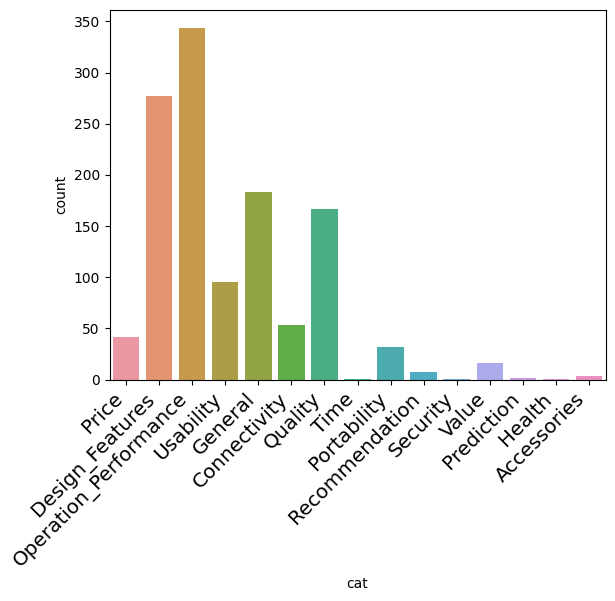

terms        cat                    pol     
Acer         Quality                negative    0.001634
Advertising  Quality                negative    0.000817
Appearance   Design_Features        positive    0.000817
Apple        Price                  negative    0.000817
                                    positive    0.000817
                                                  ...   
Weight       Design_Features        positive    0.000817
WiFi         Connectivity           negative    0.004085
                                    positive    0.003268
Windows      Operation_Performance  negative    0.001634
Wireless     Connectivity           negative    0.000817
Length: 234, dtype: float64


In [100]:
percent = df2.value_counts(normalize=True).sort_index()
sb.countplot(x=df2['cat'])
plt.xticks(rotation=45, 
           horizontalalignment='right',
           fontweight='light',
           fontsize='x-large')
plt.show()
print(percent)

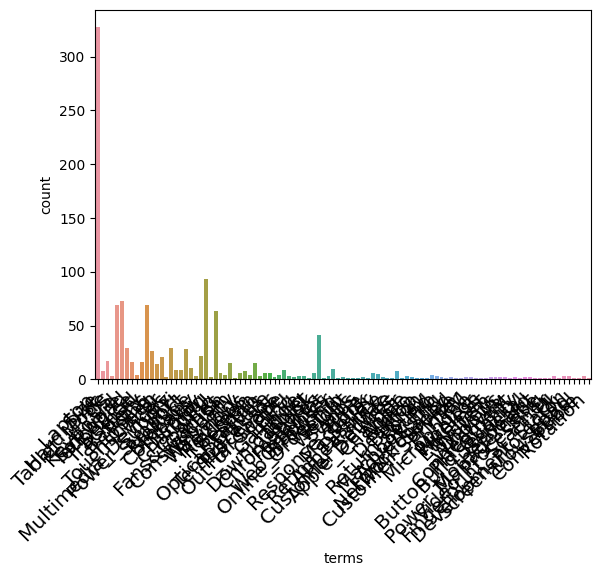

terms        cat                    pol     
Acer         Quality                negative    0.001634
Advertising  Quality                negative    0.000817
Appearance   Design_Features        positive    0.000817
Apple        Price                  negative    0.000817
                                    positive    0.000817
                                                  ...   
Weight       Design_Features        positive    0.000817
WiFi         Connectivity           negative    0.004085
                                    positive    0.003268
Windows      Operation_Performance  negative    0.001634
Wireless     Connectivity           negative    0.000817
Length: 234, dtype: float64


In [101]:
percent = df2.value_counts(normalize=True).sort_index()
sb.countplot(x=df2['terms'])
plt.xticks(rotation=45, 
           horizontalalignment='right',
           fontweight='light',
           fontsize='x-large')
plt.show()
print(percent)

In [23]:
import plotly.express as px

In [103]:
fig = px.bar(
    df_cat,
    x="cat",
    y="counts",
    color="pol",
    barmode="stack",
    color_discrete_map={
        "positive": "#52AC5E",
        "negative": "#e34a2d",
        "neutral": "gray",
    },
    title="Categories vs Polarity",
    template="plotly_white",
)

fig.show()

In [104]:
fig = px.bar(
    df_terms,
    x="terms",
    y="counts",
    color="pol",
    barmode="stack",
    color_discrete_map={
        "positive": "#52AC5E",
        "negative": "#e34a2d",
        "neutral": "gray",
    },
    title="Aspect Terms vs Polarity",
    template="plotly_white",
)

fig.show()


In [105]:
fig = px.bar(
    df_terms_cat,
    x="cat",
    y="counts",
    color="terms",
    barmode="stack",
    color_discrete_map={
        "positive": "#52AC5E",
        "negative": "#e34a2d",
        "neutral": "gray",
    },
    title="Categories vs Aspect Terms",
    template="plotly_white",
)

fig.show()

In [106]:
fig = px.pie(df_cat, values='counts', names='cat', title='Categories Count')
fig.show()

In [124]:
fig = px.pie(df_terms, values='counts', names='terms', title='Terms Count')

fig.show()

In [108]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# from nltk.corpus import stopwords
# stop_words = set(stopwords.words('english'))
# stop_words.update(["laptop", "computer"])

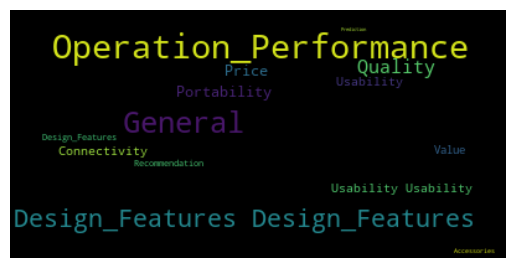

In [109]:
# Start with one review:
text = " ".join(category for category in df2.loc[df2['pol']=="positive", "cat"])

# Create and generate a word cloud image:
# wordcloud = WordCloud(max_words=100, stopwords=stop_words).generate(text)
wordcloud = WordCloud(max_words=100).generate(text)
# max_font_size=50, background_color="white"

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

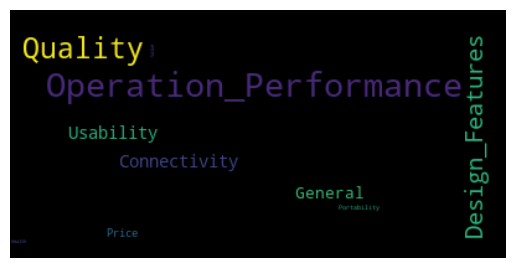

In [110]:
# Start with one review:
text = " ".join(category for category in df2.loc[df2['pol']=="negative", "cat"])

# Create and generate a word cloud image:
# wordcloud = WordCloud(max_words=100, stopwords=stop_words).generate(text)
wordcloud = WordCloud(max_words=100).generate(text)
# max_font_size=50, background_color="white"

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

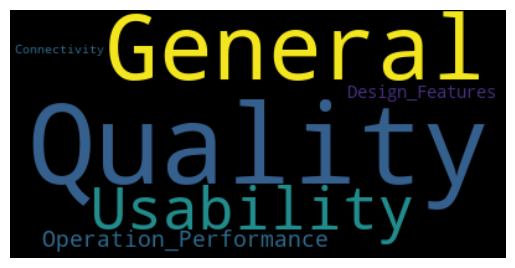

In [111]:
# Start with one review:
text = " ".join(category for category in df2.loc[df2['pol']=="neutral", "cat"])

# Create and generate a word cloud image:
# wordcloud = WordCloud(max_words=100, stopwords=stop_words).generate(text)
wordcloud = WordCloud(max_words=100).generate(text)
# max_font_size=50, background_color="white"

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

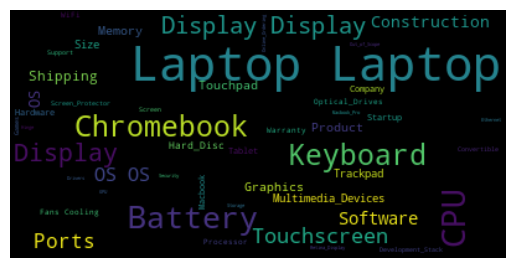

In [112]:
# Start with one review:
text = " ".join(term for term in df2.loc[df2['pol']=="positive","terms"])

# Create and generate a word cloud image:
# wordcloud = WordCloud(max_words=100, stopwords=stop_words).generate(text)
wordcloud = WordCloud(max_words=100).generate(text)
# max_font_size=50, background_color="white"

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

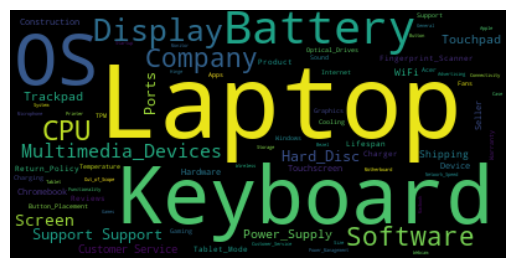

In [113]:
# Start with one review:
text = " ".join(term for term in df2.loc[df2['pol']=="negative","terms"])

# Create and generate a word cloud image:
# wordcloud = WordCloud(max_words=100, stopwords=stop_words).generate(text)
wordcloud = WordCloud(max_words=100).generate(text)
# max_font_size=50, background_color="white"

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

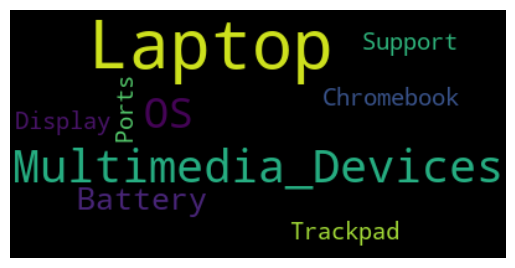

In [114]:
# Start with one review:
text = " ".join(term for term in df2.loc[df2['pol']=="neutral","terms"])

# Create and generate a word cloud image:
# wordcloud = WordCloud(max_words=100, stopwords=stop_words).generate(text)
wordcloud = WordCloud(max_words=100).generate(text)
# max_font_size=50, background_color="white"

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [115]:
import plotly.graph_objects as go

fig1 = go.Figure(data=[go.Pie(labels=df_cat.pol, values=df_cat.counts, hole=.3, title='Polarity Count')])
fig1.show()

In [116]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=2, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}], [{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=df_cat.loc[df_cat['pol']=="positive",'cat'], 
                     values=df_cat.loc[df_cat['pol']=="positive",'counts'], 
                      name="pos"), 1, 1) #scalegroup='on',
fig.add_trace(go.Pie(labels=df_cat.loc[df_cat['pol']=="neutral",'cat'], 
                     values=df_cat.loc[df_cat['pol']=="neutral",'counts'], 
                     name="neu"), 2, 1) #scalegroup='on',
fig.add_trace(go.Pie(labels=df_cat.loc[df_cat['pol']=="negative",'cat'], 
                     values=df_cat.loc[df_cat['pol']=="negative",'counts'], 
                     name="neg"), 1, 2) #scalegroup='on'
fig.add_trace(go.Pie(labels=df_cat['pol'], 
                     values=df_cat['counts'], 
                     name="pol"), 2, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.3, hoverinfo="label+percent+name")
fig.update_layout(margin=dict(t=0, b=0, l=0, r=0))


fig.show()

In [121]:
# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=2, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}], [{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=df_terms.loc[df_terms['pol']=="positive",'terms'], 
                     values=df_terms.loc[df_terms['pol']=="positive",'counts'], 
                     name="pos"), 1, 1) #scalegroup='on'
fig.add_trace(go.Pie(labels=df_terms.loc[df_terms['pol']=="neutral",'terms'], 
                     values=df_terms.loc[df_terms['pol']=="neutral",'counts'], 
                     name="neu"), 2, 1) #scalegroup='on'
fig.add_trace(go.Pie(labels=df_terms.loc[df_terms['pol']=="negative",'terms'], 
                     values=df_terms.loc[df_terms['pol']=="negative",'counts'], 
                     name="neg"), 1, 2) #scalegroup='on'
fig.add_trace(go.Pie(labels=df_terms['pol'], 
                     values=df_terms['counts'], 
                     name="pol"), 2, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")
fig.update_layout(margin=dict(t=0, b=0, l=0, r=0))


fig.show()

In [119]:
# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])

fig.add_trace(go.Pie(labels=df_terms_cat['cat'], 
                     values=df_terms_cat['counts'], 
                     name="category"), 1, 1)
fig.add_trace(go.Pie(labels=df_terms_cat['terms'], 
                     values=df_terms_cat['counts'], 
                     name="term"), 1, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")
fig.update_layout(margin=dict(t=0, b=0, l=0, r=0))


fig.show()

In [25]:
df_cat.loc[df_cat['counts'] < 20, 'cat'] = 'Others' # Represent less frequently observerd terms
fig = px.pie(df_cat, values='counts', names='cat', title='Categories Count')
fig.show()

In [26]:
df_terms.loc[df_terms['counts'] < 20, 'terms'] = 'Others' # Represent less frequently observerd terms
fig = px.pie(df_terms, values='counts', names='terms', title='Terms Count')
fig.show()

In [127]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=2, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}], [{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=df_cat.loc[df_cat['pol']=="positive",'cat'], 
                     values=df_cat.loc[df_cat['pol']=="positive",'counts'], 
                      name="pos"), 1, 1) #scalegroup='on',
fig.add_trace(go.Pie(labels=df_cat.loc[df_cat['pol']=="neutral",'cat'], 
                     values=df_cat.loc[df_cat['pol']=="neutral",'counts'], 
                     name="neu"), 2, 1) #scalegroup='on',
fig.add_trace(go.Pie(labels=df_cat.loc[df_cat['pol']=="negative",'cat'], 
                     values=df_cat.loc[df_cat['pol']=="negative",'counts'], 
                     name="neg"), 1, 2) #scalegroup='on'
fig.add_trace(go.Pie(labels=df_cat['pol'], 
                     values=df_cat['counts'], 
                     name="pol"), 2, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.3, hoverinfo="label+percent+name")


fig.show()

In [128]:
# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=2, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}], [{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=df_terms.loc[df_terms['pol']=="positive",'terms'], 
                     values=df_terms.loc[df_terms['pol']=="positive",'counts'], 
                     name="pos"), 1, 1) #scalegroup='on'
fig.add_trace(go.Pie(labels=df_terms.loc[df_terms['pol']=="neutral",'terms'], 
                     values=df_terms.loc[df_terms['pol']=="neutral",'counts'], 
                     name="neu"), 2, 1) #scalegroup='on'
fig.add_trace(go.Pie(labels=df_terms.loc[df_terms['pol']=="negative",'terms'], 
                     values=df_terms.loc[df_terms['pol']=="negative",'counts'], 
                     name="neg"), 1, 2) #scalegroup='on'
fig.add_trace(go.Pie(labels=df_terms['pol'], 
                     values=df_terms['counts'], 
                     name="pol"), 2, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")


fig.show()

In [131]:
# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])

fig.add_trace(go.Pie(labels=df_terms_cat['cat'], 
                     values=df_terms_cat['counts'], 
                     name="category"), 1, 1)
fig.add_trace(go.Pie(labels=df_terms_cat['terms'], 
                     values=df_terms_cat['counts'], 
                     name="term"), 1, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")
fig.update_layout(margin=dict(t=0, b=0, l=0, r=0))


fig.show()

#### Display results in HTML

This will display the annotated feedbacks in a prettier way using HTML.

In [132]:
import re
from IPython.display import display, HTML
from html import escape

css = """
<style>
    .container {
        background-color: #fff;
        padding: 15px
    }

    p.feedback {
        margin-top: 5px;
        color: #595f6d;
        line-height: 2
    }

    .annotation {
        color: #777;
        padding: 2px;
        font-weight: bold !important;
        border-radius: 1px;
        border-bottom: 4px solid;
    }

    .aspect {
        color: #6eb2e7;
        padding-left: 10px;
        font-size: 12px;
    }
</style>
"""


def ireplace(text, old, new):
    pattern = re.compile(old, re.IGNORECASE)
    return pattern.sub(new, text)


html = f"{css}"

for i, review in enumerate(df.to_dict("records")):
    text = escape(review["text"])

    try:
        for ann in analysis_results[i]:
            color = "#2bbf6d" if ann["sentiment"] == "positive" else "#cf2a43"

            text = ireplace(
                text,
                ann["segment"],
                f"<span class='annotation' style='border-color: {color}'>{escape(ann['segment'])} <span class='aspect'>{ann['aspect']}<span class='category'>{'#'+ann['category']}</span></span>",
            )

        html += f"""

            <div class='container'>
                <p class='feedback'>{text}</p>
            </div>
        """

    except Exception as e:
        print(f"Failed to parse {review['text']} {e}")
        continue

display(HTML(html))


#### Accuracy

In [133]:
import pandas as pd
from ast import literal_eval

In [134]:
#loading the data
data = pd.read_csv("./data/output/laptop/laptop_out_final_exp1.csv")
data.head(5)

,text,term_true,cat_true,pol_true,analysis,term,cat,pol,seg
0,"the unit cost $ 275 to start with , so it is n...",['LAPTOP'],['PRICE'],['0'],"[{'category': 'Price', 'aspect': 'Laptop', 'se...","['Laptop', 'Laptop']","['Price', 'Price']","[0, 0]","['the unit cost $ 275 to start with', 'it is n..."
1,"going from acer 15 to acer 11 was difficult , ...","['LAPTOP', 'LAPTOP']","['DESIGN_FEATURES', 'DESIGN_FEATURES']","['0', '0']","[{'category': 'Design_Features', 'aspect': 'Si...",['Size'],['Design_Features'],[0],['11 inches seems too small for me']
2,also it ' s not a true ssd drive in there but ...,['HARD_DISC'],['OPERATION_PERFORMANCE'],['0'],"[{'category': 'Operation_Performance', 'aspect...","['Hard_Disc', 'Hard_Disc']","['Operation_Performance', 'Operation_Performan...","[0, 0]","['not a true ssd drive in there but emmc', 'wh..."
3,the computer has difficulty switching between ...,['LAPTOP'],['USABILITY'],['0'],"[{'category': 'Operation_Performance', 'aspect...",['Tablet_Mode'],['Operation_Performance'],[0],['the computer has difficulty switching betwee...
4,2 / 28 / 18 - a couple days ago i updated the ...,['OS'],['GENERAL'],['1'],"[{'category': 'Operation_Performance', 'aspect...",['OS'],['Operation_Performance'],[2],['i updated the chrome os']


In [135]:
data['term_true'] = data['term_true'].apply(literal_eval)
data['cat_true'] = data['cat_true'].apply(literal_eval)
data['pol_true'] = data['pol_true'].apply(literal_eval)

data['term'] = data['term'].apply(literal_eval)
data['cat'] = data['cat'].apply(literal_eval)
data['pol'] = data['pol'].apply(literal_eval)

In [136]:
def convert_lower_str(term, cat, pol):
    list_term = []
    list_cat = []
    list_pol = []
    
    # Gets the size of a and b.
    sizeA, sizeB, sizeC = len(term), len(cat), len(pol)

    # print(max([sizeA, sizeB, sizeC]))
    big = max(enumerate([sizeA, sizeB, sizeC]),key=lambda x: x[1])[0]

    if big == 0:
        zeros = ['nil' for _ in range(abs(sizeA-sizeB))]
        zeros1 = ['nil' for _ in range(abs(sizeA-sizeC))]
        cat += zeros
        pol += zeros1
    elif big == 1:
        zeros = ['nil' for _ in range(abs(sizeA-sizeB))]
        zeros1 = ['nil' for _ in range(abs(sizeB-sizeC))]
        term += zeros
        pol += zeros1
    elif big == 2:
        zeros = ['nil' for _ in range(abs(sizeA-sizeC))]
        zeros1 = ['nil' for _ in range(abs(sizeB-sizeC))]
        term += zeros
        cat += zeros1
        
    for i in range(0, len(term)):
        list_term.append(str(term[i]).lower())
        list_cat.append(str(cat[i]).lower())
        list_pol.append(str(pol[i]).lower())
    return pd.Series([list_term, list_cat, list_pol])
data[["term_true","cat_true","pol_true"]] = data.apply(lambda x: convert_lower_str(x["term_true"], x["cat_true"], x["pol_true"]), axis=1)
data[["term","cat","pol"]]= data.apply(lambda x: convert_lower_str(x["term"], x["cat"], x["pol"]), axis=1)

In [137]:
def terms_pol(term, cat, pol):
    list_temp = []
    for i in range(0, len(term)):
        list_temp.append([str(term[i]).lower(), str(cat[i]).lower(), str(pol[i]).lower()])
    return list_temp
data["True"]= data.apply(lambda x: terms_pol(x["term_true"], x["cat_true"], x["pol_true"]), axis=1)
data["Pred"]= data.apply(lambda x: terms_pol(x["term"], x["cat"], x["pol"]), axis=1)

In [138]:
# def compare(list1, list2):
#     for val in list1:
#         if val in list2:
#             return 1
#     return 0
def compare_all(list1, list2):
    if len(list1)==len(list2):
        if all([item in list1 for item in list2]):
            return 1
        else: 
            return 0
    else:
        return 0

In [139]:
data["All_Matched"]= data.apply(lambda x: compare_all(x["True"], x["Pred"]), axis=1)
data["T_All_Matched"]= data.apply(lambda x: compare_all(x["term_true"], x["term"]), axis=1)
data["C_All_Matched"]= data.apply(lambda x: compare_all(x["cat_true"], x["cat"]), axis=1)

In [140]:
print("Number of sentences: ", data.shape[0])
print("Acc of aspect term  %: ", (data["T_All_Matched"].sum()/data.shape[0])*100)
print("Acc of aspect category  %: ", (data["C_All_Matched"].sum()/data.shape[0])*100)
print("Overall acc %: ", (data["All_Matched"].sum()/data.shape[0])*100)

Number of sentences:  816
Acc of aspect term  %:  38.84803921568628
Acc of aspect category  %:  34.80392156862745
Overall acc %:  18.872549019607842
